<a href="https://colab.research.google.com/github/meluxis/Analysis_Transformer_ComputationalCost_Optimization/blob/main/SmallModelT5_Optimized_Pruned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 0 - Connect to drive and authenfication

In [ ]:
#Connect google colab and Google Cloud bucket for storage
#Link google account
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1 - Installing required dependencies in the google colab environment

In [ ]:
# Installing dependencies
!pip install transformers datasets torch torchvision
!pip install tf-keras~=2.16
!pip install Rouge
!pip install sentence-transformers
!pip install codecarbon
!pip install fvcore
!pip install fvcore.nn
!pip install datasets
!pip install tensorflow
!pip install autoawq
!pip install -q -U https://github.com/casper-hansen/AutoAWQ/releases/download/v0.1.6/autoawq-0.1.6+cu118-cp310-cp310-linux_x86_64.whl
!pip install -q transformers accelerate
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Importing libraries

In [ ]:
#import libraries
import torch
import time
import psutil  # For memory usage
import os
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler,
                           autocast

from torch.utils.data import DataLoader,
                             Dataset,
                             random_split

from sentence_transformers import SentenceTransformer,
                                  util
from transformers import T5Tokenizer,
                         T5ForConditionalGeneration,
                         TrainingArguments,
                         Trainer,
                         T5Model,
                         AutoTokenizer,
                         get_scheduler

from datasets import load_dataset
import argparse
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score
from rouge import Rouge
from google.colab import data_table


#### Importing datasets

In [ ]:
#import dataset

dataset = load_dataset("google/Synthetic-Persona-Chat")

train_data = dataset["train"]
test_data = dataset["test"]

# Afficher quelques exemples
print(train_data["user 1 personas"][0:5])  # Afficher 5 exemples
print(train_data["user 2 personas"][0:5])
print(train_data["Best Generated Conversation"][0:5])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Synthetic-Persona-Chat_train.csv:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Synthetic-Persona-Chat_valid.csv:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Synthetic-Persona-Chat_test.csv:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8938 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/968 [00:00<?, ? examples/s]

['I am 32.\nI do not want a job.\nI play video games all day.\nI still live at home with my parents.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.\nI eat all take out.', 'I write.\nI work at mcdonald s.\nI watch youtube videos.\nI have brown hair.', 'I am bald.\nI like to swim.\nMy favorite drink is chocolate milk.\nI don t work.']
['My favorite drink is iced coffee.\nI have a black belt in karate.\nI m in a jazz band and play the saxophone.\nI vacation along lake michigan every summer.', 'I have a ford f150.\nI like ford cars.\nMy truck is black.\nI also like ford trucks.\nI own a ford truck.', 'I can recite the movie young frankenstein word for word.\nI like to make my own clothes.\nI am partially blind.\nI do volunteer work for human rights organizations.\nI can do convincing bird calls.', 'I want to move.\nI don t like feeling

#### Importing and defining model

In [ ]:
#Define model from https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/main/notebooks/t5-trivia.ipynb#scrollTo=DZhAd0U_4B_o

sys.argv = sys.argv[:1]

BASE_DIR = "gs://data_bucket_experimental_analysis" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True

MODEL_SIZE = "small" #@param["small", "base", "large", "3B", "11B"]
PRETRAINED_DIR = "t5-small"
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)


# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

# The models from our paper are based on the Mesh Tensorflow Transformer.
#Change to T5ForConditionalGeneration for finetuning task
model = T5ForConditionalGeneration.from_pretrained(PRETRAINED_DIR)

# Apply magnitude-based pruning
def apply_magnitude_pruning(model, amount=0.1): #10%
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            # Apply L1 unstructured pruning
            module.weight = torch.nn.Parameter(module.weight.contiguous())
            prune.l1_unstructured(module, name="weight", amount=amount)
            # Make pruning permanent (otherwise, pruning masks remain)
            prune.remove(module, name="weight")
            # Ensure weight is contiguous after pruning
            module.weight = torch.nn.Parameter(module.weight.clone().detach())

# Apply pruning
apply_magnitude_pruning(model, amount=0.1)

# Verify pruning effectiveness on pruned (not quantized) model
for name, module in model.named_modules():  # Check sparsity on pruned model
    if isinstance(module, torch.nn.Linear):
        zero_count = torch.sum(module.weight == 0).item()
        total_count = module.weight.nelement()
        sparsity = zero_count / total_count
        print(f"Layer: {name}, Pruned: {sparsity:.2%} of weights")


torch.save(model.state_dict(), "t5_original.pth")
print(f"Original Model Size: {os.path.getsize('t5_original.pth') / 1e6:.2f} MB")
print("T5 model pruned .")




config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Layer: encoder.block.0.layer.0.SelfAttention.q, Pruned: 10.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.k, Pruned: 10.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.v, Pruned: 10.00% of weights
Layer: encoder.block.0.layer.0.SelfAttention.o, Pruned: 10.00% of weights
Layer: encoder.block.0.layer.1.DenseReluDense.wi, Pruned: 10.00% of weights
Layer: encoder.block.0.layer.1.DenseReluDense.wo, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.q, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.k, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.v, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.0.SelfAttention.o, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.1.DenseReluDense.wi, Pruned: 10.00% of weights
Layer: encoder.block.1.layer.1.DenseReluDense.wo, Pruned: 10.00% of weights
Layer: encoder.block.2.layer.0.SelfAttention.q, Pruned: 10.00% of weights
Layer: encoder.block.2.layer.0

#### Verify pruning on weights

In [ ]:
#Verify pruning on weights

# Pick a layer to inspect
layer_name = "encoder.block.0.layer.0.SelfAttention.q"  # Change as needed

# Extract the layer
layer = dict(model.named_modules())[layer_name]

# Print some weight values
print(f"Before Pruning - First 10 Weights of {layer_name}:")
print(layer.weight.flatten()[:10])  # First 10 weights

# Count the number of zeros
zero_count = torch.sum(layer.weight == 0).item()
total_count = layer.weight.nelement()
sparsity = zero_count / total_count

print(f"Layer {layer_name} - Zero Count: {zero_count}, Total: {total_count}, Sparsity: {sparsity:.2%}")


Before Pruning - First 10 Weights of encoder.block.0.layer.0.SelfAttention.q:
tensor([-0.0162, -0.0737,  0.0000,  0.0151, -0.0708,  0.0096, -0.0432,  0.0615,
        -0.0569, -0.0371], grad_fn=<SliceBackward0>)
Layer encoder.block.0.layer.0.SelfAttention.q - Zero Count: 26214, Total: 262144, Sparsity: 10.00%


#### Tokenizing entry points (text)

In [ ]:
# Tokenize inputs

# Load Tokenizer (Ensure it Matches Model Version)
TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

def preprocess_function(examples):
    # Combine personas into a single input string
    inputs = [
              p1 + " " + p2 for p1,
              p2 in zip(examples["user 1 personas"],
                        examples["user 2 personas"])
              ]

    # Tokenize inputs (Persona 1 + Persona 2)
    model_inputs = TOKENIZER(
                             inputs,
                             max_length=256,
                             truncation=True,
                             padding="max_length")

    # Tokenize targets (best-generated conversations)
    conversations = [
                       str(conv) for conv
                       in examples["Best Generated Conversation"]
                    ]
    labels = TOKENIZER(
                       text_target=conversations,
                       max_length=64,
                       truncation=True,
                       padding="max_length"
                       )["input_ids"]

    labels = torch.tensor(labels)
    labels[labels == TOKENIZER.pad_token_id] = -100  # Ignore padding


    # Assign label input_ids
    model_inputs["labels"] = labels

    return model_inputs

# Preprocess Dataset
tokenized_train_dataset = train_data.map(preprocess_function, batched=True, batch_size=16)
tokenized_test_dataset = test_data.map(preprocess_function, batched=True, batch_size=16)

# Example Usage (Access Tokenized Data)
print(tokenized_train_dataset[0]["input_ids"])
print(tokenized_train_dataset[0]["labels"])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/8938 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

[27, 183, 3538, 5, 27, 103, 59, 241, 3, 9, 613, 5, 27, 577, 671, 1031, 66, 239, 5, 27, 341, 619, 44, 234, 28, 82, 1362, 5, 499, 1305, 3281, 19, 3, 867, 26, 1975, 5, 27, 43, 3, 9, 1001, 6782, 16, 3, 4031, 342, 5, 27, 3, 51, 16, 3, 9, 9948, 1928, 11, 577, 8, 3, 7, 9, 226, 32, 6399, 5, 27, 4257, 590, 6957, 2278, 12588, 334, 1248, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6674, 209, 10, 2018, 55, 27, 31, 51, 784, 10041, 209, 31, 7, 564, 4275, 6674, 204, 10, 2018, 784, 10041, 209, 31, 7, 564, 13

#### Create DataLoader

In [ ]:
#Create DataLoaders
#Transform Data for compatibility with pytorch

# Create a custom Dataset class
class PersonaChatDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['labels'])
        }

# Create DataLoaders
train_dataset = PersonaChatDataset(tokenized_train_dataset)
test_dataset = PersonaChatDataset(tokenized_test_dataset)

# Define the validation split ratio (e.g., 80% test, 20% validation)
val_size = int(0.2 * len(test_dataset))  # 20% for validation
test_size = len(test_dataset) - val_size  # 80% for testing

# Split the test dataset into validation and actual test sets
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5) # Adjust batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=5) # Adjust batch size as needed
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=5)  # Validation data
print(train_dataset[0])


{'input_ids': tensor([   27,   183,  3538,     5,    27,   103,    59,   241,     3,     9,
          613,     5,    27,   577,   671,  1031,    66,   239,     5,    27,
          341,   619,    44,   234,    28,    82,  1362,     5,   499,  1305,
         3281,    19,     3,   867,    26,  1975,     5,    27,    43,     3,
            9,  1001,  6782,    16,     3,  4031,   342,     5,    27,     3,
           51,    16,     3,     9,  9948,  1928,    11,   577,     8,     3,
            7,     9,   226,    32,  6399,     5,    27,  4257,   590,  6957,
         2278, 12588,   334,  1248,     5,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

#### Fine-tuning model

<ipython-input-10-2fce5c067917>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
[codecarbon INFO @ 03:08:45] [setup] RAM Tracking...
[codecarbon INFO @ 03:08:45] [setup] CPU Tracking...
[codecarbon WARNING @ 03:08:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Epoch 1/3


[codecarbon INFO @ 03:08:46] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 03:08:46] [setup] GPU Tracking...
[codecarbon INFO @ 03:08:46] No GPU found.
[codecarbon INFO @ 03:08:46] >>> Tracker's metadata:
[codecarbon INFO @ 03:08:46]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:08:46]   Python version: 3.11.11
[codecarbon INFO @ 03:08:46]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:08:46]   Available RAM : 50.994 GB
[codecarbon INFO @ 03:08:46]   CPU count: 8
[codecarbon INFO @ 03:08:46]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 03:08:46]   GPU count: None
[codecarbon INFO @ 03:08:46]   GPU model: None
[codecarbon INFO @ 03:08:46] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-10-2fce5c067917>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3

Batch 1/559 - Loss: 4.033178806304932


  0%|          | 2/559 [00:12<56:53,  6.13s/it]  

Batch 2/559 - Loss: 3.924137830734253


[codecarbon INFO @ 03:09:01] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:09:01] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:09:01] 0.000580 kWh of electricity used since the beginning.
  1%|          | 3/559 [00:17<50:41,  5.47s/it]

Batch 3/559 - Loss: 4.001865386962891


  1%|          | 4/559 [00:21<46:57,  5.08s/it]

Batch 4/559 - Loss: 4.072559356689453


  1%|          | 5/559 [00:26<44:28,  4.82s/it]

Batch 5/559 - Loss: 3.9611525535583496


[codecarbon INFO @ 03:09:16] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:09:16] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:09:16] 0.001159 kWh of electricity used since the beginning.
  1%|          | 6/559 [00:30<43:28,  4.72s/it]

Batch 6/559 - Loss: 3.9528050422668457


  1%|▏         | 7/559 [00:35<42:42,  4.64s/it]

Batch 7/559 - Loss: 4.074414253234863


  1%|▏         | 8/559 [00:39<42:50,  4.67s/it]

Batch 8/559 - Loss: 4.065109729766846


  2%|▏         | 9/559 [00:44<42:01,  4.58s/it]

Batch 9/559 - Loss: 3.701709508895874


[codecarbon INFO @ 03:09:31] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:09:31] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:09:31] 0.001739 kWh of electricity used since the beginning.
  2%|▏         | 10/559 [00:48<41:31,  4.54s/it]

Batch 10/559 - Loss: 3.9613776206970215


  2%|▏         | 11/559 [00:53<41:40,  4.56s/it]

Batch 11/559 - Loss: 4.012077808380127


  2%|▏         | 12/559 [00:57<41:00,  4.50s/it]

Batch 12/559 - Loss: 3.899400234222412


[codecarbon INFO @ 03:09:46] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:09:46] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:09:46] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 13/559 [01:02<41:03,  4.51s/it]

Batch 13/559 - Loss: 3.615888833999634


  3%|▎         | 14/559 [01:06<40:50,  4.50s/it]

Batch 14/559 - Loss: 3.846771478652954


  3%|▎         | 15/559 [01:11<40:49,  4.50s/it]

Batch 15/559 - Loss: 4.069507598876953


[codecarbon INFO @ 03:10:01] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:10:01] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:10:01] 0.002898 kWh of electricity used since the beginning.
  3%|▎         | 16/559 [01:15<40:55,  4.52s/it]

Batch 16/559 - Loss: 4.024922847747803


  3%|▎         | 17/559 [01:20<40:46,  4.51s/it]

Batch 17/559 - Loss: 3.7939019203186035


  3%|▎         | 18/559 [01:24<40:55,  4.54s/it]

Batch 18/559 - Loss: 3.8689281940460205


  3%|▎         | 19/559 [01:29<40:42,  4.52s/it]

Batch 19/559 - Loss: 4.084012031555176


[codecarbon INFO @ 03:10:16] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:10:16] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:10:16] 0.003478 kWh of electricity used since the beginning.
  4%|▎         | 20/559 [01:33<40:37,  4.52s/it]

Batch 20/559 - Loss: 3.76692795753479


  4%|▍         | 21/559 [01:38<40:34,  4.53s/it]

Batch 21/559 - Loss: 4.146153926849365


  4%|▍         | 22/559 [01:42<40:19,  4.51s/it]

Batch 22/559 - Loss: 3.8162293434143066


[codecarbon INFO @ 03:10:31] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:10:31] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:10:31] 0.004058 kWh of electricity used since the beginning.
  4%|▍         | 23/559 [01:47<40:25,  4.52s/it]

Batch 23/559 - Loss: 3.8704099655151367


  4%|▍         | 24/559 [01:51<40:18,  4.52s/it]

Batch 24/559 - Loss: 3.950340747833252


  4%|▍         | 25/559 [01:56<40:08,  4.51s/it]

Batch 25/559 - Loss: 3.965712785720825


[codecarbon INFO @ 03:10:46] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:10:46] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:10:46] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:10:46] 0.011032 g.CO2eq/s mean an estimation of 347.90006725101154 kg.CO2eq/year
  5%|▍         | 26/559 [02:00<40:06,  4.52s/it]

Batch 26/559 - Loss: 3.792301893234253


  5%|▍         | 27/559 [02:05<39:56,  4.50s/it]

Batch 27/559 - Loss: 4.103131294250488


  5%|▌         | 28/559 [02:09<39:51,  4.50s/it]

Batch 28/559 - Loss: 3.815119981765747


  5%|▌         | 29/559 [02:14<40:00,  4.53s/it]

Batch 29/559 - Loss: 3.975973606109619


[codecarbon INFO @ 03:11:01] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:11:01] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:11:01] 0.005217 kWh of electricity used since the beginning.
  5%|▌         | 30/559 [02:19<40:21,  4.58s/it]

Batch 30/559 - Loss: 3.935100793838501


  6%|▌         | 31/559 [02:23<40:20,  4.58s/it]

Batch 31/559 - Loss: 3.899411201477051


  6%|▌         | 32/559 [02:28<39:40,  4.52s/it]

Batch 32/559 - Loss: 4.033562183380127


[codecarbon INFO @ 03:11:16] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:11:16] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:11:16] 0.005796 kWh of electricity used since the beginning.
  6%|▌         | 33/559 [02:32<39:19,  4.49s/it]

Batch 33/559 - Loss: 3.9230704307556152


  6%|▌         | 34/559 [02:37<39:38,  4.53s/it]

Batch 34/559 - Loss: 4.075691223144531


  6%|▋         | 35/559 [02:41<39:23,  4.51s/it]

Batch 35/559 - Loss: 3.897172689437866


[codecarbon INFO @ 03:11:31] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:11:31] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:11:31] 0.006376 kWh of electricity used since the beginning.
  6%|▋         | 36/559 [02:46<39:29,  4.53s/it]

Batch 36/559 - Loss: 3.96749210357666


  7%|▋         | 37/559 [02:50<39:15,  4.51s/it]

Batch 37/559 - Loss: 4.018261432647705


  7%|▋         | 38/559 [02:55<39:06,  4.50s/it]

Batch 38/559 - Loss: 3.995759963989258


  7%|▋         | 39/559 [02:59<39:20,  4.54s/it][codecarbon INFO @ 03:11:46] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:11:46] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:11:46] 0.006956 kWh of electricity used since the beginning.


Batch 39/559 - Loss: 4.121166229248047


  7%|▋         | 40/559 [03:04<38:50,  4.49s/it]

Batch 40/559 - Loss: 3.689484119415283


  7%|▋         | 41/559 [03:08<38:41,  4.48s/it]

Batch 41/559 - Loss: 3.943267583847046


  8%|▊         | 42/559 [03:13<38:25,  4.46s/it]

Batch 42/559 - Loss: 3.993967294692993


[codecarbon INFO @ 03:12:01] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:01] Energy consumed for all CPUs : 0.006500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:01] 0.007535 kWh of electricity used since the beginning.
  8%|▊         | 43/559 [03:17<38:35,  4.49s/it]

Batch 43/559 - Loss: 3.8257741928100586


  8%|▊         | 44/559 [03:22<38:40,  4.51s/it]

Batch 44/559 - Loss: 3.923218250274658


  8%|▊         | 45/559 [03:26<38:36,  4.51s/it]

Batch 45/559 - Loss: 3.9854471683502197


[codecarbon INFO @ 03:12:16] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:16] Energy consumed for all CPUs : 0.007000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:16] 0.008115 kWh of electricity used since the beginning.
  8%|▊         | 46/559 [03:31<38:26,  4.50s/it]

Batch 46/559 - Loss: 3.9359991550445557


  8%|▊         | 47/559 [03:35<38:14,  4.48s/it]

Batch 47/559 - Loss: 3.8397774696350098


  9%|▊         | 48/559 [03:39<37:57,  4.46s/it]

Batch 48/559 - Loss: 3.7845215797424316


  9%|▉         | 49/559 [03:44<38:05,  4.48s/it]

Batch 49/559 - Loss: 3.777423620223999


[codecarbon INFO @ 03:12:31] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:31] Energy consumed for all CPUs : 0.007500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:31] 0.008695 kWh of electricity used since the beginning.
  9%|▉         | 50/559 [03:48<37:59,  4.48s/it]

Batch 50/559 - Loss: 3.93709659576416


  9%|▉         | 51/559 [03:53<38:14,  4.52s/it]

Batch 51/559 - Loss: 3.7416203022003174


  9%|▉         | 52/559 [03:57<37:51,  4.48s/it]

Batch 52/559 - Loss: 3.966536283493042


[codecarbon INFO @ 03:12:46] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:46] Energy consumed for all CPUs : 0.008000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:46] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:12:46] 0.011032 g.CO2eq/s mean an estimation of 347.9052914623193 kg.CO2eq/year
  9%|▉         | 53/559 [04:02<37:39,  4.46s/it]

Batch 53/559 - Loss: 3.9451208114624023


 10%|▉         | 54/559 [04:06<37:38,  4.47s/it]

Batch 54/559 - Loss: 3.742304801940918


 10%|▉         | 55/559 [04:11<37:20,  4.44s/it]

Batch 55/559 - Loss: 3.716956853866577


[codecarbon INFO @ 03:13:01] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:01] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:01] 0.009854 kWh of electricity used since the beginning.
 10%|█         | 56/559 [04:15<37:19,  4.45s/it]

Batch 56/559 - Loss: 3.9415242671966553


 10%|█         | 57/559 [04:20<37:22,  4.47s/it]

Batch 57/559 - Loss: 3.971142530441284


 10%|█         | 58/559 [04:26<42:42,  5.12s/it]

Batch 58/559 - Loss: 3.81005597114563


[codecarbon INFO @ 03:13:16] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:16] Energy consumed for all CPUs : 0.009000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:16] 0.010433 kWh of electricity used since the beginning.
 11%|█         | 59/559 [04:33<46:43,  5.61s/it]

Batch 59/559 - Loss: 3.9513049125671387


 11%|█         | 60/559 [04:41<51:42,  6.22s/it]

Batch 60/559 - Loss: 3.846386194229126


[codecarbon INFO @ 03:13:31] Energy consumed for RAM : 0.001514 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:31] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:31] 0.011013 kWh of electricity used since the beginning.
 11%|█         | 61/559 [04:48<52:50,  6.37s/it]

Batch 61/559 - Loss: 3.9667773246765137


 11%|█         | 62/559 [04:53<49:59,  6.04s/it]

Batch 62/559 - Loss: 3.922752857208252


 11%|█▏        | 63/559 [04:57<46:27,  5.62s/it]

Batch 63/559 - Loss: 4.044330596923828


[codecarbon INFO @ 03:13:46] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:46] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:46] 0.011593 kWh of electricity used since the beginning.
 11%|█▏        | 64/559 [05:02<43:50,  5.32s/it]

Batch 64/559 - Loss: 3.6757214069366455


 12%|█▏        | 65/559 [05:07<42:37,  5.18s/it]

Batch 65/559 - Loss: 3.8092031478881836


 12%|█▏        | 66/559 [05:11<41:01,  4.99s/it]

Batch 66/559 - Loss: 3.7903246879577637


[codecarbon INFO @ 03:14:01] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:01] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:01] 0.012172 kWh of electricity used since the beginning.
 12%|█▏        | 67/559 [05:16<40:03,  4.88s/it]

Batch 67/559 - Loss: 3.79738187789917


 12%|█▏        | 68/559 [05:21<39:16,  4.80s/it]

Batch 68/559 - Loss: 3.8006505966186523


 12%|█▏        | 69/559 [05:25<38:39,  4.73s/it]

Batch 69/559 - Loss: 3.849221706390381


[codecarbon INFO @ 03:14:16] Energy consumed for RAM : 0.001753 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:16] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:16] 0.012752 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [05:30<38:29,  4.72s/it]

Batch 70/559 - Loss: 3.43857741355896


 13%|█▎        | 71/559 [05:35<38:06,  4.69s/it]

Batch 71/559 - Loss: 3.8403189182281494


 13%|█▎        | 72/559 [05:39<37:45,  4.65s/it]

Batch 72/559 - Loss: 3.9052369594573975


 13%|█▎        | 73/559 [05:44<37:16,  4.60s/it]

Batch 73/559 - Loss: 3.815128803253174


[codecarbon INFO @ 03:14:31] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:31] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:31] 0.013331 kWh of electricity used since the beginning.
 13%|█▎        | 74/559 [05:48<36:52,  4.56s/it]

Batch 74/559 - Loss: 3.816293478012085


 13%|█▎        | 75/559 [05:53<37:25,  4.64s/it]

Batch 75/559 - Loss: 3.9105446338653564


 14%|█▎        | 76/559 [05:57<37:07,  4.61s/it]

Batch 76/559 - Loss: 3.7336676120758057


[codecarbon INFO @ 03:14:46] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:46] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:46] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:14:46] 0.011032 g.CO2eq/s mean an estimation of 347.8937729165686 kg.CO2eq/year
 14%|█▍        | 77/559 [06:02<37:04,  4.62s/it]

Batch 77/559 - Loss: 3.800914764404297


 14%|█▍        | 78/559 [06:07<37:03,  4.62s/it]

Batch 78/559 - Loss: 3.7482643127441406


 14%|█▍        | 79/559 [06:11<36:55,  4.62s/it]

Batch 79/559 - Loss: 3.854804754257202


[codecarbon INFO @ 03:15:01] Energy consumed for RAM : 0.001992 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:01] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:01] 0.014491 kWh of electricity used since the beginning.
 14%|█▍        | 80/559 [06:16<37:06,  4.65s/it]

Batch 80/559 - Loss: 3.8961546421051025


 14%|█▍        | 81/559 [06:21<37:03,  4.65s/it]

Batch 81/559 - Loss: 3.6334829330444336


 15%|█▍        | 82/559 [06:25<37:07,  4.67s/it]

Batch 82/559 - Loss: 3.631812334060669


[codecarbon INFO @ 03:15:16] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:16] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:16] 0.015070 kWh of electricity used since the beginning.
 15%|█▍        | 83/559 [06:30<36:55,  4.65s/it]

Batch 83/559 - Loss: 3.8024895191192627


 15%|█▌        | 84/559 [06:35<37:10,  4.70s/it]

Batch 84/559 - Loss: 3.7036709785461426


 15%|█▌        | 85/559 [06:40<37:27,  4.74s/it]

Batch 85/559 - Loss: 3.682473659515381


 15%|█▌        | 86/559 [06:44<37:19,  4.73s/it][codecarbon INFO @ 03:15:31] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:31] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:31] 0.015650 kWh of electricity used since the beginning.


Batch 86/559 - Loss: 3.6876039505004883


 16%|█▌        | 87/559 [06:49<37:22,  4.75s/it]

Batch 87/559 - Loss: 3.8366880416870117


 16%|█▌        | 88/559 [06:54<37:19,  4.75s/it]

Batch 88/559 - Loss: 3.768275499343872


 16%|█▌        | 89/559 [06:59<37:16,  4.76s/it]

Batch 89/559 - Loss: 3.7783429622650146


[codecarbon INFO @ 03:15:46] Energy consumed for RAM : 0.002231 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:46] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:46] 0.016230 kWh of electricity used since the beginning.
 16%|█▌        | 90/559 [07:03<36:55,  4.72s/it]

Batch 90/559 - Loss: 3.6845860481262207


 16%|█▋        | 91/559 [07:08<36:47,  4.72s/it]

Batch 91/559 - Loss: 3.7526445388793945


 16%|█▋        | 92/559 [07:13<37:20,  4.80s/it]

Batch 92/559 - Loss: 3.6945905685424805


[codecarbon INFO @ 03:16:01] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:01] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:01] 0.016809 kWh of electricity used since the beginning.
 17%|█▋        | 93/559 [07:18<36:50,  4.74s/it]

Batch 93/559 - Loss: 3.559875965118408


 17%|█▋        | 94/559 [07:22<36:59,  4.77s/it]

Batch 94/559 - Loss: 3.6765222549438477


 17%|█▋        | 95/559 [07:27<36:33,  4.73s/it]

Batch 95/559 - Loss: 3.635565757751465


[codecarbon INFO @ 03:16:16] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:16] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:16] 0.017389 kWh of electricity used since the beginning.
 17%|█▋        | 96/559 [07:32<36:09,  4.69s/it]

Batch 96/559 - Loss: 3.496968984603882


 17%|█▋        | 97/559 [07:37<36:38,  4.76s/it]

Batch 97/559 - Loss: 3.6824002265930176


 18%|█▊        | 98/559 [07:41<36:01,  4.69s/it]

Batch 98/559 - Loss: 3.5590360164642334


[codecarbon INFO @ 03:16:31] Energy consumed for RAM : 0.002470 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:31] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:31] 0.017968 kWh of electricity used since the beginning.
 18%|█▊        | 99/559 [07:46<36:13,  4.72s/it]

Batch 99/559 - Loss: 3.7051188945770264


 18%|█▊        | 100/559 [07:51<35:52,  4.69s/it]

Batch 100/559 - Loss: 3.3230643272399902


 18%|█▊        | 101/559 [07:55<35:44,  4.68s/it]

Batch 101/559 - Loss: 3.680180311203003


[codecarbon INFO @ 03:16:46] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:46] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:46] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:16:46] 0.011032 g.CO2eq/s mean an estimation of 347.90660740116004 kg.CO2eq/year
 18%|█▊        | 102/559 [08:00<35:57,  4.72s/it]

Batch 102/559 - Loss: 3.5792200565338135


 18%|█▊        | 103/559 [08:05<35:45,  4.70s/it]

Batch 103/559 - Loss: 3.6045355796813965


 19%|█▊        | 104/559 [08:09<35:39,  4.70s/it]

Batch 104/559 - Loss: 3.628516674041748


 19%|█▉        | 105/559 [08:14<35:22,  4.67s/it]

Batch 105/559 - Loss: 3.638892412185669


[codecarbon INFO @ 03:17:01] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:01] Energy consumed for all CPUs : 0.016499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:01] 0.019128 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [08:19<35:28,  4.70s/it]

Batch 106/559 - Loss: 3.639577865600586


 19%|█▉        | 107/559 [08:24<35:41,  4.74s/it]

Batch 107/559 - Loss: 3.542813301086426


 19%|█▉        | 108/559 [08:28<35:06,  4.67s/it]

Batch 108/559 - Loss: 3.6814072132110596


[codecarbon INFO @ 03:17:16] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:16] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:16] 0.019707 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [08:33<35:15,  4.70s/it]

Batch 109/559 - Loss: 3.4816665649414062


 20%|█▉        | 110/559 [08:38<35:03,  4.68s/it]

Batch 110/559 - Loss: 3.475860118865967


 20%|█▉        | 111/559 [08:42<35:11,  4.71s/it]

Batch 111/559 - Loss: 3.631176471710205


[codecarbon INFO @ 03:17:31] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:31] Energy consumed for all CPUs : 0.017499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:31] 0.020287 kWh of electricity used since the beginning.
 20%|██        | 112/559 [08:47<34:43,  4.66s/it]

Batch 112/559 - Loss: 3.5140206813812256


 20%|██        | 113/559 [08:51<34:27,  4.64s/it]

Batch 113/559 - Loss: 3.514410972595215


 20%|██        | 114/559 [08:56<34:44,  4.68s/it]

Batch 114/559 - Loss: 3.509328842163086


[codecarbon INFO @ 03:17:46] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:46] Energy consumed for all CPUs : 0.017999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:46] 0.020867 kWh of electricity used since the beginning.
 21%|██        | 115/559 [09:01<34:26,  4.65s/it]

Batch 115/559 - Loss: 3.538221836090088


 21%|██        | 116/559 [09:06<34:28,  4.67s/it]

Batch 116/559 - Loss: 3.6184780597686768


 21%|██        | 117/559 [09:10<34:14,  4.65s/it]

Batch 117/559 - Loss: 3.581123113632202


[codecarbon INFO @ 03:18:01] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:01] Energy consumed for all CPUs : 0.018499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:01] 0.021446 kWh of electricity used since the beginning.
 21%|██        | 118/559 [09:15<34:03,  4.63s/it]

Batch 118/559 - Loss: 3.5569093227386475


 21%|██▏       | 119/559 [09:20<34:30,  4.71s/it]

Batch 119/559 - Loss: 3.3272767066955566


 21%|██▏       | 120/559 [09:24<34:04,  4.66s/it]

Batch 120/559 - Loss: 3.4997832775115967


 22%|██▏       | 121/559 [09:29<34:10,  4.68s/it]

Batch 121/559 - Loss: 3.490717649459839


[codecarbon INFO @ 03:18:16] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:16] Energy consumed for all CPUs : 0.018999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:16] 0.022026 kWh of electricity used since the beginning.
 22%|██▏       | 122/559 [09:34<34:00,  4.67s/it]

Batch 122/559 - Loss: 3.331690788269043


 22%|██▏       | 123/559 [09:38<33:43,  4.64s/it]

Batch 123/559 - Loss: 3.4314680099487305


 22%|██▏       | 124/559 [09:43<33:47,  4.66s/it]

Batch 124/559 - Loss: 3.390836477279663


[codecarbon INFO @ 03:18:31] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:31] Energy consumed for all CPUs : 0.019499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:31] 0.022605 kWh of electricity used since the beginning.
 22%|██▏       | 125/559 [09:47<33:29,  4.63s/it]

Batch 125/559 - Loss: 3.544780731201172


 23%|██▎       | 126/559 [09:52<33:34,  4.65s/it]

Batch 126/559 - Loss: 3.4686434268951416


 23%|██▎       | 127/559 [09:57<33:21,  4.63s/it]

Batch 127/559 - Loss: 3.511845827102661


[codecarbon INFO @ 03:18:46] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:46] Energy consumed for all CPUs : 0.019999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:46] 0.023185 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:18:46] 0.011032 g.CO2eq/s mean an estimation of 347.9051911214676 kg.CO2eq/year
 23%|██▎       | 128/559 [10:02<33:48,  4.71s/it]

Batch 128/559 - Loss: 3.342020273208618


 23%|██▎       | 129/559 [10:06<33:44,  4.71s/it]

Batch 129/559 - Loss: 3.3394150733947754


 23%|██▎       | 130/559 [10:11<33:15,  4.65s/it]

Batch 130/559 - Loss: 3.4262802600860596


[codecarbon INFO @ 03:19:01] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:01] Energy consumed for all CPUs : 0.020499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:01] 0.023765 kWh of electricity used since the beginning.
 23%|██▎       | 131/559 [10:15<33:08,  4.65s/it]

Batch 131/559 - Loss: 3.3677525520324707


 24%|██▎       | 132/559 [10:20<32:50,  4.61s/it]

Batch 132/559 - Loss: 3.3116657733917236


 24%|██▍       | 133/559 [10:25<32:44,  4.61s/it]

Batch 133/559 - Loss: 3.5278408527374268


 24%|██▍       | 134/559 [10:29<32:55,  4.65s/it]

Batch 134/559 - Loss: 3.3010714054107666


[codecarbon INFO @ 03:19:16] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:16] Energy consumed for all CPUs : 0.020999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:16] 0.024344 kWh of electricity used since the beginning.
 24%|██▍       | 135/559 [10:34<32:36,  4.61s/it]

Batch 135/559 - Loss: 3.430812120437622


 24%|██▍       | 136/559 [10:39<32:55,  4.67s/it]

Batch 136/559 - Loss: 3.2394025325775146


 25%|██▍       | 137/559 [10:43<32:45,  4.66s/it]

Batch 137/559 - Loss: 3.4220101833343506


[codecarbon INFO @ 03:19:31] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:31] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:31] 0.024924 kWh of electricity used since the beginning.
 25%|██▍       | 138/559 [10:48<33:01,  4.71s/it]

Batch 138/559 - Loss: 3.0625152587890625


 25%|██▍       | 139/559 [10:53<32:55,  4.70s/it]

Batch 139/559 - Loss: 3.252742290496826


 25%|██▌       | 140/559 [10:58<32:59,  4.72s/it]

Batch 140/559 - Loss: 3.2188494205474854


[codecarbon INFO @ 03:19:46] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:46] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:46] 0.025504 kWh of electricity used since the beginning.
 25%|██▌       | 141/559 [11:02<32:53,  4.72s/it]

Batch 141/559 - Loss: 3.1370091438293457


 25%|██▌       | 142/559 [11:07<32:30,  4.68s/it]

Batch 142/559 - Loss: 3.3345909118652344


 26%|██▌       | 143/559 [11:12<33:16,  4.80s/it]

Batch 143/559 - Loss: 3.2828574180603027


[codecarbon INFO @ 03:20:01] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:01] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:01] 0.026083 kWh of electricity used since the beginning.
 26%|██▌       | 144/559 [11:16<32:40,  4.72s/it]

Batch 144/559 - Loss: 3.2112467288970947


 26%|██▌       | 145/559 [11:21<32:20,  4.69s/it]

Batch 145/559 - Loss: 3.374124526977539


 26%|██▌       | 146/559 [11:26<32:25,  4.71s/it]

Batch 146/559 - Loss: 3.258938789367676


[codecarbon INFO @ 03:20:16] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:16] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:16] 0.026663 kWh of electricity used since the beginning.
 26%|██▋       | 147/559 [11:30<32:01,  4.66s/it]

Batch 147/559 - Loss: 3.1724934577941895


 26%|██▋       | 148/559 [11:35<32:34,  4.75s/it]

Batch 148/559 - Loss: 3.221494197845459


 27%|██▋       | 149/559 [11:40<32:11,  4.71s/it]

Batch 149/559 - Loss: 3.437143325805664


 27%|██▋       | 150/559 [11:45<31:50,  4.67s/it][codecarbon INFO @ 03:20:31] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:31] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:31] 0.027242 kWh of electricity used since the beginning.


Batch 150/559 - Loss: 3.239415407180786


 27%|██▋       | 151/559 [11:49<31:57,  4.70s/it]

Batch 151/559 - Loss: 3.3805487155914307


 27%|██▋       | 152/559 [11:54<31:42,  4.68s/it]

Batch 152/559 - Loss: 3.187711477279663


 27%|██▋       | 153/559 [11:59<31:39,  4.68s/it]

Batch 153/559 - Loss: 2.9009885787963867


[codecarbon INFO @ 03:20:46] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:46] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:46] 0.027822 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:20:46] 0.011032 g.CO2eq/s mean an estimation of 347.9056640901714 kg.CO2eq/year
 28%|██▊       | 154/559 [12:03<31:31,  4.67s/it]

Batch 154/559 - Loss: 3.0794498920440674


 28%|██▊       | 155/559 [12:08<31:26,  4.67s/it]

Batch 155/559 - Loss: 3.2695226669311523


 28%|██▊       | 156/559 [12:13<31:30,  4.69s/it]

Batch 156/559 - Loss: 3.182053327560425


[codecarbon INFO @ 03:21:01] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:01] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:01] 0.028402 kWh of electricity used since the beginning.
 28%|██▊       | 157/559 [12:17<31:08,  4.65s/it]

Batch 157/559 - Loss: 3.256495714187622


 28%|██▊       | 158/559 [12:22<31:15,  4.68s/it]

Batch 158/559 - Loss: 3.160229444503784


 28%|██▊       | 159/559 [12:27<31:07,  4.67s/it]

Batch 159/559 - Loss: 3.2050437927246094


[codecarbon INFO @ 03:21:16] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:16] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:16] 0.028981 kWh of electricity used since the beginning.
 29%|██▊       | 160/559 [12:31<30:59,  4.66s/it]

Batch 160/559 - Loss: 3.237940788269043


 29%|██▉       | 161/559 [12:36<30:55,  4.66s/it]

Batch 161/559 - Loss: 3.0912973880767822


 29%|██▉       | 162/559 [12:40<30:40,  4.64s/it]

Batch 162/559 - Loss: 2.9666106700897217


[codecarbon INFO @ 03:21:31] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:31] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:31] 0.029561 kWh of electricity used since the beginning.
 29%|██▉       | 163/559 [12:45<30:43,  4.66s/it]

Batch 163/559 - Loss: 3.106287956237793


 29%|██▉       | 164/559 [12:50<30:29,  4.63s/it]

Batch 164/559 - Loss: 3.1491169929504395


 30%|██▉       | 165/559 [12:54<30:38,  4.67s/it]

Batch 165/559 - Loss: 3.065887212753296


 30%|██▉       | 166/559 [12:59<30:28,  4.65s/it]

Batch 166/559 - Loss: 3.079441547393799


[codecarbon INFO @ 03:21:46] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:46] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:46] 0.030141 kWh of electricity used since the beginning.
 30%|██▉       | 167/559 [13:04<30:19,  4.64s/it]

Batch 167/559 - Loss: 2.886335849761963


 30%|███       | 168/559 [13:08<30:27,  4.67s/it]

Batch 168/559 - Loss: 3.12469220161438


 30%|███       | 169/559 [13:13<30:22,  4.67s/it]

Batch 169/559 - Loss: 2.9886791706085205


[codecarbon INFO @ 03:22:01] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:01] Energy consumed for all CPUs : 0.026498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:01] 0.030720 kWh of electricity used since the beginning.
 30%|███       | 170/559 [13:18<30:32,  4.71s/it]

Batch 170/559 - Loss: 3.1393797397613525


 31%|███       | 171/559 [13:23<30:24,  4.70s/it]

Batch 171/559 - Loss: 3.160229444503784


 31%|███       | 172/559 [13:27<30:16,  4.69s/it]

Batch 172/559 - Loss: 3.048851728439331


[codecarbon INFO @ 03:22:16] Energy consumed for RAM : 0.004302 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:16] Energy consumed for all CPUs : 0.026998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:16] 0.031300 kWh of electricity used since the beginning.
 31%|███       | 173/559 [13:32<30:11,  4.69s/it]

Batch 173/559 - Loss: 3.0061049461364746


 31%|███       | 174/559 [13:37<29:50,  4.65s/it]

Batch 174/559 - Loss: 3.1035866737365723


 31%|███▏      | 175/559 [13:41<30:04,  4.70s/it]

Batch 175/559 - Loss: 2.9573974609375


[codecarbon INFO @ 03:22:31] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:31] Energy consumed for all CPUs : 0.027498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:31] 0.031879 kWh of electricity used since the beginning.
 31%|███▏      | 176/559 [13:46<30:06,  4.72s/it]

Batch 176/559 - Loss: 2.922131299972534


 32%|███▏      | 177/559 [13:51<29:51,  4.69s/it]

Batch 177/559 - Loss: 3.0722954273223877


 32%|███▏      | 178/559 [13:56<30:04,  4.73s/it]

Batch 178/559 - Loss: 3.075162887573242


[codecarbon INFO @ 03:22:46] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:46] Energy consumed for all CPUs : 0.027998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:46] 0.032459 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:22:46] 0.011032 g.CO2eq/s mean an estimation of 347.89270870506243 kg.CO2eq/year
 32%|███▏      | 179/559 [14:00<29:58,  4.73s/it]

Batch 179/559 - Loss: 3.1384177207946777


 32%|███▏      | 180/559 [14:05<29:56,  4.74s/it]

Batch 180/559 - Loss: 3.1428940296173096


 32%|███▏      | 181/559 [14:10<29:37,  4.70s/it]

Batch 181/559 - Loss: 3.065270185470581


 33%|███▎      | 182/559 [14:14<29:33,  4.70s/it][codecarbon INFO @ 03:23:01] Energy consumed for RAM : 0.004541 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:01] Energy consumed for all CPUs : 0.028498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:01] 0.033039 kWh of electricity used since the beginning.


Batch 182/559 - Loss: 2.9685721397399902


 33%|███▎      | 183/559 [14:19<29:20,  4.68s/it]

Batch 183/559 - Loss: 2.9564855098724365


 33%|███▎      | 184/559 [14:24<29:15,  4.68s/it]

Batch 184/559 - Loss: 3.0079023838043213


 33%|███▎      | 185/559 [14:28<29:19,  4.70s/it]

Batch 185/559 - Loss: 2.930344581604004


[codecarbon INFO @ 03:23:16] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:16] Energy consumed for all CPUs : 0.028998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:16] 0.033618 kWh of electricity used since the beginning.
 33%|███▎      | 186/559 [14:33<29:15,  4.71s/it]

Batch 186/559 - Loss: 2.8951308727264404


 33%|███▎      | 187/559 [14:38<29:07,  4.70s/it]

Batch 187/559 - Loss: 2.9078750610351562


 34%|███▎      | 188/559 [14:43<29:08,  4.71s/it]

Batch 188/559 - Loss: 2.9039316177368164


[codecarbon INFO @ 03:23:31] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:31] Energy consumed for all CPUs : 0.029498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:31] 0.034198 kWh of electricity used since the beginning.
 34%|███▍      | 189/559 [14:48<29:32,  4.79s/it]

Batch 189/559 - Loss: 2.876351833343506


 34%|███▍      | 190/559 [14:55<35:14,  5.73s/it]

Batch 190/559 - Loss: 2.890043258666992


[codecarbon INFO @ 03:23:46] Energy consumed for RAM : 0.004780 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:46] Energy consumed for all CPUs : 0.029998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:46] 0.034777 kWh of electricity used since the beginning.
 34%|███▍      | 191/559 [15:03<38:36,  6.29s/it]

Batch 191/559 - Loss: 2.858680009841919


 34%|███▍      | 192/559 [15:10<39:51,  6.52s/it]

Batch 192/559 - Loss: 2.999431610107422


[codecarbon INFO @ 03:24:01] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:01] Energy consumed for all CPUs : 0.030498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:01] 0.035357 kWh of electricity used since the beginning.
 35%|███▍      | 193/559 [15:17<41:16,  6.77s/it]

Batch 193/559 - Loss: 2.841701030731201


 35%|███▍      | 194/559 [15:24<41:18,  6.79s/it]

Batch 194/559 - Loss: 3.0071980953216553


[codecarbon INFO @ 03:24:16] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:16] Energy consumed for all CPUs : 0.030998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:16] 0.035937 kWh of electricity used since the beginning.
 35%|███▍      | 195/559 [15:30<39:02,  6.43s/it]

Batch 195/559 - Loss: 2.9291412830352783


 35%|███▌      | 196/559 [15:35<35:49,  5.92s/it]

Batch 196/559 - Loss: 2.9889650344848633


 35%|███▌      | 197/559 [15:40<34:01,  5.64s/it]

Batch 197/559 - Loss: 2.8449225425720215


 35%|███▌      | 198/559 [15:44<32:14,  5.36s/it][codecarbon INFO @ 03:24:31] Energy consumed for RAM : 0.005019 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:31] Energy consumed for all CPUs : 0.031498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:31] 0.036516 kWh of electricity used since the beginning.


Batch 198/559 - Loss: 2.926306962966919


 36%|███▌      | 199/559 [15:49<30:57,  5.16s/it]

Batch 199/559 - Loss: 2.9419338703155518


 36%|███▌      | 200/559 [15:54<30:12,  5.05s/it]

Batch 200/559 - Loss: 2.7610888481140137


 36%|███▌      | 201/559 [15:59<29:30,  4.95s/it]

Batch 201/559 - Loss: 2.901729106903076


[codecarbon INFO @ 03:24:46] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:46] Energy consumed for all CPUs : 0.031998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:46] 0.037096 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:24:46] 0.011032 g.CO2eq/s mean an estimation of 347.8986221641186 kg.CO2eq/year
 36%|███▌      | 202/559 [16:03<29:10,  4.90s/it]

Batch 202/559 - Loss: 2.8043835163116455


 36%|███▋      | 203/559 [16:08<28:40,  4.83s/it]

Batch 203/559 - Loss: 2.924612522125244


 36%|███▋      | 204/559 [16:13<28:36,  4.84s/it]

Batch 204/559 - Loss: 2.8092658519744873


[codecarbon INFO @ 03:25:01] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:01] Energy consumed for all CPUs : 0.032498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:01] 0.037676 kWh of electricity used since the beginning.
 37%|███▋      | 205/559 [16:18<28:19,  4.80s/it]

Batch 205/559 - Loss: 2.8792943954467773


 37%|███▋      | 206/559 [16:22<28:06,  4.78s/it]

Batch 206/559 - Loss: 2.816722869873047


 37%|███▋      | 207/559 [16:27<28:05,  4.79s/it]

Batch 207/559 - Loss: 2.978365898132324


[codecarbon INFO @ 03:25:16] Energy consumed for RAM : 0.005258 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:16] Energy consumed for all CPUs : 0.032998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:16] 0.038255 kWh of electricity used since the beginning.
 37%|███▋      | 208/559 [16:32<27:49,  4.76s/it]

Batch 208/559 - Loss: 2.8721015453338623


 37%|███▋      | 209/559 [16:37<27:57,  4.79s/it]

Batch 209/559 - Loss: 3.0323269367218018


 38%|███▊      | 210/559 [16:41<27:41,  4.76s/it]

Batch 210/559 - Loss: 2.8077385425567627


[codecarbon INFO @ 03:25:31] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:31] Energy consumed for all CPUs : 0.033497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:31] 0.038835 kWh of electricity used since the beginning.
 38%|███▊      | 211/559 [16:46<27:22,  4.72s/it]

Batch 211/559 - Loss: 2.8028717041015625


 38%|███▊      | 212/559 [16:51<27:41,  4.79s/it]

Batch 212/559 - Loss: 2.8215739727020264


 38%|███▊      | 213/559 [16:56<27:28,  4.76s/it]

Batch 213/559 - Loss: 2.8301572799682617


[codecarbon INFO @ 03:25:46] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:46] Energy consumed for all CPUs : 0.033997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:46] 0.039414 kWh of electricity used since the beginning.
 38%|███▊      | 214/559 [17:00<27:31,  4.79s/it]

Batch 214/559 - Loss: 2.7602720260620117


 38%|███▊      | 215/559 [17:05<27:10,  4.74s/it]

Batch 215/559 - Loss: 2.6599690914154053


 39%|███▊      | 216/559 [17:10<26:55,  4.71s/it]

Batch 216/559 - Loss: 2.7297708988189697


[codecarbon INFO @ 03:26:01] Energy consumed for RAM : 0.005497 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:01] Energy consumed for all CPUs : 0.034497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:01] 0.039994 kWh of electricity used since the beginning.
 39%|███▉      | 217/559 [17:15<27:05,  4.75s/it]

Batch 217/559 - Loss: 2.984424352645874


 39%|███▉      | 218/559 [17:19<26:59,  4.75s/it]

Batch 218/559 - Loss: 3.022782802581787


 39%|███▉      | 219/559 [17:24<26:57,  4.76s/it]

Batch 219/559 - Loss: 2.767026662826538


 39%|███▉      | 220/559 [17:29<26:38,  4.71s/it]

Batch 220/559 - Loss: 2.8668127059936523


[codecarbon INFO @ 03:26:16] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:16] Energy consumed for all CPUs : 0.034997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:16] 0.040574 kWh of electricity used since the beginning.
 40%|███▉      | 221/559 [17:33<26:35,  4.72s/it]

Batch 221/559 - Loss: 2.855776309967041


 40%|███▉      | 222/559 [17:38<26:25,  4.70s/it]

Batch 222/559 - Loss: 2.8220088481903076


 40%|███▉      | 223/559 [17:43<26:12,  4.68s/it]

Batch 223/559 - Loss: 2.6641383171081543


[codecarbon INFO @ 03:26:31] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:31] Energy consumed for all CPUs : 0.035497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:31] 0.041153 kWh of electricity used since the beginning.
 40%|████      | 224/559 [17:47<26:06,  4.68s/it]

Batch 224/559 - Loss: 2.720264434814453


 40%|████      | 225/559 [17:52<25:54,  4.65s/it]

Batch 225/559 - Loss: 2.7752315998077393


 40%|████      | 226/559 [17:57<26:09,  4.71s/it]

Batch 226/559 - Loss: 2.763421058654785


[codecarbon INFO @ 03:26:46] Energy consumed for RAM : 0.005736 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:46] Energy consumed for all CPUs : 0.035997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:46] 0.041733 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:26:46] 0.011032 g.CO2eq/s mean an estimation of 347.90379143893966 kg.CO2eq/year
 41%|████      | 227/559 [18:01<25:56,  4.69s/it]

Batch 227/559 - Loss: 2.7538816928863525


 41%|████      | 228/559 [18:06<25:42,  4.66s/it]

Batch 228/559 - Loss: 2.658451557159424


 41%|████      | 229/559 [18:11<25:37,  4.66s/it]

Batch 229/559 - Loss: 2.6636240482330322


[codecarbon INFO @ 03:27:01] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:01] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:01] 0.042313 kWh of electricity used since the beginning.
 41%|████      | 230/559 [18:15<25:34,  4.66s/it]

Batch 230/559 - Loss: 2.7928037643432617


 41%|████▏     | 231/559 [18:20<25:39,  4.69s/it]

Batch 231/559 - Loss: 2.7020151615142822


 42%|████▏     | 232/559 [18:25<25:23,  4.66s/it]

Batch 232/559 - Loss: 2.8989901542663574


 42%|████▏     | 233/559 [18:29<25:25,  4.68s/it][codecarbon INFO @ 03:27:16] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:16] Energy consumed for all CPUs : 0.036997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:16] 0.042892 kWh of electricity used since the beginning.


Batch 233/559 - Loss: 2.825651168823242


 42%|████▏     | 234/559 [18:34<25:32,  4.72s/it]

Batch 234/559 - Loss: 2.8078951835632324


 42%|████▏     | 235/559 [18:39<25:17,  4.68s/it]

Batch 235/559 - Loss: 2.86789870262146


 42%|████▏     | 236/559 [18:44<25:20,  4.71s/it]

Batch 236/559 - Loss: 2.8115620613098145


[codecarbon INFO @ 03:27:31] Energy consumed for RAM : 0.005975 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:31] Energy consumed for all CPUs : 0.037497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:31] 0.043472 kWh of electricity used since the beginning.
 42%|████▏     | 237/559 [18:48<25:20,  4.72s/it]

Batch 237/559 - Loss: 2.701327085494995


 43%|████▎     | 238/559 [18:53<25:15,  4.72s/it]

Batch 238/559 - Loss: 2.7905492782592773


 43%|████▎     | 239/559 [18:58<25:46,  4.83s/it]

Batch 239/559 - Loss: 2.589730739593506


[codecarbon INFO @ 03:27:46] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:46] Energy consumed for all CPUs : 0.037997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:46] 0.044051 kWh of electricity used since the beginning.
 43%|████▎     | 240/559 [19:03<25:31,  4.80s/it]

Batch 240/559 - Loss: 2.6760129928588867


 43%|████▎     | 241/559 [19:08<25:19,  4.78s/it]

Batch 241/559 - Loss: 2.770273208618164


 43%|████▎     | 242/559 [19:12<25:01,  4.74s/it]

Batch 242/559 - Loss: 2.7557554244995117


[codecarbon INFO @ 03:28:01] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:01] Energy consumed for all CPUs : 0.038497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:01] 0.044631 kWh of electricity used since the beginning.
 43%|████▎     | 243/559 [19:17<24:58,  4.74s/it]

Batch 243/559 - Loss: 2.617757558822632


 44%|████▎     | 244/559 [19:22<24:51,  4.73s/it]

Batch 244/559 - Loss: 2.595893383026123


 44%|████▍     | 245/559 [19:27<24:48,  4.74s/it]

Batch 245/559 - Loss: 2.757838010787964


[codecarbon INFO @ 03:28:16] Energy consumed for RAM : 0.006214 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:16] Energy consumed for all CPUs : 0.038997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:16] 0.045211 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [19:31<24:51,  4.76s/it]

Batch 246/559 - Loss: 2.735304594039917


 44%|████▍     | 247/559 [19:36<24:28,  4.71s/it]

Batch 247/559 - Loss: 2.715275287628174


 44%|████▍     | 248/559 [19:41<24:21,  4.70s/it]

Batch 248/559 - Loss: 2.7243335247039795


[codecarbon INFO @ 03:28:31] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:31] Energy consumed for all CPUs : 0.039497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:31] 0.045790 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [19:45<24:07,  4.67s/it]

Batch 249/559 - Loss: 2.5462865829467773


 45%|████▍     | 250/559 [19:50<23:56,  4.65s/it]

Batch 250/559 - Loss: 2.82909893989563


 45%|████▍     | 251/559 [19:55<24:11,  4.71s/it]

Batch 251/559 - Loss: 2.7139620780944824


 45%|████▌     | 252/559 [19:59<23:57,  4.68s/it]

Batch 252/559 - Loss: 2.590280532836914


[codecarbon INFO @ 03:28:46] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:46] Energy consumed for all CPUs : 0.039997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:46] 0.046370 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:28:46] 0.011032 g.CO2eq/s mean an estimation of 347.8989628941572 kg.CO2eq/year
 45%|████▌     | 253/559 [20:04<24:05,  4.72s/it]

Batch 253/559 - Loss: 2.6592252254486084


 45%|████▌     | 254/559 [20:09<23:39,  4.66s/it]

Batch 254/559 - Loss: 2.659964084625244


 46%|████▌     | 255/559 [20:13<23:30,  4.64s/it]

Batch 255/559 - Loss: 2.5888559818267822


[codecarbon INFO @ 03:29:01] Energy consumed for RAM : 0.006453 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:01] Energy consumed for all CPUs : 0.040497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:01] 0.046949 kWh of electricity used since the beginning.
 46%|████▌     | 256/559 [20:18<23:49,  4.72s/it]

Batch 256/559 - Loss: 2.6184279918670654


 46%|████▌     | 257/559 [20:23<23:26,  4.66s/it]

Batch 257/559 - Loss: 2.605703830718994


 46%|████▌     | 258/559 [20:27<23:16,  4.64s/it]

Batch 258/559 - Loss: 2.7172975540161133


[codecarbon INFO @ 03:29:16] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:16] Energy consumed for all CPUs : 0.040997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:16] 0.047529 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [20:32<22:54,  4.58s/it]

Batch 259/559 - Loss: 2.7558722496032715


 47%|████▋     | 260/559 [20:36<22:39,  4.55s/it]

Batch 260/559 - Loss: 2.630220651626587


 47%|████▋     | 261/559 [20:41<22:46,  4.59s/it]

Batch 261/559 - Loss: 2.489990472793579


[codecarbon INFO @ 03:29:31] Energy consumed for RAM : 0.006612 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:31] Energy consumed for all CPUs : 0.041497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:31] 0.048109 kWh of electricity used since the beginning.
 47%|████▋     | 262/559 [20:45<22:33,  4.56s/it]

Batch 262/559 - Loss: 2.5778493881225586


 47%|████▋     | 263/559 [20:50<22:37,  4.59s/it]

Batch 263/559 - Loss: 2.6487820148468018


 47%|████▋     | 264/559 [20:55<22:38,  4.60s/it]

Batch 264/559 - Loss: 2.5645182132720947


 47%|████▋     | 265/559 [20:59<22:39,  4.62s/it]

Batch 265/559 - Loss: 2.5907256603240967


[codecarbon INFO @ 03:29:46] Energy consumed for RAM : 0.006692 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:46] Energy consumed for all CPUs : 0.041997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:46] 0.048688 kWh of electricity used since the beginning.
 48%|████▊     | 266/559 [21:04<22:35,  4.63s/it]

Batch 266/559 - Loss: 2.7109897136688232


 48%|████▊     | 267/559 [21:08<22:24,  4.60s/it]

Batch 267/559 - Loss: 2.7185044288635254


 48%|████▊     | 268/559 [21:13<22:30,  4.64s/it]

Batch 268/559 - Loss: 2.6643526554107666


[codecarbon INFO @ 03:30:01] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:01] Energy consumed for all CPUs : 0.042497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:01] 0.049268 kWh of electricity used since the beginning.
 48%|████▊     | 269/559 [21:18<22:19,  4.62s/it]

Batch 269/559 - Loss: 2.577908992767334


 48%|████▊     | 270/559 [21:23<22:28,  4.67s/it]

Batch 270/559 - Loss: 2.5326781272888184


 48%|████▊     | 271/559 [21:27<22:26,  4.67s/it]

Batch 271/559 - Loss: 2.6247241497039795


[codecarbon INFO @ 03:30:16] Energy consumed for RAM : 0.006851 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:16] Energy consumed for all CPUs : 0.042997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:16] 0.049848 kWh of electricity used since the beginning.
 49%|████▊     | 272/559 [21:32<22:20,  4.67s/it]

Batch 272/559 - Loss: 2.4673163890838623


 49%|████▉     | 273/559 [21:37<22:18,  4.68s/it]

Batch 273/559 - Loss: 2.6881496906280518


 49%|████▉     | 274/559 [21:41<22:14,  4.68s/it]

Batch 274/559 - Loss: 2.507736921310425


[codecarbon INFO @ 03:30:31] Energy consumed for RAM : 0.006931 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:31] Energy consumed for all CPUs : 0.043497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:31] 0.050427 kWh of electricity used since the beginning.
 49%|████▉     | 275/559 [21:46<22:10,  4.69s/it]

Batch 275/559 - Loss: 2.553907632827759


 49%|████▉     | 276/559 [21:51<22:03,  4.68s/it]

Batch 276/559 - Loss: 2.6794519424438477


 50%|████▉     | 277/559 [21:55<21:58,  4.68s/it]

Batch 277/559 - Loss: 2.5739517211914062


[codecarbon INFO @ 03:30:46] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:46] Energy consumed for all CPUs : 0.043997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:46] 0.051007 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:30:46] 0.011032 g.CO2eq/s mean an estimation of 347.90125807803435 kg.CO2eq/year
 50%|████▉     | 278/559 [22:00<21:58,  4.69s/it]

Batch 278/559 - Loss: 2.5268774032592773


 50%|████▉     | 279/559 [22:05<21:41,  4.65s/it]

Batch 279/559 - Loss: 2.4807586669921875


 50%|█████     | 280/559 [22:09<21:42,  4.67s/it]

Batch 280/559 - Loss: 2.5250020027160645


 50%|█████     | 281/559 [22:14<21:35,  4.66s/it]

Batch 281/559 - Loss: 2.516469717025757


[codecarbon INFO @ 03:31:01] Energy consumed for RAM : 0.007090 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:01] Energy consumed for all CPUs : 0.044497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:01] 0.051586 kWh of electricity used since the beginning.
 50%|█████     | 282/559 [22:19<21:39,  4.69s/it]

Batch 282/559 - Loss: 2.7025060653686523


 51%|█████     | 283/559 [22:23<21:43,  4.72s/it]

Batch 283/559 - Loss: 2.5572714805603027


 51%|█████     | 284/559 [22:28<21:30,  4.69s/it]

Batch 284/559 - Loss: 2.632735252380371


[codecarbon INFO @ 03:31:16] Energy consumed for RAM : 0.007170 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:16] Energy consumed for all CPUs : 0.044997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:16] 0.052166 kWh of electricity used since the beginning.
 51%|█████     | 285/559 [22:33<21:38,  4.74s/it]

Batch 285/559 - Loss: 2.573176145553589


 51%|█████     | 286/559 [22:38<21:22,  4.70s/it]

Batch 286/559 - Loss: 2.697504997253418


 51%|█████▏    | 287/559 [22:42<21:17,  4.70s/it]

Batch 287/559 - Loss: 2.627307176589966


[codecarbon INFO @ 03:31:31] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:31] Energy consumed for all CPUs : 0.045497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:31] 0.052746 kWh of electricity used since the beginning.
 52%|█████▏    | 288/559 [22:47<21:27,  4.75s/it]

Batch 288/559 - Loss: 2.5011789798736572


 52%|█████▏    | 289/559 [22:52<21:02,  4.68s/it]

Batch 289/559 - Loss: 2.6160402297973633


 52%|█████▏    | 290/559 [22:56<20:58,  4.68s/it]

Batch 290/559 - Loss: 2.515979290008545


[codecarbon INFO @ 03:31:46] Energy consumed for RAM : 0.007329 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:46] Energy consumed for all CPUs : 0.045996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:46] 0.053325 kWh of electricity used since the beginning.
 52%|█████▏    | 291/559 [23:01<20:41,  4.63s/it]

Batch 291/559 - Loss: 2.609442710876465


 52%|█████▏    | 292/559 [23:05<20:34,  4.62s/it]

Batch 292/559 - Loss: 2.4738609790802


 52%|█████▏    | 293/559 [23:10<20:27,  4.62s/it]

Batch 293/559 - Loss: 2.5681064128875732


[codecarbon INFO @ 03:32:01] Energy consumed for RAM : 0.007409 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:01] Energy consumed for all CPUs : 0.046496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:01] 0.053905 kWh of electricity used since the beginning.
 53%|█████▎    | 294/559 [23:15<20:16,  4.59s/it]

Batch 294/559 - Loss: 2.41965389251709


 53%|█████▎    | 295/559 [23:19<20:19,  4.62s/it]

Batch 295/559 - Loss: 2.3767237663269043


 53%|█████▎    | 296/559 [23:24<20:16,  4.63s/it]

Batch 296/559 - Loss: 2.3541836738586426


 53%|█████▎    | 297/559 [23:29<20:13,  4.63s/it]

Batch 297/559 - Loss: 2.5462076663970947


[codecarbon INFO @ 03:32:16] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:16] Energy consumed for all CPUs : 0.046996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:16] 0.054485 kWh of electricity used since the beginning.
 53%|█████▎    | 298/559 [23:33<20:06,  4.62s/it]

Batch 298/559 - Loss: 2.530869245529175


 53%|█████▎    | 299/559 [23:38<20:00,  4.62s/it]

Batch 299/559 - Loss: 2.5893630981445312


 54%|█████▎    | 300/559 [23:42<20:03,  4.64s/it]

Batch 300/559 - Loss: 2.4877960681915283


[codecarbon INFO @ 03:32:31] Energy consumed for RAM : 0.007568 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:31] Energy consumed for all CPUs : 0.047496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:31] 0.055064 kWh of electricity used since the beginning.
 54%|█████▍    | 301/559 [23:47<19:48,  4.61s/it]

Batch 301/559 - Loss: 2.5234804153442383


 54%|█████▍    | 302/559 [23:52<19:45,  4.61s/it]

Batch 302/559 - Loss: 2.45955228805542


 54%|█████▍    | 303/559 [23:56<19:41,  4.61s/it]

Batch 303/559 - Loss: 2.43969988822937


[codecarbon INFO @ 03:32:46] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:46] Energy consumed for all CPUs : 0.047996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:46] 0.055644 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:32:46] 0.011032 g.CO2eq/s mean an estimation of 347.90094767412216 kg.CO2eq/year
 54%|█████▍    | 304/559 [24:01<19:34,  4.61s/it]

Batch 304/559 - Loss: 2.6148033142089844


 55%|█████▍    | 305/559 [24:05<19:31,  4.61s/it]

Batch 305/559 - Loss: 2.499685287475586


 55%|█████▍    | 306/559 [24:10<19:27,  4.61s/it]

Batch 306/559 - Loss: 2.4886906147003174


[codecarbon INFO @ 03:33:01] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:01] Energy consumed for all CPUs : 0.048496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:01] 0.056223 kWh of electricity used since the beginning.
 55%|█████▍    | 307/559 [24:15<19:37,  4.67s/it]

Batch 307/559 - Loss: 2.3628995418548584


 55%|█████▌    | 308/559 [24:19<19:28,  4.66s/it]

Batch 308/559 - Loss: 2.3821022510528564


 55%|█████▌    | 309/559 [24:24<19:12,  4.61s/it]

Batch 309/559 - Loss: 2.4310059547424316


 55%|█████▌    | 310/559 [24:29<19:17,  4.65s/it]

Batch 310/559 - Loss: 2.4239518642425537


[codecarbon INFO @ 03:33:16] Energy consumed for RAM : 0.007807 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:16] Energy consumed for all CPUs : 0.048996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:16] 0.056803 kWh of electricity used since the beginning.
 56%|█████▌    | 311/559 [24:33<19:02,  4.61s/it]

Batch 311/559 - Loss: 2.4605343341827393


 56%|█████▌    | 312/559 [24:38<18:56,  4.60s/it]

Batch 312/559 - Loss: 2.535126209259033


 56%|█████▌    | 313/559 [24:42<18:45,  4.57s/it]

Batch 313/559 - Loss: 2.5108847618103027


[codecarbon INFO @ 03:33:31] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:31] Energy consumed for all CPUs : 0.049496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:31] 0.057383 kWh of electricity used since the beginning.
 56%|█████▌    | 314/559 [24:47<18:34,  4.55s/it]

Batch 314/559 - Loss: 2.468284845352173


 56%|█████▋    | 315/559 [24:51<18:33,  4.56s/it]

Batch 315/559 - Loss: 2.346820592880249


 57%|█████▋    | 316/559 [24:56<18:27,  4.56s/it]

Batch 316/559 - Loss: 2.4597525596618652


[codecarbon INFO @ 03:33:46] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:46] Energy consumed for all CPUs : 0.049996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:46] 0.057962 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [25:01<18:28,  4.58s/it]

Batch 317/559 - Loss: 2.423089027404785


 57%|█████▋    | 318/559 [25:05<18:15,  4.54s/it]

Batch 318/559 - Loss: 2.296661615371704


 57%|█████▋    | 319/559 [25:10<18:04,  4.52s/it]

Batch 319/559 - Loss: 2.481382369995117


 57%|█████▋    | 320/559 [25:14<18:06,  4.54s/it]

Batch 320/559 - Loss: 2.511108875274658


[codecarbon INFO @ 03:34:01] Energy consumed for RAM : 0.008046 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:01] Energy consumed for all CPUs : 0.050496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:01] 0.058542 kWh of electricity used since the beginning.
 57%|█████▋    | 321/559 [25:19<17:53,  4.51s/it]

Batch 321/559 - Loss: 2.3483381271362305


 58%|█████▊    | 322/559 [25:23<17:47,  4.51s/it]

Batch 322/559 - Loss: 2.277906656265259


[codecarbon INFO @ 03:34:16] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:16] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:16] 0.059122 kWh of electricity used since the beginning.
 58%|█████▊    | 323/559 [25:31<21:18,  5.42s/it]

Batch 323/559 - Loss: 2.1850547790527344


 58%|█████▊    | 324/559 [25:38<24:03,  6.14s/it]

Batch 324/559 - Loss: 2.2782671451568604


[codecarbon INFO @ 03:34:31] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:31] Energy consumed for all CPUs : 0.051496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:31] 0.059701 kWh of electricity used since the beginning.
 58%|█████▊    | 325/559 [25:45<24:44,  6.34s/it]

Batch 325/559 - Loss: 2.373894453048706


 58%|█████▊    | 326/559 [25:52<25:31,  6.57s/it]

Batch 326/559 - Loss: 2.3689897060394287


 58%|█████▊    | 327/559 [25:59<25:40,  6.64s/it]

Batch 327/559 - Loss: 2.47721791267395


[codecarbon INFO @ 03:34:46] Energy consumed for RAM : 0.008285 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:46] Energy consumed for all CPUs : 0.051996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:46] 0.060281 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:34:46] 0.011031 g.CO2eq/s mean an estimation of 347.88444919960483 kg.CO2eq/year
 59%|█████▊    | 328/559 [26:05<25:05,  6.52s/it]

Batch 328/559 - Loss: 2.3045082092285156


 59%|█████▉    | 329/559 [26:11<23:23,  6.10s/it]

Batch 329/559 - Loss: 2.4170470237731934


[codecarbon INFO @ 03:35:01] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:01] Energy consumed for all CPUs : 0.052496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:01] 0.060860 kWh of electricity used since the beginning.
 59%|█████▉    | 330/559 [26:15<21:37,  5.67s/it]

Batch 330/559 - Loss: 2.4782166481018066


 59%|█████▉    | 331/559 [26:20<20:12,  5.32s/it]

Batch 331/559 - Loss: 2.189939022064209


 59%|█████▉    | 332/559 [26:24<19:21,  5.12s/it]

Batch 332/559 - Loss: 2.3578150272369385


 60%|█████▉    | 333/559 [26:29<18:29,  4.91s/it]

Batch 333/559 - Loss: 2.3040077686309814


[codecarbon INFO @ 03:35:16] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:16] Energy consumed for all CPUs : 0.052996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:16] 0.061440 kWh of electricity used since the beginning.
 60%|█████▉    | 334/559 [26:33<18:05,  4.83s/it]

Batch 334/559 - Loss: 2.2176012992858887


 60%|█████▉    | 335/559 [26:38<17:43,  4.75s/it]

Batch 335/559 - Loss: 2.2277495861053467


 60%|██████    | 336/559 [26:42<17:25,  4.69s/it]

Batch 336/559 - Loss: 2.224390983581543


[codecarbon INFO @ 03:35:31] Energy consumed for RAM : 0.008524 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:31] Energy consumed for all CPUs : 0.053496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:31] 0.062019 kWh of electricity used since the beginning.
 60%|██████    | 337/559 [26:47<17:16,  4.67s/it]

Batch 337/559 - Loss: 2.4410576820373535


 60%|██████    | 338/559 [26:52<16:58,  4.61s/it]

Batch 338/559 - Loss: 2.238783121109009


 61%|██████    | 339/559 [26:56<16:58,  4.63s/it]

Batch 339/559 - Loss: 2.2718403339385986


[codecarbon INFO @ 03:35:46] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:46] Energy consumed for all CPUs : 0.053996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:46] 0.062599 kWh of electricity used since the beginning.
 61%|██████    | 340/559 [27:01<16:54,  4.63s/it]

Batch 340/559 - Loss: 2.419734239578247


 61%|██████    | 341/559 [27:06<16:54,  4.65s/it]

Batch 341/559 - Loss: 2.4107418060302734


 61%|██████    | 342/559 [27:10<16:45,  4.63s/it]

Batch 342/559 - Loss: 2.194385290145874


[codecarbon INFO @ 03:36:01] Energy consumed for RAM : 0.008683 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:01] Energy consumed for all CPUs : 0.054496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:01] 0.063179 kWh of electricity used since the beginning.
 61%|██████▏   | 343/559 [27:15<16:33,  4.60s/it]

Batch 343/559 - Loss: 2.153451442718506


 62%|██████▏   | 344/559 [27:19<16:35,  4.63s/it]

Batch 344/559 - Loss: 2.2269320487976074


 62%|██████▏   | 345/559 [27:24<16:25,  4.61s/it]

Batch 345/559 - Loss: 2.2533223628997803


 62%|██████▏   | 346/559 [27:29<16:18,  4.59s/it]

Batch 346/559 - Loss: 2.2484066486358643


[codecarbon INFO @ 03:36:16] Energy consumed for RAM : 0.008763 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:16] Energy consumed for all CPUs : 0.054996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:16] 0.063758 kWh of electricity used since the beginning.
 62%|██████▏   | 347/559 [27:33<16:17,  4.61s/it]

Batch 347/559 - Loss: 2.370781660079956


 62%|██████▏   | 348/559 [27:38<16:12,  4.61s/it]

Batch 348/559 - Loss: 2.266427516937256


 62%|██████▏   | 349/559 [27:43<16:19,  4.66s/it]

Batch 349/559 - Loss: 2.2038156986236572


[codecarbon INFO @ 03:36:31] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:31] Energy consumed for all CPUs : 0.055496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:31] 0.064338 kWh of electricity used since the beginning.
 63%|██████▎   | 350/559 [27:47<16:02,  4.61s/it]

Batch 350/559 - Loss: 2.475508213043213


 63%|██████▎   | 351/559 [27:52<16:01,  4.62s/it]

Batch 351/559 - Loss: 2.2158384323120117


 63%|██████▎   | 352/559 [27:56<16:01,  4.65s/it]

Batch 352/559 - Loss: 2.1723785400390625


[codecarbon INFO @ 03:36:46] Energy consumed for RAM : 0.008922 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:46] Energy consumed for all CPUs : 0.055996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:46] 0.064918 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:36:46] 0.011032 g.CO2eq/s mean an estimation of 347.9049427372508 kg.CO2eq/year
 63%|██████▎   | 353/559 [28:01<15:50,  4.62s/it]

Batch 353/559 - Loss: 2.1713504791259766


 63%|██████▎   | 354/559 [28:06<15:48,  4.63s/it]

Batch 354/559 - Loss: 2.336226463317871


 64%|██████▎   | 355/559 [28:10<15:44,  4.63s/it]

Batch 355/559 - Loss: 2.1772117614746094


[codecarbon INFO @ 03:37:01] Energy consumed for RAM : 0.009002 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:01] Energy consumed for all CPUs : 0.056495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:01] 0.065497 kWh of electricity used since the beginning.
 64%|██████▎   | 356/559 [28:15<15:31,  4.59s/it]

Batch 356/559 - Loss: 2.1928398609161377


 64%|██████▍   | 357/559 [28:19<15:32,  4.61s/it]

Batch 357/559 - Loss: 2.123368740081787


 64%|██████▍   | 358/559 [28:24<15:20,  4.58s/it]

Batch 358/559 - Loss: 2.1179275512695312


 64%|██████▍   | 359/559 [28:29<15:25,  4.63s/it]

Batch 359/559 - Loss: 2.1844372749328613


[codecarbon INFO @ 03:37:16] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:16] Energy consumed for all CPUs : 0.056995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:16] 0.066077 kWh of electricity used since the beginning.
 64%|██████▍   | 360/559 [28:33<15:17,  4.61s/it]

Batch 360/559 - Loss: 2.384988307952881


 65%|██████▍   | 361/559 [28:38<15:08,  4.59s/it]

Batch 361/559 - Loss: 2.2725720405578613


 65%|██████▍   | 362/559 [28:42<15:09,  4.62s/it]

Batch 362/559 - Loss: 2.247318983078003


[codecarbon INFO @ 03:37:31] Energy consumed for RAM : 0.009161 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:31] Energy consumed for all CPUs : 0.057495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:31] 0.066656 kWh of electricity used since the beginning.
 65%|██████▍   | 363/559 [28:47<14:59,  4.59s/it]

Batch 363/559 - Loss: 2.215179920196533


 65%|██████▌   | 364/559 [28:52<14:57,  4.60s/it]

Batch 364/559 - Loss: 2.2025420665740967


 65%|██████▌   | 365/559 [28:56<14:52,  4.60s/it]

Batch 365/559 - Loss: 2.1069889068603516


[codecarbon INFO @ 03:37:46] Energy consumed for RAM : 0.009241 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:46] Energy consumed for all CPUs : 0.057995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:46] 0.067236 kWh of electricity used since the beginning.
 65%|██████▌   | 366/559 [29:01<14:51,  4.62s/it]

Batch 366/559 - Loss: 2.288707733154297


 66%|██████▌   | 367/559 [29:06<14:57,  4.68s/it]

Batch 367/559 - Loss: 2.3204684257507324


 66%|██████▌   | 368/559 [29:10<14:43,  4.62s/it]

Batch 368/559 - Loss: 2.2213151454925537


[codecarbon INFO @ 03:38:01] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:01] Energy consumed for all CPUs : 0.058495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:01] 0.067816 kWh of electricity used since the beginning.
 66%|██████▌   | 369/559 [29:15<14:49,  4.68s/it]

Batch 369/559 - Loss: 2.035613775253296


 66%|██████▌   | 370/559 [29:20<14:45,  4.68s/it]

Batch 370/559 - Loss: 2.196434736251831


 66%|██████▋   | 371/559 [29:24<14:46,  4.72s/it]

Batch 371/559 - Loss: 2.302769184112549


 67%|██████▋   | 372/559 [29:29<14:32,  4.66s/it]

Batch 372/559 - Loss: 2.138247489929199


[codecarbon INFO @ 03:38:16] Energy consumed for RAM : 0.009400 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:16] Energy consumed for all CPUs : 0.058995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:16] 0.068395 kWh of electricity used since the beginning.
 67%|██████▋   | 373/559 [29:34<14:23,  4.64s/it]

Batch 373/559 - Loss: 2.324321985244751


 67%|██████▋   | 374/559 [29:38<14:20,  4.65s/it]

Batch 374/559 - Loss: 2.1553468704223633


 67%|██████▋   | 375/559 [29:43<14:07,  4.60s/it]

Batch 375/559 - Loss: 2.2053027153015137


[codecarbon INFO @ 03:38:31] Energy consumed for RAM : 0.009480 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:31] Energy consumed for all CPUs : 0.059495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:31] 0.068975 kWh of electricity used since the beginning.
 67%|██████▋   | 376/559 [29:48<14:16,  4.68s/it]

Batch 376/559 - Loss: 2.066497802734375


 67%|██████▋   | 377/559 [29:52<14:04,  4.64s/it]

Batch 377/559 - Loss: 2.370723009109497


 68%|██████▊   | 378/559 [29:57<13:59,  4.64s/it]

Batch 378/559 - Loss: 2.1530911922454834


[codecarbon INFO @ 03:38:46] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:46] Energy consumed for all CPUs : 0.059995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:46] 0.069555 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:38:46] 0.011032 g.CO2eq/s mean an estimation of 347.90371252295125 kg.CO2eq/year
 68%|██████▊   | 379/559 [30:02<14:08,  4.72s/it]

Batch 379/559 - Loss: 2.3161568641662598


 68%|██████▊   | 380/559 [30:06<13:56,  4.67s/it]

Batch 380/559 - Loss: 2.05094838142395


 68%|██████▊   | 381/559 [30:11<13:50,  4.67s/it]

Batch 381/559 - Loss: 2.334477663040161


[codecarbon INFO @ 03:39:01] Energy consumed for RAM : 0.009639 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:01] Energy consumed for all CPUs : 0.060495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:01] 0.070134 kWh of electricity used since the beginning.
 68%|██████▊   | 382/559 [30:15<13:38,  4.62s/it]

Batch 382/559 - Loss: 2.084399700164795


 69%|██████▊   | 383/559 [30:20<13:26,  4.58s/it]

Batch 383/559 - Loss: 2.022735834121704


 69%|██████▊   | 384/559 [30:25<13:37,  4.67s/it]

Batch 384/559 - Loss: 2.1311872005462646


[codecarbon INFO @ 03:39:16] Energy consumed for RAM : 0.009719 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:16] Energy consumed for all CPUs : 0.060995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:16] 0.070714 kWh of electricity used since the beginning.
 69%|██████▉   | 385/559 [30:30<13:38,  4.70s/it]

Batch 385/559 - Loss: 2.2182133197784424


 69%|██████▉   | 386/559 [30:34<13:36,  4.72s/it]

Batch 386/559 - Loss: 2.034637212753296


 69%|██████▉   | 387/559 [30:39<13:27,  4.70s/it]

Batch 387/559 - Loss: 2.0249950885772705


 69%|██████▉   | 388/559 [30:44<13:25,  4.71s/it]

Batch 388/559 - Loss: 2.2665045261383057


[codecarbon INFO @ 03:39:31] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:31] Energy consumed for all CPUs : 0.061495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:31] 0.071293 kWh of electricity used since the beginning.
 70%|██████▉   | 389/559 [30:49<13:24,  4.73s/it]

Batch 389/559 - Loss: 2.0847127437591553


 70%|██████▉   | 390/559 [30:53<13:08,  4.67s/it]

Batch 390/559 - Loss: 2.1843326091766357


 70%|██████▉   | 391/559 [30:58<13:07,  4.69s/it]

Batch 391/559 - Loss: 2.1250150203704834


[codecarbon INFO @ 03:39:46] Energy consumed for RAM : 0.009878 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:46] Energy consumed for all CPUs : 0.061995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:46] 0.071873 kWh of electricity used since the beginning.
 70%|███████   | 392/559 [31:02<13:00,  4.68s/it]

Batch 392/559 - Loss: 2.1681313514709473


 70%|███████   | 393/559 [31:07<12:56,  4.68s/it]

Batch 393/559 - Loss: 1.9502978324890137


 70%|███████   | 394/559 [31:12<12:49,  4.66s/it]

Batch 394/559 - Loss: 2.137777805328369


[codecarbon INFO @ 03:40:01] Energy consumed for RAM : 0.009958 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:01] Energy consumed for all CPUs : 0.062495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:01] 0.072453 kWh of electricity used since the beginning.
 71%|███████   | 395/559 [31:16<12:43,  4.66s/it]

Batch 395/559 - Loss: 2.1821939945220947


 71%|███████   | 396/559 [31:21<12:48,  4.71s/it]

Batch 396/559 - Loss: 2.108839273452759


 71%|███████   | 397/559 [31:26<12:51,  4.76s/it]

Batch 397/559 - Loss: 2.137570858001709


[codecarbon INFO @ 03:40:16] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:16] Energy consumed for all CPUs : 0.062995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:16] 0.073032 kWh of electricity used since the beginning.
 71%|███████   | 398/559 [31:31<12:45,  4.75s/it]

Batch 398/559 - Loss: 2.1938154697418213


 71%|███████▏  | 399/559 [31:35<12:35,  4.72s/it]

Batch 399/559 - Loss: 2.027693033218384


 72%|███████▏  | 400/559 [31:40<12:27,  4.70s/it]

Batch 400/559 - Loss: 2.1192355155944824


[codecarbon INFO @ 03:40:31] Energy consumed for RAM : 0.010117 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:31] Energy consumed for all CPUs : 0.063495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:31] 0.073612 kWh of electricity used since the beginning.
 72%|███████▏  | 401/559 [31:45<12:20,  4.68s/it]

Batch 401/559 - Loss: 2.12142014503479


 72%|███████▏  | 402/559 [31:49<12:16,  4.69s/it]

Batch 402/559 - Loss: 2.027994155883789


 72%|███████▏  | 403/559 [31:54<12:10,  4.69s/it]

Batch 403/559 - Loss: 2.073500871658325


 72%|███████▏  | 404/559 [31:59<12:01,  4.65s/it]

Batch 404/559 - Loss: 2.133253335952759


[codecarbon INFO @ 03:40:46] Energy consumed for RAM : 0.010197 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:46] Energy consumed for all CPUs : 0.063995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:46] 0.074192 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:40:46] 0.011032 g.CO2eq/s mean an estimation of 347.90353029005183 kg.CO2eq/year
 72%|███████▏  | 405/559 [32:03<12:00,  4.68s/it]

Batch 405/559 - Loss: 2.1574339866638184


 73%|███████▎  | 406/559 [32:08<11:50,  4.64s/it]

Batch 406/559 - Loss: 2.116424560546875


 73%|███████▎  | 407/559 [32:13<11:44,  4.63s/it]

Batch 407/559 - Loss: 2.158781051635742


[codecarbon INFO @ 03:41:01] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:01] Energy consumed for all CPUs : 0.064495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:01] 0.074771 kWh of electricity used since the beginning.
 73%|███████▎  | 408/559 [32:17<11:43,  4.66s/it]

Batch 408/559 - Loss: 2.065865993499756


 73%|███████▎  | 409/559 [32:22<11:33,  4.62s/it]

Batch 409/559 - Loss: 2.0369396209716797


 73%|███████▎  | 410/559 [32:27<11:33,  4.66s/it]

Batch 410/559 - Loss: 1.961970567703247


[codecarbon INFO @ 03:41:16] Energy consumed for RAM : 0.010356 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:16] Energy consumed for all CPUs : 0.064995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:16] 0.075351 kWh of electricity used since the beginning.
 74%|███████▎  | 411/559 [32:31<11:27,  4.64s/it]

Batch 411/559 - Loss: 2.132274866104126


 74%|███████▎  | 412/559 [32:36<11:18,  4.61s/it]

Batch 412/559 - Loss: 2.1054799556732178


 74%|███████▍  | 413/559 [32:40<11:14,  4.62s/it]

Batch 413/559 - Loss: 1.9536794424057007


[codecarbon INFO @ 03:41:31] Energy consumed for RAM : 0.010436 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:31] Energy consumed for all CPUs : 0.065495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:31] 0.075930 kWh of electricity used since the beginning.
 74%|███████▍  | 414/559 [32:45<11:04,  4.58s/it]

Batch 414/559 - Loss: 2.1291708946228027


 74%|███████▍  | 415/559 [32:50<11:04,  4.61s/it]

Batch 415/559 - Loss: 2.1553633213043213


 74%|███████▍  | 416/559 [32:54<10:55,  4.58s/it]

Batch 416/559 - Loss: 2.031360149383545


 75%|███████▍  | 417/559 [32:59<10:51,  4.59s/it]

Batch 417/559 - Loss: 2.1911966800689697


[codecarbon INFO @ 03:41:46] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:46] Energy consumed for all CPUs : 0.065995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:46] 0.076510 kWh of electricity used since the beginning.
 75%|███████▍  | 418/559 [33:03<10:51,  4.62s/it]

Batch 418/559 - Loss: 1.9696940183639526


 75%|███████▍  | 419/559 [33:08<10:45,  4.61s/it]

Batch 419/559 - Loss: 2.09700870513916


 75%|███████▌  | 420/559 [33:13<10:41,  4.61s/it]

Batch 420/559 - Loss: 2.1005873680114746


[codecarbon INFO @ 03:42:01] Energy consumed for RAM : 0.010595 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:01] Energy consumed for all CPUs : 0.066495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:01] 0.077090 kWh of electricity used since the beginning.
 75%|███████▌  | 421/559 [33:17<10:33,  4.59s/it]

Batch 421/559 - Loss: 2.0889992713928223


 75%|███████▌  | 422/559 [33:22<10:29,  4.60s/it]

Batch 422/559 - Loss: 1.9559366703033447


 76%|███████▌  | 423/559 [33:26<10:28,  4.62s/it]

Batch 423/559 - Loss: 2.0061450004577637


[codecarbon INFO @ 03:42:16] Energy consumed for RAM : 0.010675 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:16] Energy consumed for all CPUs : 0.066995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:16] 0.077669 kWh of electricity used since the beginning.
 76%|███████▌  | 424/559 [33:31<10:24,  4.62s/it]

Batch 424/559 - Loss: 2.0979163646698


 76%|███████▌  | 425/559 [33:36<10:19,  4.63s/it]

Batch 425/559 - Loss: 2.041015386581421


 76%|███████▌  | 426/559 [33:40<10:13,  4.61s/it]

Batch 426/559 - Loss: 1.9489907026290894


[codecarbon INFO @ 03:42:31] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:31] Energy consumed for all CPUs : 0.067495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:31] 0.078249 kWh of electricity used since the beginning.
 76%|███████▋  | 427/559 [33:45<10:06,  4.60s/it]

Batch 427/559 - Loss: 2.0086658000946045


 77%|███████▋  | 428/559 [33:49<10:04,  4.62s/it]

Batch 428/559 - Loss: 1.904214859008789


 77%|███████▋  | 429/559 [33:54<10:03,  4.64s/it]

Batch 429/559 - Loss: 2.048536777496338


 77%|███████▋  | 430/559 [33:59<09:59,  4.64s/it]

Batch 430/559 - Loss: 2.0269198417663574


[codecarbon INFO @ 03:42:46] Energy consumed for RAM : 0.010834 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:46] Energy consumed for all CPUs : 0.067995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:46] 0.078829 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:42:46] 0.011032 g.CO2eq/s mean an estimation of 347.89279611264317 kg.CO2eq/year
 77%|███████▋  | 431/559 [34:03<09:50,  4.61s/it]

Batch 431/559 - Loss: 1.9212392568588257


 77%|███████▋  | 432/559 [34:08<09:47,  4.63s/it]

Batch 432/559 - Loss: 2.059429168701172


 77%|███████▋  | 433/559 [34:13<09:44,  4.64s/it]

Batch 433/559 - Loss: 1.847640872001648


[codecarbon INFO @ 03:43:01] Energy consumed for RAM : 0.010914 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:01] Energy consumed for all CPUs : 0.068495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:01] 0.079408 kWh of electricity used since the beginning.
 78%|███████▊  | 434/559 [34:17<09:35,  4.60s/it]

Batch 434/559 - Loss: 1.8548394441604614


 78%|███████▊  | 435/559 [34:22<09:35,  4.64s/it]

Batch 435/559 - Loss: 2.016831874847412


 78%|███████▊  | 436/559 [34:27<09:28,  4.62s/it]

Batch 436/559 - Loss: 1.953011155128479


[codecarbon INFO @ 03:43:16] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:16] Energy consumed for all CPUs : 0.068994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:16] 0.079988 kWh of electricity used since the beginning.
 78%|███████▊  | 437/559 [34:31<09:27,  4.65s/it]

Batch 437/559 - Loss: 2.0820231437683105


 78%|███████▊  | 438/559 [34:36<09:19,  4.62s/it]

Batch 438/559 - Loss: 2.0019116401672363


 79%|███████▊  | 439/559 [34:40<09:10,  4.59s/it]

Batch 439/559 - Loss: 1.956843376159668


[codecarbon INFO @ 03:43:31] Energy consumed for RAM : 0.011073 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:31] Energy consumed for all CPUs : 0.069494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:31] 0.080567 kWh of electricity used since the beginning.
 79%|███████▊  | 440/559 [34:45<09:13,  4.65s/it]

Batch 440/559 - Loss: 1.82211172580719


 79%|███████▉  | 441/559 [34:50<09:03,  4.60s/it]

Batch 441/559 - Loss: 1.842207431793213


 79%|███████▉  | 442/559 [34:54<08:59,  4.61s/it]

Batch 442/559 - Loss: 1.7992546558380127


 79%|███████▉  | 443/559 [34:59<08:52,  4.59s/it]

Batch 443/559 - Loss: 1.8083714246749878


[codecarbon INFO @ 03:43:46] Energy consumed for RAM : 0.011153 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:46] Energy consumed for all CPUs : 0.069994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:46] 0.081147 kWh of electricity used since the beginning.
 79%|███████▉  | 444/559 [35:03<08:44,  4.56s/it]

Batch 444/559 - Loss: 1.9255291223526


 80%|███████▉  | 445/559 [35:08<08:44,  4.60s/it]

Batch 445/559 - Loss: 2.0146749019622803


 80%|███████▉  | 446/559 [35:12<08:37,  4.58s/it]

Batch 446/559 - Loss: 1.979724407196045


[codecarbon INFO @ 03:44:01] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:01] Energy consumed for all CPUs : 0.070494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:01] 0.081727 kWh of electricity used since the beginning.
 80%|███████▉  | 447/559 [35:17<08:37,  4.62s/it]

Batch 447/559 - Loss: 1.9448453187942505


 80%|████████  | 448/559 [35:22<08:31,  4.61s/it]

Batch 448/559 - Loss: 1.8277523517608643


 80%|████████  | 449/559 [35:26<08:30,  4.64s/it]

Batch 449/559 - Loss: 1.8667190074920654


[codecarbon INFO @ 03:44:16] Energy consumed for RAM : 0.011312 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:16] Energy consumed for all CPUs : 0.070994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:16] 0.082306 kWh of electricity used since the beginning.
 81%|████████  | 450/559 [35:31<08:30,  4.69s/it]

Batch 450/559 - Loss: 2.0002522468566895


 81%|████████  | 451/559 [35:36<08:20,  4.64s/it]

Batch 451/559 - Loss: 1.831742286682129


 81%|████████  | 452/559 [35:41<08:18,  4.66s/it]

Batch 452/559 - Loss: 1.877705454826355


[codecarbon INFO @ 03:44:31] Energy consumed for RAM : 0.011392 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:31] Energy consumed for all CPUs : 0.071494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:31] 0.082886 kWh of electricity used since the beginning.
 81%|████████  | 453/559 [35:45<08:13,  4.65s/it]

Batch 453/559 - Loss: 1.730024814605713


 81%|████████  | 454/559 [35:50<08:07,  4.64s/it]

Batch 454/559 - Loss: 1.9405261278152466


 81%|████████▏ | 455/559 [35:55<08:08,  4.70s/it]

Batch 455/559 - Loss: 1.86997652053833


 82%|████████▏ | 456/559 [35:59<07:59,  4.66s/it]

Batch 456/559 - Loss: 1.9426829814910889


[codecarbon INFO @ 03:44:46] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:46] Energy consumed for all CPUs : 0.071994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:46] 0.083465 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:44:46] 0.011032 g.CO2eq/s mean an estimation of 347.9034101418984 kg.CO2eq/year
 82%|████████▏ | 457/559 [36:05<08:38,  5.08s/it]

Batch 457/559 - Loss: 1.8637688159942627


 82%|████████▏ | 458/559 [36:13<10:07,  6.01s/it]

Batch 458/559 - Loss: 1.7606507539749146


[codecarbon INFO @ 03:45:01] Energy consumed for RAM : 0.011551 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:01] Energy consumed for all CPUs : 0.072494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:01] 0.084045 kWh of electricity used since the beginning.
 82%|████████▏ | 459/559 [36:22<11:05,  6.65s/it]

Batch 459/559 - Loss: 1.8138072490692139


 82%|████████▏ | 460/559 [36:29<11:10,  6.77s/it]

Batch 460/559 - Loss: 2.0164294242858887


[codecarbon INFO @ 03:45:16] Energy consumed for RAM : 0.011631 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:16] Energy consumed for all CPUs : 0.072994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:16] 0.084625 kWh of electricity used since the beginning.
 82%|████████▏ | 461/559 [36:35<11:05,  6.80s/it]

Batch 461/559 - Loss: 1.9535852670669556


 83%|████████▎ | 462/559 [36:43<11:09,  6.91s/it]

Batch 462/559 - Loss: 1.8144899606704712


[codecarbon INFO @ 03:45:31] Energy consumed for RAM : 0.011710 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:31] Energy consumed for all CPUs : 0.073494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:31] 0.085204 kWh of electricity used since the beginning.
 83%|████████▎ | 463/559 [36:49<10:44,  6.71s/it]

Batch 463/559 - Loss: 2.0387825965881348


 83%|████████▎ | 464/559 [36:54<09:42,  6.13s/it]

Batch 464/559 - Loss: 2.1877639293670654


 83%|████████▎ | 465/559 [36:58<08:57,  5.72s/it]

Batch 465/559 - Loss: 1.8017690181732178


[codecarbon INFO @ 03:45:46] Energy consumed for RAM : 0.011790 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:46] Energy consumed for all CPUs : 0.073994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:46] 0.085784 kWh of electricity used since the beginning.
 83%|████████▎ | 466/559 [37:03<08:24,  5.42s/it]

Batch 466/559 - Loss: 1.8499414920806885


 84%|████████▎ | 467/559 [37:08<07:54,  5.16s/it]

Batch 467/559 - Loss: 1.830756425857544


 84%|████████▎ | 468/559 [37:12<07:35,  5.01s/it]

Batch 468/559 - Loss: 1.7325855493545532


[codecarbon INFO @ 03:46:01] Energy consumed for RAM : 0.011870 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:01] Energy consumed for all CPUs : 0.074494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:01] 0.086364 kWh of electricity used since the beginning.
 84%|████████▍ | 469/559 [37:17<07:21,  4.90s/it]

Batch 469/559 - Loss: 1.8866616487503052


 84%|████████▍ | 470/559 [37:22<07:08,  4.81s/it]

Batch 470/559 - Loss: 1.7056256532669067


 84%|████████▍ | 471/559 [37:26<07:04,  4.82s/it]

Batch 471/559 - Loss: 1.965519666671753


[codecarbon INFO @ 03:46:16] Energy consumed for RAM : 0.011949 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:16] Energy consumed for all CPUs : 0.074994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:16] 0.086943 kWh of electricity used since the beginning.
 84%|████████▍ | 472/559 [37:31<06:52,  4.75s/it]

Batch 472/559 - Loss: 1.7286654710769653


 85%|████████▍ | 473/559 [37:36<06:48,  4.75s/it]

Batch 473/559 - Loss: 1.878919005393982


 85%|████████▍ | 474/559 [37:40<06:36,  4.67s/it]

Batch 474/559 - Loss: 1.8139281272888184


[codecarbon INFO @ 03:46:31] Energy consumed for RAM : 0.012029 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:31] Energy consumed for all CPUs : 0.075494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:31] 0.087523 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [37:45<06:30,  4.64s/it]

Batch 475/559 - Loss: 1.6975632905960083


 85%|████████▌ | 476/559 [37:50<06:27,  4.67s/it]

Batch 476/559 - Loss: 1.8630274534225464


 85%|████████▌ | 477/559 [37:54<06:20,  4.64s/it]

Batch 477/559 - Loss: 1.856672763824463


 86%|████████▌ | 478/559 [37:59<06:15,  4.64s/it]

Batch 478/559 - Loss: 1.8391748666763306


[codecarbon INFO @ 03:46:46] Energy consumed for RAM : 0.012108 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:46] Energy consumed for all CPUs : 0.075994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:46] 0.088102 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:46:46] 0.011031 g.CO2eq/s mean an estimation of 347.8858015293043 kg.CO2eq/year
 86%|████████▌ | 479/559 [38:03<06:10,  4.63s/it]

Batch 479/559 - Loss: 1.9561989307403564


 86%|████████▌ | 480/559 [38:08<06:04,  4.62s/it]

Batch 480/559 - Loss: 1.8701534271240234


 86%|████████▌ | 481/559 [38:13<06:05,  4.69s/it]

Batch 481/559 - Loss: 1.921241044998169


[codecarbon INFO @ 03:47:01] Energy consumed for RAM : 0.012188 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:01] Energy consumed for all CPUs : 0.076494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:01] 0.088682 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [38:17<05:57,  4.64s/it]

Batch 482/559 - Loss: 1.7489465475082397


 86%|████████▋ | 483/559 [38:22<05:53,  4.66s/it]

Batch 483/559 - Loss: 1.8162513971328735


 87%|████████▋ | 484/559 [38:27<05:46,  4.62s/it]

Batch 484/559 - Loss: 1.8366845846176147


[codecarbon INFO @ 03:47:16] Energy consumed for RAM : 0.012268 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:16] Energy consumed for all CPUs : 0.076994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:16] 0.089262 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [38:31<05:41,  4.61s/it]

Batch 485/559 - Loss: 1.8980495929718018


 87%|████████▋ | 486/559 [38:36<05:38,  4.63s/it]

Batch 486/559 - Loss: 1.9051285982131958


 87%|████████▋ | 487/559 [38:40<05:31,  4.60s/it]

Batch 487/559 - Loss: 1.6971403360366821


[codecarbon INFO @ 03:47:31] Energy consumed for RAM : 0.012347 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:31] Energy consumed for all CPUs : 0.077494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:31] 0.089841 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [38:45<05:27,  4.62s/it]

Batch 488/559 - Loss: 1.8941923379898071


 87%|████████▋ | 489/559 [38:50<05:21,  4.59s/it]

Batch 489/559 - Loss: 1.7785574197769165


 88%|████████▊ | 490/559 [38:54<05:17,  4.60s/it]

Batch 490/559 - Loss: 1.7809134721755981


 88%|████████▊ | 491/559 [38:59<05:13,  4.61s/it]

Batch 491/559 - Loss: 1.8783291578292847


[codecarbon INFO @ 03:47:46] Energy consumed for RAM : 0.012427 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:46] Energy consumed for all CPUs : 0.077994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:46] 0.090421 kWh of electricity used since the beginning.
 88%|████████▊ | 492/559 [39:03<05:06,  4.58s/it]

Batch 492/559 - Loss: 1.7835129499435425


 88%|████████▊ | 493/559 [39:08<05:06,  4.64s/it]

Batch 493/559 - Loss: 1.7560738325119019


 88%|████████▊ | 494/559 [39:13<04:59,  4.61s/it]

Batch 494/559 - Loss: 1.7938991785049438


[codecarbon INFO @ 03:48:01] Energy consumed for RAM : 0.012507 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:01] Energy consumed for all CPUs : 0.078494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:01] 0.091000 kWh of electricity used since the beginning.
 89%|████████▊ | 495/559 [39:17<04:54,  4.61s/it]

Batch 495/559 - Loss: 1.6785528659820557


 89%|████████▊ | 496/559 [39:22<04:51,  4.63s/it]

Batch 496/559 - Loss: 1.686056137084961


 89%|████████▉ | 497/559 [39:27<04:46,  4.63s/it]

Batch 497/559 - Loss: 1.8189946413040161


[codecarbon INFO @ 03:48:16] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:16] Energy consumed for all CPUs : 0.078994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:16] 0.091580 kWh of electricity used since the beginning.
 89%|████████▉ | 498/559 [39:31<04:43,  4.65s/it]

Batch 498/559 - Loss: 1.602923035621643


 89%|████████▉ | 499/559 [39:36<04:36,  4.61s/it]

Batch 499/559 - Loss: 1.8421581983566284


 89%|████████▉ | 500/559 [39:40<04:33,  4.63s/it]

Batch 500/559 - Loss: 1.6911368370056152


[codecarbon INFO @ 03:48:31] Energy consumed for RAM : 0.012666 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:31] Energy consumed for all CPUs : 0.079494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:31] 0.092160 kWh of electricity used since the beginning.
 90%|████████▉ | 501/559 [39:45<04:29,  4.64s/it]

Batch 501/559 - Loss: 1.857934832572937


 90%|████████▉ | 502/559 [39:50<04:24,  4.64s/it]

Batch 502/559 - Loss: 1.702152967453003


 90%|████████▉ | 503/559 [39:54<04:20,  4.65s/it]

Batch 503/559 - Loss: 1.6627463102340698


 90%|█████████ | 504/559 [39:59<04:14,  4.62s/it]

Batch 504/559 - Loss: 1.510543704032898


[codecarbon INFO @ 03:48:46] Energy consumed for RAM : 0.012746 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:46] Energy consumed for all CPUs : 0.079994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:46] 0.092739 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:48:46] 0.011032 g.CO2eq/s mean an estimation of 347.89984658628083 kg.CO2eq/year
 90%|█████████ | 505/559 [40:04<04:10,  4.63s/it]

Batch 505/559 - Loss: 1.8507475852966309


 91%|█████████ | 506/559 [40:08<04:04,  4.60s/it]

Batch 506/559 - Loss: 1.996691107749939


 91%|█████████ | 507/559 [40:13<03:58,  4.60s/it]

Batch 507/559 - Loss: 1.7698113918304443


[codecarbon INFO @ 03:49:01] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:01] Energy consumed for all CPUs : 0.080494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:01] 0.093319 kWh of electricity used since the beginning.
 91%|█████████ | 508/559 [40:18<03:56,  4.64s/it]

Batch 508/559 - Loss: 1.926540732383728


 91%|█████████ | 509/559 [40:22<03:49,  4.59s/it]

Batch 509/559 - Loss: 1.8720999956130981


 91%|█████████ | 510/559 [40:27<03:45,  4.61s/it]

Batch 510/559 - Loss: 1.7621641159057617


[codecarbon INFO @ 03:49:16] Energy consumed for RAM : 0.012905 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:16] Energy consumed for all CPUs : 0.080993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:16] 0.093899 kWh of electricity used since the beginning.
 91%|█████████▏| 511/559 [40:31<03:39,  4.58s/it]

Batch 511/559 - Loss: 1.7839291095733643


 92%|█████████▏| 512/559 [40:36<03:35,  4.58s/it]

Batch 512/559 - Loss: 1.851611614227295


 92%|█████████▏| 513/559 [40:40<03:31,  4.60s/it]

Batch 513/559 - Loss: 1.7537801265716553


[codecarbon INFO @ 03:49:31] Energy consumed for RAM : 0.012985 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:31] Energy consumed for all CPUs : 0.081493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:31] 0.094478 kWh of electricity used since the beginning.
 92%|█████████▏| 514/559 [40:45<03:29,  4.66s/it]

Batch 514/559 - Loss: 1.6986336708068848


 92%|█████████▏| 515/559 [40:50<03:25,  4.67s/it]

Batch 515/559 - Loss: 1.5244332551956177


 92%|█████████▏| 516/559 [40:55<03:20,  4.66s/it]

Batch 516/559 - Loss: 1.7356499433517456


 92%|█████████▏| 517/559 [40:59<03:16,  4.68s/it]

Batch 517/559 - Loss: 1.7018475532531738


[codecarbon INFO @ 03:49:46] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:46] Energy consumed for all CPUs : 0.081993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:46] 0.095058 kWh of electricity used since the beginning.
 93%|█████████▎| 518/559 [41:04<03:10,  4.65s/it]

Batch 518/559 - Loss: 1.76209557056427


 93%|█████████▎| 519/559 [41:08<03:05,  4.63s/it]

Batch 519/559 - Loss: 1.5809199810028076


 93%|█████████▎| 520/559 [41:13<03:01,  4.65s/it]

Batch 520/559 - Loss: 1.8059172630310059


[codecarbon INFO @ 03:50:01] Energy consumed for RAM : 0.013144 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:01] Energy consumed for all CPUs : 0.082493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:01] 0.095637 kWh of electricity used since the beginning.
 93%|█████████▎| 521/559 [41:18<02:57,  4.66s/it]

Batch 521/559 - Loss: 1.7411270141601562


 93%|█████████▎| 522/559 [41:23<02:56,  4.77s/it]

Batch 522/559 - Loss: 1.6166801452636719


 94%|█████████▎| 523/559 [41:27<02:50,  4.74s/it]

Batch 523/559 - Loss: 1.8604166507720947


[codecarbon INFO @ 03:50:16] Energy consumed for RAM : 0.013224 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:16] Energy consumed for all CPUs : 0.082993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:16] 0.096217 kWh of electricity used since the beginning.
 94%|█████████▎| 524/559 [41:32<02:44,  4.71s/it]

Batch 524/559 - Loss: 1.8146477937698364


 94%|█████████▍| 525/559 [41:37<02:42,  4.77s/it]

Batch 525/559 - Loss: 1.7162573337554932


 94%|█████████▍| 526/559 [41:42<02:35,  4.71s/it]

Batch 526/559 - Loss: 1.8634581565856934


[codecarbon INFO @ 03:50:31] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:31] Energy consumed for all CPUs : 0.083493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:31] 0.096797 kWh of electricity used since the beginning.
 94%|█████████▍| 527/559 [41:46<02:31,  4.73s/it]

Batch 527/559 - Loss: 1.6848386526107788


 94%|█████████▍| 528/559 [41:51<02:24,  4.68s/it]

Batch 528/559 - Loss: 1.7335366010665894


 95%|█████████▍| 529/559 [41:56<02:19,  4.65s/it]

Batch 529/559 - Loss: 1.8050404787063599


[codecarbon INFO @ 03:50:46] Energy consumed for RAM : 0.013383 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:46] Energy consumed for all CPUs : 0.083993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:46] 0.097376 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:50:46] 0.011032 g.CO2eq/s mean an estimation of 347.89846011761074 kg.CO2eq/year
 95%|█████████▍| 530/559 [42:00<02:15,  4.69s/it]

Batch 530/559 - Loss: 1.8283368349075317


 95%|█████████▍| 531/559 [42:05<02:10,  4.65s/it]

Batch 531/559 - Loss: 1.617648959159851


 95%|█████████▌| 532/559 [42:10<02:05,  4.67s/it]

Batch 532/559 - Loss: 1.7400128841400146


 95%|█████████▌| 533/559 [42:14<02:00,  4.65s/it]

Batch 533/559 - Loss: 1.7967190742492676


[codecarbon INFO @ 03:51:01] Energy consumed for RAM : 0.013463 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:01] Energy consumed for all CPUs : 0.084493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:01] 0.097956 kWh of electricity used since the beginning.
 96%|█████████▌| 534/559 [42:19<01:56,  4.64s/it]

Batch 534/559 - Loss: 1.693481683731079


 96%|█████████▌| 535/559 [42:24<01:52,  4.67s/it]

Batch 535/559 - Loss: 1.9031978845596313


 96%|█████████▌| 536/559 [42:28<01:47,  4.67s/it]

Batch 536/559 - Loss: 1.7079027891159058


[codecarbon INFO @ 03:51:16] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:16] Energy consumed for all CPUs : 0.084993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:16] 0.098536 kWh of electricity used since the beginning.
 96%|█████████▌| 537/559 [42:33<01:43,  4.69s/it]

Batch 537/559 - Loss: 1.547485589981079


 96%|█████████▌| 538/559 [42:37<01:37,  4.65s/it]

Batch 538/559 - Loss: 1.6259372234344482


 96%|█████████▋| 539/559 [42:42<01:32,  4.64s/it]

Batch 539/559 - Loss: 1.7576825618743896


[codecarbon INFO @ 03:51:31] Energy consumed for RAM : 0.013622 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:31] Energy consumed for all CPUs : 0.085493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:31] 0.099115 kWh of electricity used since the beginning.
 97%|█████████▋| 540/559 [42:47<01:27,  4.62s/it]

Batch 540/559 - Loss: 1.6431912183761597


 97%|█████████▋| 541/559 [42:51<01:23,  4.62s/it]

Batch 541/559 - Loss: 1.6749114990234375


 97%|█████████▋| 542/559 [42:56<01:18,  4.63s/it]

Batch 542/559 - Loss: 1.7890825271606445


[codecarbon INFO @ 03:51:46] Energy consumed for RAM : 0.013702 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:46] Energy consumed for all CPUs : 0.085993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:46] 0.099695 kWh of electricity used since the beginning.
 97%|█████████▋| 543/559 [43:01<01:14,  4.67s/it]

Batch 543/559 - Loss: 1.7303626537322998


 97%|█████████▋| 544/559 [43:05<01:10,  4.68s/it]

Batch 544/559 - Loss: 1.8080101013183594


 97%|█████████▋| 545/559 [43:10<01:05,  4.65s/it]

Batch 545/559 - Loss: 1.6711455583572388


[codecarbon INFO @ 03:52:01] Energy consumed for RAM : 0.013781 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:01] Energy consumed for all CPUs : 0.086493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:01] 0.100275 kWh of electricity used since the beginning.
 98%|█████████▊| 546/559 [43:15<01:00,  4.64s/it]

Batch 546/559 - Loss: 1.5772020816802979


 98%|█████████▊| 547/559 [43:19<00:55,  4.67s/it]

Batch 547/559 - Loss: 1.4641246795654297


 98%|█████████▊| 548/559 [43:24<00:51,  4.72s/it]

Batch 548/559 - Loss: 1.9419910907745361


 98%|█████████▊| 549/559 [43:29<00:47,  4.72s/it]

Batch 549/559 - Loss: 1.9377769231796265


[codecarbon INFO @ 03:52:16] Energy consumed for RAM : 0.013861 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:16] Energy consumed for all CPUs : 0.086993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:16] 0.100854 kWh of electricity used since the beginning.
 98%|█████████▊| 550/559 [43:33<00:42,  4.67s/it]

Batch 550/559 - Loss: 1.6884626150131226


 99%|█████████▊| 551/559 [43:38<00:37,  4.64s/it]

Batch 551/559 - Loss: 1.5744918584823608


 99%|█████████▊| 552/559 [43:43<00:32,  4.71s/it]

Batch 552/559 - Loss: 1.7309603691101074


[codecarbon INFO @ 03:52:31] Energy consumed for RAM : 0.013941 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:31] Energy consumed for all CPUs : 0.087493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:31] 0.101434 kWh of electricity used since the beginning.
 99%|█████████▉| 553/559 [43:48<00:28,  4.68s/it]

Batch 553/559 - Loss: 1.5052071809768677


 99%|█████████▉| 554/559 [43:52<00:23,  4.68s/it]

Batch 554/559 - Loss: 1.8205533027648926


 99%|█████████▉| 555/559 [43:57<00:18,  4.65s/it]

Batch 555/559 - Loss: 1.8535521030426025


[codecarbon INFO @ 03:52:46] Energy consumed for RAM : 0.014020 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:46] Energy consumed for all CPUs : 0.087993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:46] 0.102013 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:52:46] 0.011032 g.CO2eq/s mean an estimation of 347.89923129301474 kg.CO2eq/year
 99%|█████████▉| 556/559 [44:01<00:13,  4.66s/it]

Batch 556/559 - Loss: 1.7986167669296265


100%|█████████▉| 557/559 [44:06<00:09,  4.64s/it]

Batch 557/559 - Loss: 1.9417377710342407


100%|█████████▉| 558/559 [44:11<00:04,  4.66s/it]

Batch 558/559 - Loss: 1.462804913520813


100%|██████████| 559/559 [44:14<00:00,  4.75s/it]

Batch 559/559 - Loss: 1.7626206874847412
Epoch 1/3, Avg Loss: 2.6799582571377694
Epoch 1/3, Perplexity: 14.58



[codecarbon INFO @ 03:53:01] Energy consumed for RAM : 0.014100 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:01] Energy consumed for all CPUs : 0.088493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:01] 0.102593 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:53:16] Energy consumed for RAM : 0.014180 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:16] Energy consumed for all CPUs : 0.088993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:16] 0.103173 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:53:20] Energy consumed for RAM : 0.014199 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:20] Energy consumed for all CPUs : 0.089112 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:20] 0.103311 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty 

Epoch 1/3, Validation Loss: 1.374319810133714
Epoch 1/3, Memory Usage: 6569.07421875 MB
Epoch 1/3, Total Training Time: 44.56 minutes
Epoch 1/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7a749fe4d090>
Epoch 2/3


[codecarbon INFO @ 03:53:21] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 03:53:21] [setup] GPU Tracking...
[codecarbon INFO @ 03:53:21] No GPU found.
[codecarbon INFO @ 03:53:21] >>> Tracker's metadata:
[codecarbon INFO @ 03:53:21]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:53:21]   Python version: 3.11.11
[codecarbon INFO @ 03:53:21]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:53:21]   Available RAM : 50.994 GB
[codecarbon INFO @ 03:53:21]   CPU count: 8
[codecarbon INFO @ 03:53:21]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 03:53:21]   GPU count: None
[codecarbon INFO @ 03:53:21]   GPU model: None
[codecarbon INFO @ 03:53:21] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-10-2fce5c067917>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3

Batch 1/559 - Loss: 1.8271312713623047


[codecarbon INFO @ 03:53:36] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:36] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:36] 0.000580 kWh of electricity used since the beginning.
  0%|          | 2/559 [00:19<1:22:37,  8.90s/it]

Batch 2/559 - Loss: 1.767139196395874


  1%|          | 3/559 [00:24<1:05:43,  7.09s/it]

Batch 3/559 - Loss: 1.7470039129257202


  1%|          | 4/559 [00:28<56:38,  6.12s/it]  

Batch 4/559 - Loss: 1.4917871952056885


[codecarbon INFO @ 03:53:51] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:51] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:51] 0.001159 kWh of electricity used since the beginning.
  1%|          | 5/559 [00:33<51:13,  5.55s/it]

Batch 5/559 - Loss: 1.64656662940979


  1%|          | 6/559 [00:37<47:57,  5.20s/it]

Batch 6/559 - Loss: 1.6575758457183838


  1%|▏         | 7/559 [00:42<46:04,  5.01s/it]

Batch 7/559 - Loss: 1.6739015579223633


[codecarbon INFO @ 03:54:06] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:06] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:06] 0.001739 kWh of electricity used since the beginning.
  1%|▏         | 8/559 [00:47<45:05,  4.91s/it]

Batch 8/559 - Loss: 1.5117120742797852


  2%|▏         | 9/559 [00:51<43:34,  4.75s/it]

Batch 9/559 - Loss: 1.7996973991394043


  2%|▏         | 10/559 [00:56<42:31,  4.65s/it]

Batch 10/559 - Loss: 1.7809938192367554


[codecarbon INFO @ 03:54:21] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:21] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:21] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 11/559 [01:00<42:34,  4.66s/it]

Batch 11/559 - Loss: 1.4462424516677856


  2%|▏         | 12/559 [01:05<42:05,  4.62s/it]

Batch 12/559 - Loss: 1.780275821685791


  2%|▏         | 13/559 [01:09<41:59,  4.62s/it]

Batch 13/559 - Loss: 1.8899366855621338


  3%|▎         | 14/559 [01:14<41:38,  4.58s/it]

Batch 14/559 - Loss: 1.6731374263763428


[codecarbon INFO @ 03:54:36] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:36] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:36] 0.002898 kWh of electricity used since the beginning.
  3%|▎         | 15/559 [01:18<41:24,  4.57s/it]

Batch 15/559 - Loss: 1.7788151502609253


  3%|▎         | 16/559 [01:23<41:31,  4.59s/it]

Batch 16/559 - Loss: 1.6868414878845215


  3%|▎         | 17/559 [01:28<41:12,  4.56s/it]

Batch 17/559 - Loss: 1.5552830696105957


[codecarbon INFO @ 03:54:51] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:51] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:51] 0.003478 kWh of electricity used since the beginning.
  3%|▎         | 18/559 [01:32<41:24,  4.59s/it]

Batch 18/559 - Loss: 1.7156883478164673


  3%|▎         | 19/559 [01:37<41:01,  4.56s/it]

Batch 19/559 - Loss: 1.8500429391860962


  4%|▎         | 20/559 [01:41<40:46,  4.54s/it]

Batch 20/559 - Loss: 1.6515170335769653


[codecarbon INFO @ 03:55:06] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:06] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:06] 0.004057 kWh of electricity used since the beginning.
  4%|▍         | 21/559 [01:46<41:18,  4.61s/it]

Batch 21/559 - Loss: 1.7422378063201904


  4%|▍         | 22/559 [01:51<41:01,  4.58s/it]

Batch 22/559 - Loss: 1.6973754167556763


  4%|▍         | 23/559 [01:55<41:01,  4.59s/it]

Batch 23/559 - Loss: 1.686714768409729


[codecarbon INFO @ 03:55:21] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:21] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:21] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:55:21] 0.011032 g.CO2eq/s mean an estimation of 347.89485472606907 kg.CO2eq/year
  4%|▍         | 24/559 [02:00<40:52,  4.58s/it]

Batch 24/559 - Loss: 1.6124929189682007


  4%|▍         | 25/559 [02:04<40:25,  4.54s/it]

Batch 25/559 - Loss: 1.644201636314392


  5%|▍         | 26/559 [02:09<40:57,  4.61s/it]

Batch 26/559 - Loss: 1.5639756917953491


[codecarbon INFO @ 03:55:36] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:36] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:36] 0.005217 kWh of electricity used since the beginning.
  5%|▍         | 27/559 [02:17<50:46,  5.73s/it]

Batch 27/559 - Loss: 1.6369730234146118


  5%|▌         | 28/559 [02:25<55:11,  6.24s/it]

Batch 28/559 - Loss: 1.4409445524215698


[codecarbon INFO @ 03:55:51] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:51] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:51] 0.005796 kWh of electricity used since the beginning.
  5%|▌         | 29/559 [02:32<58:37,  6.64s/it]

Batch 29/559 - Loss: 1.5639042854309082


  5%|▌         | 30/559 [02:39<58:50,  6.67s/it]

Batch 30/559 - Loss: 1.7111626863479614


[codecarbon INFO @ 03:56:06] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:06] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:06] 0.006376 kWh of electricity used since the beginning.
  6%|▌         | 31/559 [02:46<1:00:05,  6.83s/it]

Batch 31/559 - Loss: 1.9047502279281616


  6%|▌         | 32/559 [02:54<1:02:08,  7.08s/it]

Batch 32/559 - Loss: 1.7724429368972778


  6%|▌         | 33/559 [02:59<57:53,  6.60s/it]  [codecarbon INFO @ 03:56:21] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:21] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:21] 0.006955 kWh of electricity used since the beginning.


Batch 33/559 - Loss: 1.6950703859329224


  6%|▌         | 34/559 [03:04<52:41,  6.02s/it]

Batch 34/559 - Loss: 1.5863739252090454


  6%|▋         | 35/559 [03:09<49:01,  5.61s/it]

Batch 35/559 - Loss: 1.6399953365325928


  6%|▋         | 36/559 [03:13<45:55,  5.27s/it]

Batch 36/559 - Loss: 1.6028505563735962


[codecarbon INFO @ 03:56:36] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:36] Energy consumed for all CPUs : 0.006499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:36] 0.007535 kWh of electricity used since the beginning.
  7%|▋         | 37/559 [03:18<44:21,  5.10s/it]

Batch 37/559 - Loss: 1.6931973695755005


  7%|▋         | 38/559 [03:22<42:41,  4.92s/it]

Batch 38/559 - Loss: 1.5811845064163208


  7%|▋         | 39/559 [03:27<41:41,  4.81s/it]

Batch 39/559 - Loss: 1.6617186069488525


[codecarbon INFO @ 03:56:51] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:51] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:51] 0.008115 kWh of electricity used since the beginning.
  7%|▋         | 40/559 [03:32<41:11,  4.76s/it]

Batch 40/559 - Loss: 1.6063817739486694


  7%|▋         | 41/559 [03:36<40:26,  4.68s/it]

Batch 41/559 - Loss: 1.6503773927688599


  8%|▊         | 42/559 [03:41<40:11,  4.66s/it]

Batch 42/559 - Loss: 1.6268051862716675


[codecarbon INFO @ 03:57:06] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:06] Energy consumed for all CPUs : 0.007499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:06] 0.008694 kWh of electricity used since the beginning.
  8%|▊         | 43/559 [03:45<39:38,  4.61s/it]

Batch 43/559 - Loss: 1.573217511177063


  8%|▊         | 44/559 [03:50<39:17,  4.58s/it]

Batch 44/559 - Loss: 1.5033020973205566


  8%|▊         | 45/559 [03:54<39:26,  4.60s/it]

Batch 45/559 - Loss: 1.5296390056610107


  8%|▊         | 46/559 [03:59<38:57,  4.56s/it]

Batch 46/559 - Loss: 1.46517813205719


[codecarbon INFO @ 03:57:21] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:21] Energy consumed for all CPUs : 0.007999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:21] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:57:21] 0.011031 g.CO2eq/s mean an estimation of 347.8883372240828 kg.CO2eq/year
  8%|▊         | 47/559 [04:03<38:57,  4.56s/it]

Batch 47/559 - Loss: 1.6196304559707642


  9%|▊         | 48/559 [04:08<38:35,  4.53s/it]

Batch 48/559 - Loss: 1.5820082426071167


  9%|▉         | 49/559 [04:12<38:21,  4.51s/it]

Batch 49/559 - Loss: 2.0013461112976074


[codecarbon INFO @ 03:57:36] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:36] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:36] 0.009854 kWh of electricity used since the beginning.
  9%|▉         | 50/559 [04:17<38:32,  4.54s/it]

Batch 50/559 - Loss: 1.6554901599884033


  9%|▉         | 51/559 [04:21<38:27,  4.54s/it]

Batch 51/559 - Loss: 1.634931206703186


  9%|▉         | 52/559 [04:26<38:32,  4.56s/it]

Batch 52/559 - Loss: 1.554032564163208


[codecarbon INFO @ 03:57:51] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:51] Energy consumed for all CPUs : 0.008999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:51] 0.010433 kWh of electricity used since the beginning.
  9%|▉         | 53/559 [04:30<38:05,  4.52s/it]

Batch 53/559 - Loss: 1.722116231918335


 10%|▉         | 54/559 [04:35<37:51,  4.50s/it]

Batch 54/559 - Loss: 1.557862401008606


 10%|▉         | 55/559 [04:40<38:34,  4.59s/it]

Batch 55/559 - Loss: 1.5646076202392578


 10%|█         | 56/559 [04:44<38:08,  4.55s/it]

Batch 56/559 - Loss: 1.744075059890747


[codecarbon INFO @ 03:58:06] Energy consumed for RAM : 0.001514 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:06] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:06] 0.011013 kWh of electricity used since the beginning.
 10%|█         | 57/559 [04:49<38:08,  4.56s/it]

Batch 57/559 - Loss: 1.4964516162872314


 10%|█         | 58/559 [04:53<37:44,  4.52s/it]

Batch 58/559 - Loss: 1.6564229726791382


 11%|█         | 59/559 [04:58<37:35,  4.51s/it]

Batch 59/559 - Loss: 1.5996243953704834


[codecarbon INFO @ 03:58:21] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:21] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:21] 0.011592 kWh of electricity used since the beginning.
 11%|█         | 60/559 [05:02<37:45,  4.54s/it]

Batch 60/559 - Loss: 1.560209035873413


 11%|█         | 61/559 [05:07<37:24,  4.51s/it]

Batch 61/559 - Loss: 1.6224693059921265


 11%|█         | 62/559 [05:11<37:24,  4.52s/it]

Batch 62/559 - Loss: 1.5851327180862427


[codecarbon INFO @ 03:58:36] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:36] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:36] 0.012172 kWh of electricity used since the beginning.
 11%|█▏        | 63/559 [05:16<37:28,  4.53s/it]

Batch 63/559 - Loss: 1.7797356843948364


 11%|█▏        | 64/559 [05:20<37:14,  4.51s/it]

Batch 64/559 - Loss: 1.4824472665786743


 12%|█▏        | 65/559 [05:25<37:44,  4.58s/it]

Batch 65/559 - Loss: 1.7280915975570679


[codecarbon INFO @ 03:58:51] Energy consumed for RAM : 0.001753 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:51] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:51] 0.012752 kWh of electricity used since the beginning.
 12%|█▏        | 66/559 [05:30<37:41,  4.59s/it]

Batch 66/559 - Loss: 1.5781642198562622


 12%|█▏        | 67/559 [05:34<37:45,  4.60s/it]

Batch 67/559 - Loss: 1.2537004947662354


 12%|█▏        | 68/559 [05:39<37:15,  4.55s/it]

Batch 68/559 - Loss: 1.740833044052124


 12%|█▏        | 69/559 [05:43<37:02,  4.53s/it]

Batch 69/559 - Loss: 1.5511387586593628


[codecarbon INFO @ 03:59:06] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:06] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:06] 0.013331 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [05:48<37:17,  4.58s/it]

Batch 70/559 - Loss: 1.3840675354003906


 13%|█▎        | 71/559 [05:52<37:18,  4.59s/it]

Batch 71/559 - Loss: 1.5570354461669922


 13%|█▎        | 72/559 [05:57<37:14,  4.59s/it]

Batch 72/559 - Loss: 1.6398298740386963


[codecarbon INFO @ 03:59:21] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:21] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:21] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:59:21] 0.011032 g.CO2eq/s mean an estimation of 347.8986951702875 kg.CO2eq/year
 13%|█▎        | 73/559 [06:02<36:57,  4.56s/it]

Batch 73/559 - Loss: 1.533531665802002


 13%|█▎        | 74/559 [06:06<36:36,  4.53s/it]

Batch 74/559 - Loss: 1.7006438970565796


 13%|█▎        | 75/559 [06:11<36:48,  4.56s/it]

Batch 75/559 - Loss: 1.513830542564392


[codecarbon INFO @ 03:59:36] Energy consumed for RAM : 0.001992 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:36] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:36] 0.014490 kWh of electricity used since the beginning.
 14%|█▎        | 76/559 [06:15<36:27,  4.53s/it]

Batch 76/559 - Loss: 1.5998574495315552


 14%|█▍        | 77/559 [06:20<36:47,  4.58s/it]

Batch 77/559 - Loss: 1.4323521852493286


 14%|█▍        | 78/559 [06:24<36:25,  4.54s/it]

Batch 78/559 - Loss: 1.6748390197753906


 14%|█▍        | 79/559 [06:29<36:07,  4.52s/it]

Batch 79/559 - Loss: 1.817568063735962


[codecarbon INFO @ 03:59:51] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:51] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:51] 0.015070 kWh of electricity used since the beginning.
 14%|█▍        | 80/559 [06:34<37:08,  4.65s/it]

Batch 80/559 - Loss: 1.6110819578170776


 14%|█▍        | 81/559 [06:38<36:36,  4.59s/it]

Batch 81/559 - Loss: 1.6401071548461914


 15%|█▍        | 82/559 [06:43<36:51,  4.64s/it]

Batch 82/559 - Loss: 1.6777788400650024


[codecarbon INFO @ 04:00:06] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:06] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:06] 0.015650 kWh of electricity used since the beginning.
 15%|█▍        | 83/559 [06:48<36:48,  4.64s/it]

Batch 83/559 - Loss: 1.6008058786392212


 15%|█▌        | 84/559 [06:52<36:42,  4.64s/it]

Batch 84/559 - Loss: 1.3432822227478027


 15%|█▌        | 85/559 [06:57<36:45,  4.65s/it]

Batch 85/559 - Loss: 1.4271461963653564


[codecarbon INFO @ 04:00:21] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:21] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:21] 0.016229 kWh of electricity used since the beginning.
 15%|█▌        | 86/559 [07:01<36:21,  4.61s/it]

Batch 86/559 - Loss: 1.653509259223938


 16%|█▌        | 87/559 [07:06<36:08,  4.59s/it]

Batch 87/559 - Loss: 1.4709950685501099


 16%|█▌        | 88/559 [07:10<35:43,  4.55s/it]

Batch 88/559 - Loss: 1.771247386932373


[codecarbon INFO @ 04:00:36] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:36] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:36] 0.016809 kWh of electricity used since the beginning.
 16%|█▌        | 89/559 [07:15<35:26,  4.52s/it]

Batch 89/559 - Loss: 1.7124032974243164


 16%|█▌        | 90/559 [07:20<35:50,  4.58s/it]

Batch 90/559 - Loss: 1.5761159658432007


 16%|█▋        | 91/559 [07:24<35:37,  4.57s/it]

Batch 91/559 - Loss: 1.6443761587142944


 16%|█▋        | 92/559 [07:29<35:27,  4.56s/it]

Batch 92/559 - Loss: 1.565109372138977


[codecarbon INFO @ 04:00:51] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:51] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:51] 0.017389 kWh of electricity used since the beginning.
 17%|█▋        | 93/559 [07:33<35:11,  4.53s/it]

Batch 93/559 - Loss: 1.5180506706237793


 17%|█▋        | 94/559 [07:38<35:13,  4.54s/it]

Batch 94/559 - Loss: 1.5850563049316406


 17%|█▋        | 95/559 [07:42<35:08,  4.54s/it]

Batch 95/559 - Loss: 1.4784520864486694


[codecarbon INFO @ 04:01:06] Energy consumed for RAM : 0.002469 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:06] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:06] 0.017968 kWh of electricity used since the beginning.
 17%|█▋        | 96/559 [07:47<35:02,  4.54s/it]

Batch 96/559 - Loss: 1.5522162914276123


 17%|█▋        | 97/559 [07:51<35:10,  4.57s/it]

Batch 97/559 - Loss: 1.9015592336654663


 18%|█▊        | 98/559 [07:56<34:48,  4.53s/it]

Batch 98/559 - Loss: 1.499869704246521


[codecarbon INFO @ 04:01:21] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:21] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:21] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:01:21] 0.011032 g.CO2eq/s mean an estimation of 347.90550581723693 kg.CO2eq/year
 18%|█▊        | 99/559 [08:00<34:54,  4.55s/it]

Batch 99/559 - Loss: 1.4811322689056396


 18%|█▊        | 100/559 [08:05<35:04,  4.59s/it]

Batch 100/559 - Loss: 1.6784088611602783


 18%|█▊        | 101/559 [08:10<35:04,  4.60s/it]

Batch 101/559 - Loss: 1.5948160886764526


 18%|█▊        | 102/559 [08:14<35:03,  4.60s/it]

Batch 102/559 - Loss: 1.6512116193771362


[codecarbon INFO @ 04:01:36] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:36] Energy consumed for all CPUs : 0.016499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:36] 0.019128 kWh of electricity used since the beginning.
 18%|█▊        | 103/559 [08:19<34:51,  4.59s/it]

Batch 103/559 - Loss: 1.4981451034545898


 19%|█▊        | 104/559 [08:23<34:54,  4.60s/it]

Batch 104/559 - Loss: 1.4370614290237427


 19%|█▉        | 105/559 [08:28<34:46,  4.60s/it]

Batch 105/559 - Loss: 1.6625118255615234


[codecarbon INFO @ 04:01:51] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:51] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:51] 0.019707 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [08:33<34:23,  4.55s/it]

Batch 106/559 - Loss: 1.8286893367767334


 19%|█▉        | 107/559 [08:37<34:38,  4.60s/it]

Batch 107/559 - Loss: 1.5576283931732178


 19%|█▉        | 108/559 [08:42<34:21,  4.57s/it]

Batch 108/559 - Loss: 1.5063319206237793


[codecarbon INFO @ 04:02:06] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:06] Energy consumed for all CPUs : 0.017499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:06] 0.020287 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [08:46<34:38,  4.62s/it]

Batch 109/559 - Loss: 1.4785525798797607


 20%|█▉        | 110/559 [08:51<34:28,  4.61s/it]

Batch 110/559 - Loss: 1.7584434747695923


 20%|█▉        | 111/559 [08:56<34:14,  4.58s/it]

Batch 111/559 - Loss: 1.5971097946166992


[codecarbon INFO @ 04:02:21] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:21] Energy consumed for all CPUs : 0.017999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:21] 0.020866 kWh of electricity used since the beginning.
 20%|██        | 112/559 [09:00<34:35,  4.64s/it]

Batch 112/559 - Loss: 1.4884687662124634


 20%|██        | 113/559 [09:05<34:05,  4.59s/it]

Batch 113/559 - Loss: 1.669113039970398


 20%|██        | 114/559 [09:09<34:13,  4.61s/it]

Batch 114/559 - Loss: 1.5627986192703247


 21%|██        | 115/559 [09:14<33:52,  4.58s/it]

Batch 115/559 - Loss: 1.703745722770691


[codecarbon INFO @ 04:02:36] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:36] Energy consumed for all CPUs : 0.018499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:36] 0.021446 kWh of electricity used since the beginning.
 21%|██        | 116/559 [09:19<33:41,  4.56s/it]

Batch 116/559 - Loss: 1.642815113067627


 21%|██        | 117/559 [09:23<33:43,  4.58s/it]

Batch 117/559 - Loss: 1.420062780380249


 21%|██        | 118/559 [09:28<33:29,  4.56s/it]

Batch 118/559 - Loss: 1.4879682064056396


[codecarbon INFO @ 04:02:51] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:51] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:51] 0.022026 kWh of electricity used since the beginning.
 21%|██▏       | 119/559 [09:32<33:32,  4.57s/it]

Batch 119/559 - Loss: 1.6619524955749512


 21%|██▏       | 120/559 [09:37<33:22,  4.56s/it]

Batch 120/559 - Loss: 1.3648717403411865


 22%|██▏       | 121/559 [09:41<33:11,  4.55s/it]

Batch 121/559 - Loss: 1.5591992139816284


[codecarbon INFO @ 04:03:06] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:06] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:06] 0.022605 kWh of electricity used since the beginning.
 22%|██▏       | 122/559 [09:46<33:12,  4.56s/it]

Batch 122/559 - Loss: 1.5863738059997559


 22%|██▏       | 123/559 [09:50<33:00,  4.54s/it]

Batch 123/559 - Loss: 1.5705336332321167


 22%|██▏       | 124/559 [09:55<33:12,  4.58s/it]

Batch 124/559 - Loss: 1.640405297279358


[codecarbon INFO @ 04:03:21] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:21] Energy consumed for all CPUs : 0.019998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:21] 0.023185 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:03:21] 0.011032 g.CO2eq/s mean an estimation of 347.8956527081917 kg.CO2eq/year
 22%|██▏       | 125/559 [10:00<33:09,  4.58s/it]

Batch 125/559 - Loss: 1.5937007665634155


 23%|██▎       | 126/559 [10:04<32:48,  4.55s/it]

Batch 126/559 - Loss: 1.516258955001831


 23%|██▎       | 127/559 [10:09<33:05,  4.60s/it]

Batch 127/559 - Loss: 1.5670207738876343


 23%|██▎       | 128/559 [10:13<32:46,  4.56s/it]

Batch 128/559 - Loss: 1.452805757522583


[codecarbon INFO @ 04:03:36] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:36] Energy consumed for all CPUs : 0.020498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:36] 0.023764 kWh of electricity used since the beginning.
 23%|██▎       | 129/559 [10:18<32:54,  4.59s/it]

Batch 129/559 - Loss: 1.412588119506836


 23%|██▎       | 130/559 [10:23<32:44,  4.58s/it]

Batch 130/559 - Loss: 1.4066287279129028


 23%|██▎       | 131/559 [10:27<32:36,  4.57s/it]

Batch 131/559 - Loss: 1.7315614223480225


[codecarbon INFO @ 04:03:51] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:51] Energy consumed for all CPUs : 0.020998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:51] 0.024344 kWh of electricity used since the beginning.
 24%|██▎       | 132/559 [10:32<33:06,  4.65s/it]

Batch 132/559 - Loss: 1.5871723890304565


 24%|██▍       | 133/559 [10:37<32:57,  4.64s/it]

Batch 133/559 - Loss: 1.5460727214813232


 24%|██▍       | 134/559 [10:41<33:11,  4.69s/it]

Batch 134/559 - Loss: 1.4740567207336426


[codecarbon INFO @ 04:04:06] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:06] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:06] 0.024924 kWh of electricity used since the beginning.
 24%|██▍       | 135/559 [10:46<32:56,  4.66s/it]

Batch 135/559 - Loss: 1.6214685440063477


 24%|██▍       | 136/559 [10:51<32:51,  4.66s/it]

Batch 136/559 - Loss: 1.4724103212356567


 25%|██▍       | 137/559 [10:55<32:56,  4.68s/it]

Batch 137/559 - Loss: 1.4548612833023071


[codecarbon INFO @ 04:04:21] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:21] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:21] 0.025503 kWh of electricity used since the beginning.
 25%|██▍       | 138/559 [11:00<32:28,  4.63s/it]

Batch 138/559 - Loss: 1.405814290046692


 25%|██▍       | 139/559 [11:04<32:28,  4.64s/it]

Batch 139/559 - Loss: 1.625917673110962


 25%|██▌       | 140/559 [11:09<32:06,  4.60s/it]

Batch 140/559 - Loss: 1.5022659301757812


 25%|██▌       | 141/559 [11:14<31:55,  4.58s/it]

Batch 141/559 - Loss: 1.4225727319717407


[codecarbon INFO @ 04:04:36] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:36] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:36] 0.026083 kWh of electricity used since the beginning.
 25%|██▌       | 142/559 [11:18<32:05,  4.62s/it]

Batch 142/559 - Loss: 1.3838168382644653


 26%|██▌       | 143/559 [11:23<31:49,  4.59s/it]

Batch 143/559 - Loss: 1.5742100477218628


 26%|██▌       | 144/559 [11:27<32:01,  4.63s/it]

Batch 144/559 - Loss: 1.3422678709030151


[codecarbon INFO @ 04:04:51] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:51] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:51] 0.026663 kWh of electricity used since the beginning.
 26%|██▌       | 145/559 [11:32<31:46,  4.60s/it]

Batch 145/559 - Loss: 1.3872255086898804


 26%|██▌       | 146/559 [11:37<31:47,  4.62s/it]

Batch 146/559 - Loss: 1.700688123703003


 26%|██▋       | 147/559 [11:41<31:34,  4.60s/it]

Batch 147/559 - Loss: 1.4469279050827026


[codecarbon INFO @ 04:05:06] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:06] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:06] 0.027242 kWh of electricity used since the beginning.
 26%|██▋       | 148/559 [11:46<31:13,  4.56s/it]

Batch 148/559 - Loss: 1.4703580141067505


 27%|██▋       | 149/559 [11:50<31:16,  4.58s/it]

Batch 149/559 - Loss: 1.5315594673156738


 27%|██▋       | 150/559 [11:55<31:04,  4.56s/it]

Batch 150/559 - Loss: 1.5630747079849243


 27%|██▋       | 151/559 [12:00<31:15,  4.60s/it][codecarbon INFO @ 04:05:21] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:21] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:21] 0.027822 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:05:21] 0.011032 g.CO2eq/s mean an estimation of 347.8979983607398 kg.CO2eq/year


Batch 151/559 - Loss: 1.5117889642715454


 27%|██▋       | 152/559 [12:04<31:06,  4.59s/it]

Batch 152/559 - Loss: 1.620344877243042


 27%|██▋       | 153/559 [12:09<31:01,  4.58s/it]

Batch 153/559 - Loss: 1.3622957468032837


 28%|██▊       | 154/559 [12:13<31:01,  4.60s/it]

Batch 154/559 - Loss: 1.4172139167785645


[codecarbon INFO @ 04:05:36] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:36] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:36] 0.028401 kWh of electricity used since the beginning.
 28%|██▊       | 155/559 [12:18<30:50,  4.58s/it]

Batch 155/559 - Loss: 1.719382643699646


 28%|██▊       | 156/559 [12:22<30:51,  4.60s/it]

Batch 156/559 - Loss: 1.5188474655151367


 28%|██▊       | 157/559 [12:27<30:34,  4.56s/it]

Batch 157/559 - Loss: 1.501605749130249


[codecarbon INFO @ 04:05:51] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:51] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:51] 0.028981 kWh of electricity used since the beginning.
 28%|██▊       | 158/559 [12:31<30:21,  4.54s/it]

Batch 158/559 - Loss: 1.566908597946167


 28%|██▊       | 159/559 [12:36<30:43,  4.61s/it]

Batch 159/559 - Loss: 1.7334011793136597


 29%|██▊       | 160/559 [12:41<30:30,  4.59s/it]

Batch 160/559 - Loss: 1.4611005783081055


[codecarbon INFO @ 04:06:06] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:06] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:06] 0.029561 kWh of electricity used since the beginning.
 29%|██▉       | 161/559 [12:45<30:22,  4.58s/it]

Batch 161/559 - Loss: 1.650992512702942


 29%|██▉       | 162/559 [12:50<30:25,  4.60s/it]

Batch 162/559 - Loss: 1.716382384300232


 29%|██▉       | 163/559 [12:54<30:15,  4.58s/it]

Batch 163/559 - Loss: 1.6582424640655518


 29%|██▉       | 164/559 [12:59<30:24,  4.62s/it]

Batch 164/559 - Loss: 1.4537550210952759


[codecarbon INFO @ 04:06:21] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:21] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:21] 0.030140 kWh of electricity used since the beginning.
 30%|██▉       | 165/559 [13:04<30:05,  4.58s/it]

Batch 165/559 - Loss: 1.6216094493865967


 30%|██▉       | 166/559 [13:08<30:21,  4.63s/it]

Batch 166/559 - Loss: 1.6020616292953491


 30%|██▉       | 167/559 [13:13<30:01,  4.60s/it]

Batch 167/559 - Loss: 1.4567655324935913


[codecarbon INFO @ 04:06:36] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:36] Energy consumed for all CPUs : 0.026498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:36] 0.030720 kWh of electricity used since the beginning.
 30%|███       | 168/559 [13:17<29:43,  4.56s/it]

Batch 168/559 - Loss: 1.6053783893585205


 30%|███       | 169/559 [13:22<29:48,  4.59s/it]

Batch 169/559 - Loss: 1.3839386701583862


 30%|███       | 170/559 [13:27<29:37,  4.57s/it]

Batch 170/559 - Loss: 1.5306007862091064


[codecarbon INFO @ 04:06:51] Energy consumed for RAM : 0.004302 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:51] Energy consumed for all CPUs : 0.026998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:51] 0.031299 kWh of electricity used since the beginning.
 31%|███       | 171/559 [13:31<29:57,  4.63s/it]

Batch 171/559 - Loss: 1.2407786846160889


 31%|███       | 172/559 [13:36<29:57,  4.65s/it]

Batch 172/559 - Loss: 1.4977589845657349


 31%|███       | 173/559 [13:41<29:43,  4.62s/it]

Batch 173/559 - Loss: 1.5659427642822266


[codecarbon INFO @ 04:07:06] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:06] Energy consumed for all CPUs : 0.027498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:06] 0.031879 kWh of electricity used since the beginning.
 31%|███       | 174/559 [13:45<29:49,  4.65s/it]

Batch 174/559 - Loss: 1.5385956764221191


 31%|███▏      | 175/559 [13:50<29:30,  4.61s/it]

Batch 175/559 - Loss: 1.6306607723236084


 31%|███▏      | 176/559 [13:55<29:37,  4.64s/it]

Batch 176/559 - Loss: 1.7088403701782227


 32%|███▏      | 177/559 [13:59<29:17,  4.60s/it]

Batch 177/559 - Loss: 1.6557843685150146


[codecarbon INFO @ 04:07:21] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:21] Energy consumed for all CPUs : 0.027998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:21] 0.032459 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:07:21] 0.011032 g.CO2eq/s mean an estimation of 347.9061739232915 kg.CO2eq/year
 32%|███▏      | 178/559 [14:04<28:59,  4.56s/it]

Batch 178/559 - Loss: 1.4509305953979492


 32%|███▏      | 179/559 [14:08<29:02,  4.59s/it]

Batch 179/559 - Loss: 1.6475838422775269


 32%|███▏      | 180/559 [14:13<28:47,  4.56s/it]

Batch 180/559 - Loss: 1.5007907152175903


[codecarbon INFO @ 04:07:36] Energy consumed for RAM : 0.004541 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:36] Energy consumed for all CPUs : 0.028498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:36] 0.033038 kWh of electricity used since the beginning.
 32%|███▏      | 181/559 [14:17<28:54,  4.59s/it]

Batch 181/559 - Loss: 1.3695051670074463


 33%|███▎      | 182/559 [14:22<28:44,  4.57s/it]

Batch 182/559 - Loss: 1.4163286685943604


 33%|███▎      | 183/559 [14:26<28:30,  4.55s/it]

Batch 183/559 - Loss: 1.532192587852478


[codecarbon INFO @ 04:07:51] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:51] Energy consumed for all CPUs : 0.028998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:51] 0.033618 kWh of electricity used since the beginning.
 33%|███▎      | 184/559 [14:31<28:30,  4.56s/it]

Batch 184/559 - Loss: 1.459702968597412


 33%|███▎      | 185/559 [14:35<28:14,  4.53s/it]

Batch 185/559 - Loss: 1.609274983406067


 33%|███▎      | 186/559 [14:40<28:23,  4.57s/it]

Batch 186/559 - Loss: 1.3873296976089478


[codecarbon INFO @ 04:08:06] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:06] Energy consumed for all CPUs : 0.029498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:06] 0.034198 kWh of electricity used since the beginning.
 33%|███▎      | 187/559 [14:45<28:12,  4.55s/it]

Batch 187/559 - Loss: 1.5891973972320557


 34%|███▎      | 188/559 [14:49<28:12,  4.56s/it]

Batch 188/559 - Loss: 1.5714346170425415


 34%|███▍      | 189/559 [14:54<28:19,  4.59s/it]

Batch 189/559 - Loss: 1.4475317001342773


 34%|███▍      | 190/559 [14:58<28:07,  4.57s/it]

Batch 190/559 - Loss: 1.4605083465576172


[codecarbon INFO @ 04:08:21] Energy consumed for RAM : 0.004780 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:21] Energy consumed for all CPUs : 0.029998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:21] 0.034777 kWh of electricity used since the beginning.
 34%|███▍      | 191/559 [15:03<28:06,  4.58s/it]

Batch 191/559 - Loss: 1.667354941368103


 34%|███▍      | 192/559 [15:07<27:55,  4.57s/it]

Batch 192/559 - Loss: 1.3207288980484009


 35%|███▍      | 193/559 [15:12<27:52,  4.57s/it]

Batch 193/559 - Loss: 1.2825901508331299


[codecarbon INFO @ 04:08:36] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:36] Energy consumed for all CPUs : 0.030498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:36] 0.035357 kWh of electricity used since the beginning.
 35%|███▍      | 194/559 [15:17<27:57,  4.60s/it]

Batch 194/559 - Loss: 1.8450112342834473


 35%|███▍      | 195/559 [15:21<27:50,  4.59s/it]

Batch 195/559 - Loss: 1.4349026679992676


 35%|███▌      | 196/559 [15:26<27:52,  4.61s/it]

Batch 196/559 - Loss: 1.4897054433822632


[codecarbon INFO @ 04:08:51] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:51] Energy consumed for all CPUs : 0.030998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:51] 0.035936 kWh of electricity used since the beginning.
 35%|███▌      | 197/559 [15:31<27:54,  4.63s/it]

Batch 197/559 - Loss: 1.591461181640625


 35%|███▌      | 198/559 [15:35<27:41,  4.60s/it]

Batch 198/559 - Loss: 1.3902767896652222


 36%|███▌      | 199/559 [15:40<28:03,  4.68s/it]

Batch 199/559 - Loss: 1.7400139570236206


[codecarbon INFO @ 04:09:06] Energy consumed for RAM : 0.005019 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:06] Energy consumed for all CPUs : 0.031497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:06] 0.036516 kWh of electricity used since the beginning.
 36%|███▌      | 200/559 [15:45<27:43,  4.63s/it]

Batch 200/559 - Loss: 1.641814112663269


 36%|███▌      | 201/559 [15:49<28:07,  4.71s/it]

Batch 201/559 - Loss: 1.5332744121551514


 36%|███▌      | 202/559 [15:54<27:52,  4.68s/it]

Batch 202/559 - Loss: 1.3815466165542603


 36%|███▋      | 203/559 [15:59<27:53,  4.70s/it]

Batch 203/559 - Loss: 1.4863423109054565


[codecarbon INFO @ 04:09:21] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:21] Energy consumed for all CPUs : 0.031997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:21] 0.037096 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:09:21] 0.011032 g.CO2eq/s mean an estimation of 347.9021435948437 kg.CO2eq/year
 36%|███▋      | 204/559 [16:03<27:31,  4.65s/it]

Batch 204/559 - Loss: 1.4206255674362183


 37%|███▋      | 205/559 [16:08<27:14,  4.62s/it]

Batch 205/559 - Loss: 1.2719389200210571


 37%|███▋      | 206/559 [16:13<27:11,  4.62s/it]

Batch 206/559 - Loss: 1.3741461038589478


[codecarbon INFO @ 04:09:36] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:36] Energy consumed for all CPUs : 0.032497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:36] 0.037675 kWh of electricity used since the beginning.
 37%|███▋      | 207/559 [16:17<26:55,  4.59s/it]

Batch 207/559 - Loss: 1.5567386150360107


 37%|███▋      | 208/559 [16:22<27:02,  4.62s/it]

Batch 208/559 - Loss: 1.4887436628341675


 37%|███▋      | 209/559 [16:26<26:51,  4.61s/it]

Batch 209/559 - Loss: 1.3559764623641968


[codecarbon INFO @ 04:09:51] Energy consumed for RAM : 0.005258 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:51] Energy consumed for all CPUs : 0.032997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:51] 0.038255 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [16:31<26:41,  4.59s/it]

Batch 210/559 - Loss: 1.516470193862915


 38%|███▊      | 211/559 [16:35<26:39,  4.60s/it]

Batch 211/559 - Loss: 1.5572220087051392


 38%|███▊      | 212/559 [16:40<26:26,  4.57s/it]

Batch 212/559 - Loss: 1.5307953357696533


[codecarbon INFO @ 04:10:06] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:06] Energy consumed for all CPUs : 0.033497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:06] 0.038835 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [16:45<26:30,  4.60s/it]

Batch 213/559 - Loss: 1.4217380285263062


 38%|███▊      | 214/559 [16:49<26:28,  4.60s/it]

Batch 214/559 - Loss: 1.3410013914108276


 38%|███▊      | 215/559 [16:54<26:08,  4.56s/it]

Batch 215/559 - Loss: 1.7342281341552734


 39%|███▊      | 216/559 [16:58<26:14,  4.59s/it]

Batch 216/559 - Loss: 1.182198166847229


[codecarbon INFO @ 04:10:21] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:21] Energy consumed for all CPUs : 0.033997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:21] 0.039414 kWh of electricity used since the beginning.
 39%|███▉      | 217/559 [17:03<26:13,  4.60s/it]

Batch 217/559 - Loss: 1.3681449890136719


 39%|███▉      | 218/559 [17:08<26:20,  4.64s/it]

Batch 218/559 - Loss: 1.4560528993606567


 39%|███▉      | 219/559 [17:12<26:09,  4.62s/it]

Batch 219/559 - Loss: 1.4941257238388062


[codecarbon INFO @ 04:10:36] Energy consumed for RAM : 0.005497 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:36] Energy consumed for all CPUs : 0.034497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:36] 0.039994 kWh of electricity used since the beginning.
 39%|███▉      | 220/559 [17:17<25:51,  4.58s/it]

Batch 220/559 - Loss: 1.4714136123657227


 40%|███▉      | 221/559 [17:22<26:04,  4.63s/it]

Batch 221/559 - Loss: 1.191825032234192


 40%|███▉      | 222/559 [17:26<25:47,  4.59s/it]

Batch 222/559 - Loss: 1.5806350708007812


[codecarbon INFO @ 04:10:51] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:51] Energy consumed for all CPUs : 0.034997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:51] 0.040573 kWh of electricity used since the beginning.
 40%|███▉      | 223/559 [17:31<25:44,  4.60s/it]

Batch 223/559 - Loss: 1.7070878744125366


 40%|████      | 224/559 [17:35<25:30,  4.57s/it]

Batch 224/559 - Loss: 1.594403862953186


 40%|████      | 225/559 [17:40<25:16,  4.54s/it]

Batch 225/559 - Loss: 1.4095468521118164


 40%|████      | 226/559 [17:44<25:18,  4.56s/it]

Batch 226/559 - Loss: 1.48308265209198


[codecarbon INFO @ 04:11:06] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:06] Energy consumed for all CPUs : 0.035497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:06] 0.041153 kWh of electricity used since the beginning.
 41%|████      | 227/559 [17:49<25:12,  4.56s/it]

Batch 227/559 - Loss: 1.435304045677185


 41%|████      | 228/559 [17:53<25:24,  4.61s/it]

Batch 228/559 - Loss: 1.6150621175765991


 41%|████      | 229/559 [17:58<25:14,  4.59s/it]

Batch 229/559 - Loss: 1.5253736972808838


[codecarbon INFO @ 04:11:21] Energy consumed for RAM : 0.005736 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:21] Energy consumed for all CPUs : 0.035997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:21] 0.041733 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:11:21] 0.011032 g.CO2eq/s mean an estimation of 347.8921472565411 kg.CO2eq/year
 41%|████      | 230/559 [18:03<25:04,  4.57s/it]

Batch 230/559 - Loss: 1.5589525699615479


 41%|████▏     | 231/559 [18:07<25:14,  4.62s/it]

Batch 231/559 - Loss: 1.4094092845916748


 42%|████▏     | 232/559 [18:12<24:58,  4.58s/it]

Batch 232/559 - Loss: 1.6457332372665405


[codecarbon INFO @ 04:11:36] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:36] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:36] 0.042312 kWh of electricity used since the beginning.
 42%|████▏     | 233/559 [18:16<25:02,  4.61s/it]

Batch 233/559 - Loss: 1.3359602689743042


 42%|████▏     | 234/559 [18:21<24:49,  4.58s/it]

Batch 234/559 - Loss: 1.5455121994018555


 42%|████▏     | 235/559 [18:25<24:32,  4.54s/it]

Batch 235/559 - Loss: 1.282044529914856


[codecarbon INFO @ 04:11:51] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:51] Energy consumed for all CPUs : 0.036997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:51] 0.042892 kWh of electricity used since the beginning.
 42%|████▏     | 236/559 [18:30<24:35,  4.57s/it]

Batch 236/559 - Loss: 1.430408239364624


 42%|████▏     | 237/559 [18:35<24:21,  4.54s/it]

Batch 237/559 - Loss: 1.4366587400436401


 43%|████▎     | 238/559 [18:39<24:27,  4.57s/it]

Batch 238/559 - Loss: 1.5409903526306152


 43%|████▎     | 239/559 [18:44<24:08,  4.53s/it]

Batch 239/559 - Loss: 1.4450411796569824


[codecarbon INFO @ 04:12:06] Energy consumed for RAM : 0.005975 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:06] Energy consumed for all CPUs : 0.037497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:06] 0.043471 kWh of electricity used since the beginning.
 43%|████▎     | 240/559 [18:48<23:57,  4.51s/it]

Batch 240/559 - Loss: 1.3932609558105469


 43%|████▎     | 241/559 [18:53<24:06,  4.55s/it]

Batch 241/559 - Loss: 1.3606910705566406


 43%|████▎     | 242/559 [18:57<24:05,  4.56s/it]

Batch 242/559 - Loss: 1.4241037368774414


[codecarbon INFO @ 04:12:21] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:21] Energy consumed for all CPUs : 0.037997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:21] 0.044051 kWh of electricity used since the beginning.
 43%|████▎     | 243/559 [19:02<24:09,  4.59s/it]

Batch 243/559 - Loss: 1.5528687238693237


 44%|████▎     | 244/559 [19:07<24:08,  4.60s/it]

Batch 244/559 - Loss: 1.4302096366882324


 44%|████▍     | 245/559 [19:11<24:03,  4.60s/it]

Batch 245/559 - Loss: 1.6020307540893555


[codecarbon INFO @ 04:12:36] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:36] Energy consumed for all CPUs : 0.038497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:36] 0.044631 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [19:16<24:02,  4.61s/it]

Batch 246/559 - Loss: 1.5190352201461792


 44%|████▍     | 247/559 [19:20<23:48,  4.58s/it]

Batch 247/559 - Loss: 1.4052882194519043


 44%|████▍     | 248/559 [19:25<23:52,  4.61s/it]

Batch 248/559 - Loss: 1.5263519287109375


[codecarbon INFO @ 04:12:51] Energy consumed for RAM : 0.006214 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:51] Energy consumed for all CPUs : 0.038997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:51] 0.045210 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [19:30<23:44,  4.59s/it]

Batch 249/559 - Loss: 1.601231336593628


 45%|████▍     | 250/559 [19:34<23:36,  4.58s/it]

Batch 250/559 - Loss: 1.5118054151535034


 45%|████▍     | 251/559 [19:39<23:40,  4.61s/it]

Batch 251/559 - Loss: 1.5775573253631592


 45%|████▌     | 252/559 [19:43<23:30,  4.60s/it]

Batch 252/559 - Loss: 1.5784847736358643


[codecarbon INFO @ 04:13:06] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:06] Energy consumed for all CPUs : 0.039497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:06] 0.045790 kWh of electricity used since the beginning.
 45%|████▌     | 253/559 [19:48<23:31,  4.61s/it]

Batch 253/559 - Loss: 1.605583906173706


 45%|████▌     | 254/559 [19:53<23:18,  4.58s/it]

Batch 254/559 - Loss: 1.5302931070327759


 46%|████▌     | 255/559 [19:57<23:20,  4.61s/it]

Batch 255/559 - Loss: 1.3262407779693604


[codecarbon INFO @ 04:13:21] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:21] Energy consumed for all CPUs : 0.039997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:21] 0.046369 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:13:21] 0.011031 g.CO2eq/s mean an estimation of 347.88495201205365 kg.CO2eq/year
 46%|████▌     | 256/559 [20:02<23:03,  4.57s/it]

Batch 256/559 - Loss: 1.5402616262435913


 46%|████▌     | 257/559 [20:06<22:50,  4.54s/it]

Batch 257/559 - Loss: 1.3476455211639404


 46%|████▌     | 258/559 [20:11<22:47,  4.54s/it]

Batch 258/559 - Loss: 1.4615126848220825


[codecarbon INFO @ 04:13:36] Energy consumed for RAM : 0.006453 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:36] Energy consumed for all CPUs : 0.040497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:36] 0.046949 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [20:15<22:32,  4.51s/it]

Batch 259/559 - Loss: 1.2977670431137085


 47%|████▋     | 260/559 [20:20<22:36,  4.54s/it]

Batch 260/559 - Loss: 1.6784864664077759


 47%|████▋     | 261/559 [20:24<22:34,  4.55s/it]

Batch 261/559 - Loss: 1.5544381141662598


 47%|████▋     | 262/559 [20:29<22:29,  4.55s/it]

Batch 262/559 - Loss: 1.3585710525512695


[codecarbon INFO @ 04:13:51] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:51] Energy consumed for all CPUs : 0.040996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:51] 0.047529 kWh of electricity used since the beginning.
 47%|████▋     | 263/559 [20:34<22:42,  4.60s/it]

Batch 263/559 - Loss: 1.5187731981277466


 47%|████▋     | 264/559 [20:38<22:21,  4.55s/it]

Batch 264/559 - Loss: 1.3513940572738647


 47%|████▋     | 265/559 [20:43<22:19,  4.56s/it]

Batch 265/559 - Loss: 1.3927346467971802


[codecarbon INFO @ 04:14:06] Energy consumed for RAM : 0.006612 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:06] Energy consumed for all CPUs : 0.041496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:06] 0.048108 kWh of electricity used since the beginning.
 48%|████▊     | 266/559 [20:47<22:20,  4.57s/it]

Batch 266/559 - Loss: 1.4451992511749268


 48%|████▊     | 267/559 [20:52<22:11,  4.56s/it]

Batch 267/559 - Loss: 1.2966444492340088


 48%|████▊     | 268/559 [20:56<22:09,  4.57s/it]

Batch 268/559 - Loss: 1.4365068674087524


[codecarbon INFO @ 04:14:21] Energy consumed for RAM : 0.006691 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:21] Energy consumed for all CPUs : 0.041996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:21] 0.048688 kWh of electricity used since the beginning.
 48%|████▊     | 269/559 [21:01<22:14,  4.60s/it]

Batch 269/559 - Loss: 1.433470606803894


 48%|████▊     | 270/559 [21:06<22:20,  4.64s/it]

Batch 270/559 - Loss: 1.819750189781189


 48%|████▊     | 271/559 [21:10<22:10,  4.62s/it]

Batch 271/559 - Loss: 1.6149333715438843


[codecarbon INFO @ 04:14:36] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:36] Energy consumed for all CPUs : 0.042496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:36] 0.049268 kWh of electricity used since the beginning.
 49%|████▊     | 272/559 [21:15<21:54,  4.58s/it]

Batch 272/559 - Loss: 1.3281546831130981


 49%|████▉     | 273/559 [21:19<21:58,  4.61s/it]

Batch 273/559 - Loss: 1.259544849395752


 49%|████▉     | 274/559 [21:24<21:47,  4.59s/it]

Batch 274/559 - Loss: 1.577992558479309


 49%|████▉     | 275/559 [21:29<21:46,  4.60s/it]

Batch 275/559 - Loss: 1.4393110275268555


[codecarbon INFO @ 04:14:51] Energy consumed for RAM : 0.006851 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:51] Energy consumed for all CPUs : 0.042996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:51] 0.049847 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [21:33<21:30,  4.56s/it]

Batch 276/559 - Loss: 1.5025581121444702


 50%|████▉     | 277/559 [21:38<21:22,  4.55s/it]

Batch 277/559 - Loss: 1.7063989639282227


 50%|████▉     | 278/559 [21:42<21:20,  4.56s/it]

Batch 278/559 - Loss: 1.4577584266662598


[codecarbon INFO @ 04:15:06] Energy consumed for RAM : 0.006930 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:06] Energy consumed for all CPUs : 0.043496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:06] 0.050427 kWh of electricity used since the beginning.
 50%|████▉     | 279/559 [21:47<21:08,  4.53s/it]

Batch 279/559 - Loss: 1.549564242362976


 50%|█████     | 280/559 [21:51<21:11,  4.56s/it]

Batch 280/559 - Loss: 1.5105966329574585


 50%|█████     | 281/559 [21:56<20:58,  4.53s/it]

Batch 281/559 - Loss: 1.5001641511917114


[codecarbon INFO @ 04:15:21] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:21] Energy consumed for all CPUs : 0.043996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:21] 0.051006 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:15:21] 0.011032 g.CO2eq/s mean an estimation of 347.89515976382415 kg.CO2eq/year
 50%|█████     | 282/559 [22:00<20:56,  4.54s/it]

Batch 282/559 - Loss: 1.464292287826538


 51%|█████     | 283/559 [22:05<21:06,  4.59s/it]

Batch 283/559 - Loss: 1.5865675210952759


 51%|█████     | 284/559 [22:09<20:53,  4.56s/it]

Batch 284/559 - Loss: 1.3542364835739136


 51%|█████     | 285/559 [22:14<20:59,  4.60s/it]

Batch 285/559 - Loss: 1.4706827402114868


[codecarbon INFO @ 04:15:36] Energy consumed for RAM : 0.007090 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:36] Energy consumed for all CPUs : 0.044496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:36] 0.051586 kWh of electricity used since the beginning.
 51%|█████     | 286/559 [22:19<20:51,  4.59s/it]

Batch 286/559 - Loss: 1.4211500883102417


 51%|█████▏    | 287/559 [22:23<20:44,  4.58s/it]

Batch 287/559 - Loss: 1.4857230186462402


 52%|█████▏    | 288/559 [22:28<21:09,  4.69s/it]

Batch 288/559 - Loss: 1.2159888744354248


[codecarbon INFO @ 04:15:51] Energy consumed for RAM : 0.007169 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:51] Energy consumed for all CPUs : 0.044996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:51] 0.052166 kWh of electricity used since the beginning.
 52%|█████▏    | 289/559 [22:33<20:56,  4.65s/it]

Batch 289/559 - Loss: 1.5216816663742065


 52%|█████▏    | 290/559 [22:37<20:47,  4.64s/it]

Batch 290/559 - Loss: 1.476617693901062


 52%|█████▏    | 291/559 [22:42<20:39,  4.62s/it]

Batch 291/559 - Loss: 1.6150134801864624


[codecarbon INFO @ 04:16:06] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:06] Energy consumed for all CPUs : 0.045496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:06] 0.052745 kWh of electricity used since the beginning.
 52%|█████▏    | 292/559 [22:47<20:29,  4.60s/it]

Batch 292/559 - Loss: 1.4069451093673706


 52%|█████▏    | 293/559 [22:51<20:33,  4.64s/it]

Batch 293/559 - Loss: 1.3174046277999878


 53%|█████▎    | 294/559 [22:56<20:21,  4.61s/it]

Batch 294/559 - Loss: 1.4144551753997803


[codecarbon INFO @ 04:16:21] Energy consumed for RAM : 0.007329 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:21] Energy consumed for all CPUs : 0.045996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:21] 0.053325 kWh of electricity used since the beginning.
 53%|█████▎    | 295/559 [23:00<20:21,  4.63s/it]

Batch 295/559 - Loss: 1.3811253309249878


 53%|█████▎    | 296/559 [23:05<20:06,  4.59s/it]

Batch 296/559 - Loss: 1.4741541147232056


 53%|█████▎    | 297/559 [23:10<20:03,  4.59s/it]

Batch 297/559 - Loss: 1.427524447441101


 53%|█████▎    | 298/559 [23:14<20:03,  4.61s/it]

Batch 298/559 - Loss: 1.375205397605896


[codecarbon INFO @ 04:16:36] Energy consumed for RAM : 0.007408 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:36] Energy consumed for all CPUs : 0.046496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:36] 0.053904 kWh of electricity used since the beginning.
 53%|█████▎    | 299/559 [23:19<19:59,  4.61s/it]

Batch 299/559 - Loss: 1.6305781602859497


 54%|█████▎    | 300/559 [23:23<19:55,  4.62s/it]

Batch 300/559 - Loss: 1.264259696006775


 54%|█████▍    | 301/559 [23:28<19:41,  4.58s/it]

Batch 301/559 - Loss: 1.5603320598602295


[codecarbon INFO @ 04:16:51] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:51] Energy consumed for all CPUs : 0.046996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:51] 0.054484 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [23:33<19:37,  4.58s/it]

Batch 302/559 - Loss: 1.6414107084274292


 54%|█████▍    | 303/559 [23:37<19:33,  4.59s/it]

Batch 303/559 - Loss: 1.3114649057388306


 54%|█████▍    | 304/559 [23:42<19:22,  4.56s/it]

Batch 304/559 - Loss: 1.3787165880203247


[codecarbon INFO @ 04:17:06] Energy consumed for RAM : 0.007568 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:06] Energy consumed for all CPUs : 0.047496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:06] 0.055064 kWh of electricity used since the beginning.
 55%|█████▍    | 305/559 [23:46<19:23,  4.58s/it]

Batch 305/559 - Loss: 1.4949188232421875


 55%|█████▍    | 306/559 [23:51<19:12,  4.55s/it]

Batch 306/559 - Loss: 1.6117874383926392


 55%|█████▍    | 307/559 [23:55<19:18,  4.60s/it]

Batch 307/559 - Loss: 1.4675250053405762


[codecarbon INFO @ 04:17:21] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:21] Energy consumed for all CPUs : 0.047996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:21] 0.055643 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:17:21] 0.011032 g.CO2eq/s mean an estimation of 347.89905405852994 kg.CO2eq/year
 55%|█████▌    | 308/559 [24:00<19:12,  4.59s/it]

Batch 308/559 - Loss: 1.4382333755493164


 55%|█████▌    | 309/559 [24:05<19:07,  4.59s/it]

Batch 309/559 - Loss: 1.4385159015655518


 55%|█████▌    | 310/559 [24:09<19:05,  4.60s/it]

Batch 310/559 - Loss: 1.4135137796401978


 56%|█████▌    | 311/559 [24:14<18:50,  4.56s/it]

Batch 311/559 - Loss: 1.5196990966796875


[codecarbon INFO @ 04:17:36] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:36] Energy consumed for all CPUs : 0.048496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:36] 0.056223 kWh of electricity used since the beginning.
 56%|█████▌    | 312/559 [24:18<18:45,  4.55s/it]

Batch 312/559 - Loss: 1.335362434387207


 56%|█████▌    | 313/559 [24:23<18:43,  4.57s/it]

Batch 313/559 - Loss: 1.2986457347869873


 56%|█████▌    | 314/559 [24:27<18:40,  4.57s/it]

Batch 314/559 - Loss: 1.460726261138916


[codecarbon INFO @ 04:17:51] Energy consumed for RAM : 0.007807 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:51] Energy consumed for all CPUs : 0.048996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:51] 0.056803 kWh of electricity used since the beginning.
 56%|█████▋    | 315/559 [24:32<18:37,  4.58s/it]

Batch 315/559 - Loss: 1.3570809364318848


 57%|█████▋    | 316/559 [24:37<18:26,  4.55s/it]

Batch 316/559 - Loss: 1.3039122819900513


 57%|█████▋    | 317/559 [24:41<18:29,  4.59s/it]

Batch 317/559 - Loss: 1.3421063423156738


[codecarbon INFO @ 04:18:06] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:06] Energy consumed for all CPUs : 0.049496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:06] 0.057382 kWh of electricity used since the beginning.
 57%|█████▋    | 318/559 [24:46<18:19,  4.56s/it]

Batch 318/559 - Loss: 1.371925711631775


 57%|█████▋    | 319/559 [24:50<18:12,  4.55s/it]

Batch 319/559 - Loss: 1.4773451089859009


 57%|█████▋    | 320/559 [24:55<18:19,  4.60s/it]

Batch 320/559 - Loss: 1.735311508178711


 57%|█████▋    | 321/559 [24:59<18:10,  4.58s/it][codecarbon INFO @ 04:18:21] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:21] Energy consumed for all CPUs : 0.049996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:21] 0.057962 kWh of electricity used since the beginning.


Batch 321/559 - Loss: 1.4355884790420532


 58%|█████▊    | 322/559 [25:04<18:07,  4.59s/it]

Batch 322/559 - Loss: 1.3522220849990845


 58%|█████▊    | 323/559 [25:09<18:01,  4.58s/it]

Batch 323/559 - Loss: 1.3100427389144897


 58%|█████▊    | 324/559 [25:13<17:55,  4.58s/it]

Batch 324/559 - Loss: 1.4866015911102295


[codecarbon INFO @ 04:18:36] Energy consumed for RAM : 0.008046 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:36] Energy consumed for all CPUs : 0.050496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:36] 0.058541 kWh of electricity used since the beginning.
 58%|█████▊    | 325/559 [25:18<18:05,  4.64s/it]

Batch 325/559 - Loss: 1.477496862411499


 58%|█████▊    | 326/559 [25:23<17:52,  4.60s/it]

Batch 326/559 - Loss: 1.4639875888824463


 58%|█████▊    | 327/559 [25:27<17:47,  4.60s/it]

Batch 327/559 - Loss: 1.5974762439727783


[codecarbon INFO @ 04:18:51] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:51] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:51] 0.059121 kWh of electricity used since the beginning.
 59%|█████▊    | 328/559 [25:32<17:42,  4.60s/it]

Batch 328/559 - Loss: 1.267874836921692


 59%|█████▉    | 329/559 [25:36<17:33,  4.58s/it]

Batch 329/559 - Loss: 1.4027551412582397


 59%|█████▉    | 330/559 [25:41<17:41,  4.63s/it]

Batch 330/559 - Loss: 1.6299279928207397


[codecarbon INFO @ 04:19:06] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:06] Energy consumed for all CPUs : 0.051496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:06] 0.059701 kWh of electricity used since the beginning.
 59%|█████▉    | 331/559 [25:46<17:28,  4.60s/it]

Batch 331/559 - Loss: 1.5009613037109375


 59%|█████▉    | 332/559 [25:50<17:24,  4.60s/it]

Batch 332/559 - Loss: 1.46705162525177


 60%|█████▉    | 333/559 [25:55<17:13,  4.57s/it]

Batch 333/559 - Loss: 1.780860424041748


 60%|█████▉    | 334/559 [25:59<17:03,  4.55s/it]

Batch 334/559 - Loss: 1.5288457870483398


[codecarbon INFO @ 04:19:21] Energy consumed for RAM : 0.008285 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:21] Energy consumed for all CPUs : 0.051996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:21] 0.060280 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:19:21] 0.011032 g.CO2eq/s mean an estimation of 347.90207832060196 kg.CO2eq/year
 60%|█████▉    | 335/559 [26:04<17:16,  4.63s/it]

Batch 335/559 - Loss: 1.416621208190918


 60%|██████    | 336/559 [26:09<17:11,  4.62s/it]

Batch 336/559 - Loss: 1.5266826152801514


 60%|██████    | 337/559 [26:13<17:14,  4.66s/it]

Batch 337/559 - Loss: 1.7286309003829956


[codecarbon INFO @ 04:19:36] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:36] Energy consumed for all CPUs : 0.052495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:36] 0.060860 kWh of electricity used since the beginning.
 60%|██████    | 338/559 [26:18<17:10,  4.66s/it]

Batch 338/559 - Loss: 1.5610566139221191


 61%|██████    | 339/559 [26:23<17:03,  4.65s/it]

Batch 339/559 - Loss: 1.3441940546035767


 61%|██████    | 340/559 [26:27<17:04,  4.68s/it]

Batch 340/559 - Loss: 1.4249155521392822


[codecarbon INFO @ 04:19:51] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:51] Energy consumed for all CPUs : 0.052995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:51] 0.061439 kWh of electricity used since the beginning.
 61%|██████    | 341/559 [26:32<16:48,  4.63s/it]

Batch 341/559 - Loss: 1.2283073663711548


 61%|██████    | 342/559 [26:37<16:46,  4.64s/it]

Batch 342/559 - Loss: 1.4019646644592285


 61%|██████▏   | 343/559 [26:41<16:35,  4.61s/it]

Batch 343/559 - Loss: 1.2644675970077515


[codecarbon INFO @ 04:20:06] Energy consumed for RAM : 0.008524 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:06] Energy consumed for all CPUs : 0.053495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:06] 0.062019 kWh of electricity used since the beginning.
 62%|██████▏   | 344/559 [26:46<16:37,  4.64s/it]

Batch 344/559 - Loss: 1.608907699584961


 62%|██████▏   | 345/559 [26:50<16:29,  4.63s/it]

Batch 345/559 - Loss: 1.5192570686340332


 62%|██████▏   | 346/559 [26:55<16:16,  4.58s/it]

Batch 346/559 - Loss: 1.4871774911880493


 62%|██████▏   | 347/559 [26:59<16:13,  4.59s/it][codecarbon INFO @ 04:20:21] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:21] Energy consumed for all CPUs : 0.053995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:21] 0.062599 kWh of electricity used since the beginning.


Batch 347/559 - Loss: 1.4799020290374756


 62%|██████▏   | 348/559 [27:04<16:01,  4.56s/it]

Batch 348/559 - Loss: 1.4512085914611816


 62%|██████▏   | 349/559 [27:09<15:58,  4.57s/it]

Batch 349/559 - Loss: 1.5480902194976807


 63%|██████▎   | 350/559 [27:13<15:52,  4.56s/it]

Batch 350/559 - Loss: 1.432364821434021


[codecarbon INFO @ 04:20:36] Energy consumed for RAM : 0.008683 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:36] Energy consumed for all CPUs : 0.054495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:36] 0.063178 kWh of electricity used since the beginning.
 63%|██████▎   | 351/559 [27:18<15:48,  4.56s/it]

Batch 351/559 - Loss: 1.6624553203582764


 63%|██████▎   | 352/559 [27:22<15:47,  4.58s/it]

Batch 352/559 - Loss: 1.4153368473052979


 63%|██████▎   | 353/559 [27:27<15:40,  4.57s/it]

Batch 353/559 - Loss: 1.4777861833572388


[codecarbon INFO @ 04:20:51] Energy consumed for RAM : 0.008763 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:51] Energy consumed for all CPUs : 0.054995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:51] 0.063758 kWh of electricity used since the beginning.
 63%|██████▎   | 354/559 [27:31<15:35,  4.56s/it]

Batch 354/559 - Loss: 1.3411942720413208


 64%|██████▎   | 355/559 [27:36<15:31,  4.56s/it]

Batch 355/559 - Loss: 1.322879433631897


 64%|██████▎   | 356/559 [27:40<15:27,  4.57s/it]

Batch 356/559 - Loss: 1.3595573902130127


[codecarbon INFO @ 04:21:06] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:06] Energy consumed for all CPUs : 0.055495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:06] 0.064338 kWh of electricity used since the beginning.
 64%|██████▍   | 357/559 [27:45<15:33,  4.62s/it]

Batch 357/559 - Loss: 1.5351710319519043


 64%|██████▍   | 358/559 [27:50<15:26,  4.61s/it]

Batch 358/559 - Loss: 1.346853256225586


 64%|██████▍   | 359/559 [27:54<15:23,  4.62s/it]

Batch 359/559 - Loss: 1.5625160932540894


 64%|██████▍   | 360/559 [27:59<15:16,  4.61s/it]

Batch 360/559 - Loss: 1.3449000120162964


[codecarbon INFO @ 04:21:21] Energy consumed for RAM : 0.008922 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:21] Energy consumed for all CPUs : 0.055995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:21] 0.064917 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:21:21] 0.011032 g.CO2eq/s mean an estimation of 347.90570650775726 kg.CO2eq/year
 65%|██████▍   | 361/559 [28:04<15:06,  4.58s/it]

Batch 361/559 - Loss: 1.6697500944137573


 65%|██████▍   | 362/559 [28:08<15:01,  4.58s/it]

Batch 362/559 - Loss: 1.5391502380371094


 65%|██████▍   | 363/559 [28:13<14:53,  4.56s/it]

Batch 363/559 - Loss: 1.3872976303100586


[codecarbon INFO @ 04:21:36] Energy consumed for RAM : 0.009002 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:36] Energy consumed for all CPUs : 0.056495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:36] 0.065497 kWh of electricity used since the beginning.
 65%|██████▌   | 364/559 [28:17<14:49,  4.56s/it]

Batch 364/559 - Loss: 1.4199408292770386


 65%|██████▌   | 365/559 [28:22<14:42,  4.55s/it]

Batch 365/559 - Loss: 1.3772519826889038


 65%|██████▌   | 366/559 [28:26<14:34,  4.53s/it]

Batch 366/559 - Loss: 1.295011043548584


[codecarbon INFO @ 04:21:51] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:51] Energy consumed for all CPUs : 0.056995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:51] 0.066076 kWh of electricity used since the beginning.
 66%|██████▌   | 367/559 [28:31<14:35,  4.56s/it]

Batch 367/559 - Loss: 1.4317611455917358


 66%|██████▌   | 368/559 [28:35<14:27,  4.54s/it]

Batch 368/559 - Loss: 1.587399959564209


 66%|██████▌   | 369/559 [28:40<14:29,  4.58s/it]

Batch 369/559 - Loss: 1.5688486099243164


 66%|██████▌   | 370/559 [28:45<14:24,  4.58s/it][codecarbon INFO @ 04:22:06] Energy consumed for RAM : 0.009161 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:06] Energy consumed for all CPUs : 0.057495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:06] 0.066656 kWh of electricity used since the beginning.


Batch 370/559 - Loss: 1.32281494140625


 66%|██████▋   | 371/559 [28:49<14:19,  4.57s/it]

Batch 371/559 - Loss: 1.4465210437774658


 67%|██████▋   | 372/559 [28:54<14:15,  4.57s/it]

Batch 372/559 - Loss: 1.3862842321395874


 67%|██████▋   | 373/559 [28:58<14:08,  4.56s/it]

Batch 373/559 - Loss: 1.4407223463058472


[codecarbon INFO @ 04:22:21] Energy consumed for RAM : 0.009241 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:21] Energy consumed for all CPUs : 0.057995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:21] 0.067236 kWh of electricity used since the beginning.
 67%|██████▋   | 374/559 [29:03<14:05,  4.57s/it]

Batch 374/559 - Loss: 1.5591325759887695


 67%|██████▋   | 375/559 [29:07<13:53,  4.53s/it]

Batch 375/559 - Loss: 1.4012600183486938


 67%|██████▋   | 376/559 [29:12<13:41,  4.49s/it]

Batch 376/559 - Loss: 1.5504891872406006


[codecarbon INFO @ 04:22:36] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:36] Energy consumed for all CPUs : 0.058495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:36] 0.067815 kWh of electricity used since the beginning.
 67%|██████▋   | 377/559 [29:16<13:36,  4.49s/it]

Batch 377/559 - Loss: 1.4644782543182373


 68%|██████▊   | 378/559 [29:21<13:34,  4.50s/it]

Batch 378/559 - Loss: 1.3589062690734863


 68%|██████▊   | 379/559 [29:25<13:35,  4.53s/it]

Batch 379/559 - Loss: 1.4303756952285767


[codecarbon INFO @ 04:22:51] Energy consumed for RAM : 0.009400 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:51] Energy consumed for all CPUs : 0.058995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:51] 0.068395 kWh of electricity used since the beginning.
 68%|██████▊   | 380/559 [29:30<13:29,  4.53s/it]

Batch 380/559 - Loss: 1.4808940887451172


 68%|██████▊   | 381/559 [29:34<13:25,  4.52s/it]

Batch 381/559 - Loss: 1.465259075164795


 68%|██████▊   | 382/559 [29:39<13:25,  4.55s/it]

Batch 382/559 - Loss: 1.2932047843933105


 69%|██████▊   | 383/559 [29:43<13:17,  4.53s/it]

Batch 383/559 - Loss: 1.5873899459838867


[codecarbon INFO @ 04:23:06] Energy consumed for RAM : 0.009480 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:06] Energy consumed for all CPUs : 0.059495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:06] 0.068975 kWh of electricity used since the beginning.
 69%|██████▊   | 384/559 [29:48<13:19,  4.57s/it]

Batch 384/559 - Loss: 1.5035399198532104


 69%|██████▉   | 385/559 [29:52<13:07,  4.53s/it]

Batch 385/559 - Loss: 1.4291064739227295


 69%|██████▉   | 386/559 [29:57<13:03,  4.53s/it]

Batch 386/559 - Loss: 1.4544181823730469


[codecarbon INFO @ 04:23:21] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:21] Energy consumed for all CPUs : 0.059995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:21] 0.069554 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:23:21] 0.011032 g.CO2eq/s mean an estimation of 347.9013624277171 kg.CO2eq/year
 69%|██████▉   | 387/559 [30:02<13:03,  4.55s/it]

Batch 387/559 - Loss: 1.6306586265563965


 69%|██████▉   | 388/559 [30:06<13:00,  4.56s/it]

Batch 388/559 - Loss: 1.2782502174377441


 70%|██████▉   | 389/559 [30:11<12:56,  4.57s/it]

Batch 389/559 - Loss: 1.5321718454360962


[codecarbon INFO @ 04:23:36] Energy consumed for RAM : 0.009639 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:36] Energy consumed for all CPUs : 0.060495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:36] 0.070134 kWh of electricity used since the beginning.
 70%|██████▉   | 390/559 [30:15<12:50,  4.56s/it]

Batch 390/559 - Loss: 1.5489919185638428


 70%|██████▉   | 391/559 [30:20<12:42,  4.54s/it]

Batch 391/559 - Loss: 1.5871049165725708


 70%|███████   | 392/559 [30:24<12:39,  4.55s/it]

Batch 392/559 - Loss: 1.6436669826507568


 70%|███████   | 393/559 [30:29<12:31,  4.53s/it]

Batch 393/559 - Loss: 1.4557671546936035


[codecarbon INFO @ 04:23:51] Energy consumed for RAM : 0.009719 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:51] Energy consumed for all CPUs : 0.060995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:51] 0.070713 kWh of electricity used since the beginning.
 70%|███████   | 394/559 [30:33<12:28,  4.54s/it]

Batch 394/559 - Loss: 1.2543307542800903


 71%|███████   | 395/559 [30:38<12:17,  4.50s/it]

Batch 395/559 - Loss: 1.529505729675293


 71%|███████   | 396/559 [30:42<12:13,  4.50s/it]

Batch 396/559 - Loss: 1.7054555416107178


[codecarbon INFO @ 04:24:06] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:06] Energy consumed for all CPUs : 0.061495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:06] 0.071293 kWh of electricity used since the beginning.
 71%|███████   | 397/559 [30:47<12:14,  4.54s/it]

Batch 397/559 - Loss: 1.296784520149231


 71%|███████   | 398/559 [30:51<12:08,  4.53s/it]

Batch 398/559 - Loss: 1.2840487957000732


 71%|███████▏  | 399/559 [30:56<12:08,  4.55s/it]

Batch 399/559 - Loss: 1.337352991104126


[codecarbon INFO @ 04:24:21] Energy consumed for RAM : 0.009878 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:21] Energy consumed for all CPUs : 0.061995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:21] 0.071873 kWh of electricity used since the beginning.
 72%|███████▏  | 400/559 [31:01<12:00,  4.53s/it]

Batch 400/559 - Loss: 1.3744196891784668


 72%|███████▏  | 401/559 [31:05<11:53,  4.52s/it]

Batch 401/559 - Loss: 1.4158543348312378


 72%|███████▏  | 402/559 [31:10<11:49,  4.52s/it]

Batch 402/559 - Loss: 1.191050410270691


 72%|███████▏  | 403/559 [31:14<11:43,  4.51s/it]

Batch 403/559 - Loss: 1.4778627157211304


[codecarbon INFO @ 04:24:36] Energy consumed for RAM : 0.009958 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:36] Energy consumed for all CPUs : 0.062495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:36] 0.072452 kWh of electricity used since the beginning.
 72%|███████▏  | 404/559 [31:19<11:54,  4.61s/it]

Batch 404/559 - Loss: 1.4501477479934692


 72%|███████▏  | 405/559 [31:23<11:47,  4.60s/it]

Batch 405/559 - Loss: 1.4306585788726807


 73%|███████▎  | 406/559 [31:28<11:44,  4.60s/it]

Batch 406/559 - Loss: 1.2680457830429077


[codecarbon INFO @ 04:24:51] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:51] Energy consumed for all CPUs : 0.062995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:51] 0.073032 kWh of electricity used since the beginning.
 73%|███████▎  | 407/559 [31:33<11:42,  4.62s/it]

Batch 407/559 - Loss: 1.6836421489715576


 73%|███████▎  | 408/559 [31:37<11:34,  4.60s/it]

Batch 408/559 - Loss: 1.3681297302246094


 73%|███████▎  | 409/559 [31:42<11:28,  4.59s/it]

Batch 409/559 - Loss: 1.3420466184616089


[codecarbon INFO @ 04:25:06] Energy consumed for RAM : 0.010117 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:06] Energy consumed for all CPUs : 0.063495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:06] 0.073611 kWh of electricity used since the beginning.
 73%|███████▎  | 410/559 [31:46<11:20,  4.56s/it]

Batch 410/559 - Loss: 1.365251064300537


 74%|███████▎  | 411/559 [31:51<11:13,  4.55s/it]

Batch 411/559 - Loss: 1.4111146926879883


 74%|███████▎  | 412/559 [31:56<11:11,  4.57s/it]

Batch 412/559 - Loss: 1.2945810556411743


[codecarbon INFO @ 04:25:21] Energy consumed for RAM : 0.010197 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:21] Energy consumed for all CPUs : 0.063995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:21] 0.074191 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:25:21] 0.011032 g.CO2eq/s mean an estimation of 347.8943306168841 kg.CO2eq/year
 74%|███████▍  | 413/559 [32:00<11:03,  4.54s/it]

Batch 413/559 - Loss: 1.1947144269943237


 74%|███████▍  | 414/559 [32:05<11:03,  4.57s/it]

Batch 414/559 - Loss: 1.407677412033081


 74%|███████▍  | 415/559 [32:09<10:55,  4.56s/it]

Batch 415/559 - Loss: 1.4657247066497803


 74%|███████▍  | 416/559 [32:14<10:48,  4.54s/it]

Batch 416/559 - Loss: 1.606679916381836


[codecarbon INFO @ 04:25:36] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:36] Energy consumed for all CPUs : 0.064494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:36] 0.074771 kWh of electricity used since the beginning.
 75%|███████▍  | 417/559 [32:18<10:49,  4.58s/it]

Batch 417/559 - Loss: 1.1279406547546387


 75%|███████▍  | 418/559 [32:23<10:47,  4.59s/it]

Batch 418/559 - Loss: 1.3456687927246094


 75%|███████▍  | 419/559 [32:28<10:43,  4.60s/it]

Batch 419/559 - Loss: 1.4746530055999756


[codecarbon INFO @ 04:25:51] Energy consumed for RAM : 0.010356 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:51] Energy consumed for all CPUs : 0.064994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:51] 0.075350 kWh of electricity used since the beginning.
 75%|███████▌  | 420/559 [32:32<10:37,  4.58s/it]

Batch 420/559 - Loss: 1.4751025438308716


 75%|███████▌  | 421/559 [32:37<10:28,  4.55s/it]

Batch 421/559 - Loss: 1.646182894706726


 75%|███████▌  | 422/559 [32:41<10:28,  4.58s/it]

Batch 422/559 - Loss: 1.3970361948013306


[codecarbon INFO @ 04:26:06] Energy consumed for RAM : 0.010436 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:06] Energy consumed for all CPUs : 0.065494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:06] 0.075930 kWh of electricity used since the beginning.
 76%|███████▌  | 423/559 [32:46<10:22,  4.58s/it]

Batch 423/559 - Loss: 1.6823251247406006


 76%|███████▌  | 424/559 [32:50<10:18,  4.58s/it]

Batch 424/559 - Loss: 1.6603515148162842


 76%|███████▌  | 425/559 [32:55<10:11,  4.56s/it]

Batch 425/559 - Loss: 1.3969520330429077


 76%|███████▌  | 426/559 [32:59<10:07,  4.57s/it][codecarbon INFO @ 04:26:21] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:21] Energy consumed for all CPUs : 0.065994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:21] 0.076510 kWh of electricity used since the beginning.


Batch 426/559 - Loss: 1.3309009075164795


 76%|███████▋  | 427/559 [33:04<10:08,  4.61s/it]

Batch 427/559 - Loss: 1.4913122653961182


 77%|███████▋  | 428/559 [33:09<09:58,  4.57s/it]

Batch 428/559 - Loss: 1.4232712984085083


 77%|███████▋  | 429/559 [33:13<09:56,  4.59s/it]

Batch 429/559 - Loss: 1.4908766746520996


[codecarbon INFO @ 04:26:36] Energy consumed for RAM : 0.010595 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:36] Energy consumed for all CPUs : 0.066494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:36] 0.077089 kWh of electricity used since the beginning.
 77%|███████▋  | 430/559 [33:18<09:54,  4.61s/it]

Batch 430/559 - Loss: 1.4092944860458374


 77%|███████▋  | 431/559 [33:22<09:45,  4.58s/it]

Batch 431/559 - Loss: 1.309069037437439


 77%|███████▋  | 432/559 [33:27<09:45,  4.61s/it]

Batch 432/559 - Loss: 1.3450673818588257


[codecarbon INFO @ 04:26:51] Energy consumed for RAM : 0.010675 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:51] Energy consumed for all CPUs : 0.066994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:51] 0.077669 kWh of electricity used since the beginning.
 77%|███████▋  | 433/559 [33:32<09:38,  4.59s/it]

Batch 433/559 - Loss: 1.24883234500885


 78%|███████▊  | 434/559 [33:36<09:36,  4.61s/it]

Batch 434/559 - Loss: 1.4907922744750977


 78%|███████▊  | 435/559 [33:41<09:27,  4.57s/it]

Batch 435/559 - Loss: 1.5396373271942139


[codecarbon INFO @ 04:27:06] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:06] Energy consumed for all CPUs : 0.067494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:06] 0.078248 kWh of electricity used since the beginning.
 78%|███████▊  | 436/559 [33:45<09:23,  4.58s/it]

Batch 436/559 - Loss: 1.4469246864318848


 78%|███████▊  | 437/559 [33:50<09:18,  4.58s/it]

Batch 437/559 - Loss: 1.4532217979431152


 78%|███████▊  | 438/559 [33:54<09:07,  4.53s/it]

Batch 438/559 - Loss: 1.2812228202819824


 79%|███████▊  | 439/559 [33:59<09:06,  4.55s/it]

Batch 439/559 - Loss: 1.27996027469635


[codecarbon INFO @ 04:27:21] Energy consumed for RAM : 0.010834 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:21] Energy consumed for all CPUs : 0.067994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:21] 0.078828 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:27:21] 0.011032 g.CO2eq/s mean an estimation of 347.8911674603197 kg.CO2eq/year
 79%|███████▊  | 440/559 [34:04<09:00,  4.55s/it]

Batch 440/559 - Loss: 1.5910305976867676


 79%|███████▉  | 441/559 [34:08<08:55,  4.54s/it]

Batch 441/559 - Loss: 1.3972774744033813


 79%|███████▉  | 442/559 [34:13<08:53,  4.56s/it]

Batch 442/559 - Loss: 1.431037187576294


[codecarbon INFO @ 04:27:36] Energy consumed for RAM : 0.010914 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:36] Energy consumed for all CPUs : 0.068494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:36] 0.079408 kWh of electricity used since the beginning.
 79%|███████▉  | 443/559 [34:17<08:55,  4.62s/it]

Batch 443/559 - Loss: 1.3735989332199097


 79%|███████▉  | 444/559 [34:22<08:51,  4.62s/it]

Batch 444/559 - Loss: 1.4343072175979614


 80%|███████▉  | 445/559 [34:27<08:42,  4.59s/it]

Batch 445/559 - Loss: 1.4763790369033813


[codecarbon INFO @ 04:27:51] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:51] Energy consumed for all CPUs : 0.068994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:51] 0.079987 kWh of electricity used since the beginning.
 80%|███████▉  | 446/559 [34:31<08:37,  4.58s/it]

Batch 446/559 - Loss: 1.4013688564300537


 80%|███████▉  | 447/559 [34:36<08:33,  4.59s/it]

Batch 447/559 - Loss: 1.3237981796264648


 80%|████████  | 448/559 [34:40<08:29,  4.59s/it]

Batch 448/559 - Loss: 1.4867064952850342


[codecarbon INFO @ 04:28:06] Energy consumed for RAM : 0.011073 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:06] Energy consumed for all CPUs : 0.069494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:06] 0.080567 kWh of electricity used since the beginning.
 80%|████████  | 449/559 [34:45<08:26,  4.61s/it]

Batch 449/559 - Loss: 1.2921396493911743


 81%|████████  | 450/559 [34:50<08:23,  4.62s/it]

Batch 450/559 - Loss: 1.2693589925765991


 81%|████████  | 451/559 [34:54<08:18,  4.61s/it]

Batch 451/559 - Loss: 1.3889212608337402


 81%|████████  | 452/559 [34:59<08:10,  4.59s/it]

Batch 452/559 - Loss: 1.4709326028823853


[codecarbon INFO @ 04:28:21] Energy consumed for RAM : 0.011152 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:21] Energy consumed for all CPUs : 0.069994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:21] 0.081146 kWh of electricity used since the beginning.
 81%|████████  | 453/559 [35:03<08:01,  4.54s/it]

Batch 453/559 - Loss: 1.5648261308670044


 81%|████████  | 454/559 [35:08<07:57,  4.55s/it]

Batch 454/559 - Loss: 1.3045779466629028


 81%|████████▏ | 455/559 [35:12<07:51,  4.53s/it]

Batch 455/559 - Loss: 1.3854469060897827


[codecarbon INFO @ 04:28:36] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:36] Energy consumed for all CPUs : 0.070494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:36] 0.081726 kWh of electricity used since the beginning.
 82%|████████▏ | 456/559 [35:17<07:47,  4.54s/it]

Batch 456/559 - Loss: 1.6149834394454956


 82%|████████▏ | 457/559 [35:21<07:44,  4.55s/it]

Batch 457/559 - Loss: 1.4874544143676758


 82%|████████▏ | 458/559 [35:26<07:37,  4.53s/it]

Batch 458/559 - Loss: 1.3838118314743042


[codecarbon INFO @ 04:28:51] Energy consumed for RAM : 0.011312 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:51] Energy consumed for all CPUs : 0.070994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:51] 0.082306 kWh of electricity used since the beginning.
 82%|████████▏ | 459/559 [35:31<07:36,  4.56s/it]

Batch 459/559 - Loss: 1.2943072319030762


 82%|████████▏ | 460/559 [35:35<07:30,  4.55s/it]

Batch 460/559 - Loss: 1.3564159870147705


 82%|████████▏ | 461/559 [35:40<07:31,  4.61s/it]

Batch 461/559 - Loss: 1.2648371458053589


 83%|████████▎ | 462/559 [35:44<07:24,  4.58s/it]

Batch 462/559 - Loss: 1.3923243284225464


[codecarbon INFO @ 04:29:06] Energy consumed for RAM : 0.011391 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:06] Energy consumed for all CPUs : 0.071494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:06] 0.082885 kWh of electricity used since the beginning.
 83%|████████▎ | 463/559 [35:49<07:19,  4.58s/it]

Batch 463/559 - Loss: 1.5908058881759644


 83%|████████▎ | 464/559 [35:54<07:20,  4.63s/it]

Batch 464/559 - Loss: 1.2938311100006104


 83%|████████▎ | 465/559 [35:58<07:14,  4.62s/it]

Batch 465/559 - Loss: 1.3357150554656982


[codecarbon INFO @ 04:29:21] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:21] Energy consumed for all CPUs : 0.071994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:21] 0.083465 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:29:21] 0.011032 g.CO2eq/s mean an estimation of 347.89942948019916 kg.CO2eq/year
 83%|████████▎ | 466/559 [36:03<07:11,  4.64s/it]

Batch 466/559 - Loss: 1.3081841468811035


 84%|████████▎ | 467/559 [36:08<07:05,  4.63s/it]

Batch 467/559 - Loss: 1.3660006523132324


 84%|████████▎ | 468/559 [36:12<07:01,  4.63s/it]

Batch 468/559 - Loss: 1.2675682306289673


[codecarbon INFO @ 04:29:36] Energy consumed for RAM : 0.011551 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:36] Energy consumed for all CPUs : 0.072494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:36] 0.084044 kWh of electricity used since the beginning.
 84%|████████▍ | 469/559 [36:17<06:57,  4.64s/it]

Batch 469/559 - Loss: 1.5032587051391602


 84%|████████▍ | 470/559 [36:21<06:49,  4.61s/it]

Batch 470/559 - Loss: 1.4825514554977417


 84%|████████▍ | 471/559 [36:26<06:46,  4.62s/it]

Batch 471/559 - Loss: 1.513205885887146


[codecarbon INFO @ 04:29:51] Energy consumed for RAM : 0.011630 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:51] Energy consumed for all CPUs : 0.072994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:51] 0.084624 kWh of electricity used since the beginning.
 84%|████████▍ | 472/559 [36:31<06:44,  4.65s/it]

Batch 472/559 - Loss: 1.386013388633728


 85%|████████▍ | 473/559 [36:35<06:39,  4.64s/it]

Batch 473/559 - Loss: 1.0635279417037964


 85%|████████▍ | 474/559 [36:40<06:34,  4.64s/it]

Batch 474/559 - Loss: 1.4263525009155273


[codecarbon INFO @ 04:30:06] Energy consumed for RAM : 0.011710 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:06] Energy consumed for all CPUs : 0.073494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:06] 0.085204 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [36:45<06:29,  4.64s/it]

Batch 475/559 - Loss: 1.3465311527252197


 85%|████████▌ | 476/559 [36:49<06:26,  4.66s/it]

Batch 476/559 - Loss: 1.3151953220367432


 85%|████████▌ | 477/559 [36:54<06:18,  4.61s/it]

Batch 477/559 - Loss: 1.3567801713943481


 86%|████████▌ | 478/559 [36:58<06:12,  4.60s/it]

Batch 478/559 - Loss: 1.4298458099365234


[codecarbon INFO @ 04:30:21] Energy consumed for RAM : 0.011790 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:21] Energy consumed for all CPUs : 0.073994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:21] 0.085783 kWh of electricity used since the beginning.
 86%|████████▌ | 479/559 [37:03<06:07,  4.60s/it]

Batch 479/559 - Loss: 1.5025372505187988


 86%|████████▌ | 480/559 [37:08<06:02,  4.58s/it]

Batch 480/559 - Loss: 1.4097543954849243


 86%|████████▌ | 481/559 [37:12<05:56,  4.57s/it]

Batch 481/559 - Loss: 1.2830268144607544


[codecarbon INFO @ 04:30:36] Energy consumed for RAM : 0.011869 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:36] Energy consumed for all CPUs : 0.074494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:36] 0.086363 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [37:17<05:52,  4.58s/it]

Batch 482/559 - Loss: 1.5513194799423218


 86%|████████▋ | 483/559 [37:21<05:45,  4.55s/it]

Batch 483/559 - Loss: 1.4291210174560547


 87%|████████▋ | 484/559 [37:26<05:39,  4.53s/it]

Batch 484/559 - Loss: 1.2039120197296143


[codecarbon INFO @ 04:30:51] Energy consumed for RAM : 0.011949 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:51] Energy consumed for all CPUs : 0.074993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:51] 0.086943 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [37:30<05:37,  4.56s/it]

Batch 485/559 - Loss: 1.2057691812515259


 87%|████████▋ | 486/559 [37:35<05:34,  4.58s/it]

Batch 486/559 - Loss: 1.2570409774780273


 87%|████████▋ | 487/559 [37:39<05:29,  4.57s/it]

Batch 487/559 - Loss: 1.456019639968872


 87%|████████▋ | 488/559 [37:44<05:23,  4.56s/it]

Batch 488/559 - Loss: 1.6052939891815186


[codecarbon INFO @ 04:31:06] Energy consumed for RAM : 0.012029 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:06] Energy consumed for all CPUs : 0.075493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:06] 0.087522 kWh of electricity used since the beginning.
 87%|████████▋ | 489/559 [37:49<05:23,  4.62s/it]

Batch 489/559 - Loss: 1.4694304466247559


 88%|████████▊ | 490/559 [37:53<05:14,  4.56s/it]

Batch 490/559 - Loss: 1.3804662227630615


 88%|████████▊ | 491/559 [37:58<05:11,  4.59s/it]

Batch 491/559 - Loss: 1.425841212272644


[codecarbon INFO @ 04:31:21] Energy consumed for RAM : 0.012108 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:21] Energy consumed for all CPUs : 0.075993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:21] 0.088102 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:31:21] 0.011032 g.CO2eq/s mean an estimation of 347.90052929224163 kg.CO2eq/year
 88%|████████▊ | 492/559 [38:02<05:06,  4.57s/it]

Batch 492/559 - Loss: 1.3801777362823486


 88%|████████▊ | 493/559 [38:07<05:02,  4.58s/it]

Batch 493/559 - Loss: 1.2869611978530884


 88%|████████▊ | 494/559 [38:12<04:57,  4.58s/it]

Batch 494/559 - Loss: 1.4117563962936401


[codecarbon INFO @ 04:31:36] Energy consumed for RAM : 0.012188 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:36] Energy consumed for all CPUs : 0.076493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:36] 0.088681 kWh of electricity used since the beginning.
 89%|████████▊ | 495/559 [38:16<04:51,  4.55s/it]

Batch 495/559 - Loss: 1.2427901029586792


 89%|████████▊ | 496/559 [38:21<04:48,  4.58s/it]

Batch 496/559 - Loss: 1.3255605697631836


 89%|████████▉ | 497/559 [38:25<04:40,  4.53s/it]

Batch 497/559 - Loss: 1.2076293230056763


[codecarbon INFO @ 04:31:51] Energy consumed for RAM : 0.012268 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:51] Energy consumed for all CPUs : 0.076993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:51] 0.089261 kWh of electricity used since the beginning.
 89%|████████▉ | 498/559 [38:30<04:39,  4.59s/it]

Batch 498/559 - Loss: 1.2370104789733887


 89%|████████▉ | 499/559 [38:34<04:33,  4.56s/it]

Batch 499/559 - Loss: 1.4641202688217163


 89%|████████▉ | 500/559 [38:39<04:28,  4.55s/it]

Batch 500/559 - Loss: 1.2169185876846313


 90%|████████▉ | 501/559 [38:43<04:24,  4.56s/it]

Batch 501/559 - Loss: 1.3328664302825928


[codecarbon INFO @ 04:32:06] Energy consumed for RAM : 0.012347 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:06] Energy consumed for all CPUs : 0.077493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:06] 0.089841 kWh of electricity used since the beginning.
 90%|████████▉ | 502/559 [38:48<04:19,  4.54s/it]

Batch 502/559 - Loss: 1.5211563110351562


 90%|████████▉ | 503/559 [38:52<04:15,  4.56s/it]

Batch 503/559 - Loss: 1.1985255479812622


 90%|█████████ | 504/559 [38:57<04:11,  4.58s/it]

Batch 504/559 - Loss: 1.5365203619003296


[codecarbon INFO @ 04:32:21] Energy consumed for RAM : 0.012427 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:21] Energy consumed for all CPUs : 0.077993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:21] 0.090420 kWh of electricity used since the beginning.
 90%|█████████ | 505/559 [39:02<04:06,  4.56s/it]

Batch 505/559 - Loss: 1.5763226747512817


 91%|█████████ | 506/559 [39:06<04:03,  4.59s/it]

Batch 506/559 - Loss: 1.4888538122177124


 91%|█████████ | 507/559 [39:11<03:57,  4.58s/it]

Batch 507/559 - Loss: 1.590700387954712


[codecarbon INFO @ 04:32:36] Energy consumed for RAM : 0.012507 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:36] Energy consumed for all CPUs : 0.078493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:36] 0.091000 kWh of electricity used since the beginning.
 91%|█████████ | 508/559 [39:16<03:55,  4.61s/it]

Batch 508/559 - Loss: 1.5209885835647583


 91%|█████████ | 509/559 [39:20<03:48,  4.57s/it]

Batch 509/559 - Loss: 1.5986629724502563


 91%|█████████ | 510/559 [39:25<03:44,  4.58s/it]

Batch 510/559 - Loss: 1.4894243478775024


 91%|█████████▏| 511/559 [39:29<03:40,  4.60s/it]

Batch 511/559 - Loss: 1.3522439002990723


[codecarbon INFO @ 04:32:51] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:51] Energy consumed for all CPUs : 0.078993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:51] 0.091580 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [39:34<03:35,  4.59s/it]

Batch 512/559 - Loss: 1.2900593280792236


 92%|█████████▏| 513/559 [39:38<03:31,  4.60s/it]

Batch 513/559 - Loss: 1.4948468208312988


 92%|█████████▏| 514/559 [39:43<03:26,  4.59s/it]

Batch 514/559 - Loss: 1.2639003992080688


[codecarbon INFO @ 04:33:06] Energy consumed for RAM : 0.012666 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:06] Energy consumed for all CPUs : 0.079493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:06] 0.092159 kWh of electricity used since the beginning.
 92%|█████████▏| 515/559 [39:48<03:20,  4.56s/it]

Batch 515/559 - Loss: 1.40355384349823


 92%|█████████▏| 516/559 [39:52<03:17,  4.58s/it]

Batch 516/559 - Loss: 1.4487818479537964


 92%|█████████▏| 517/559 [39:57<03:11,  4.56s/it]

Batch 517/559 - Loss: 1.163634181022644


[codecarbon INFO @ 04:33:21] Energy consumed for RAM : 0.012746 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:21] Energy consumed for all CPUs : 0.079993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:21] 0.092739 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:33:21] 0.011032 g.CO2eq/s mean an estimation of 347.9006558086189 kg.CO2eq/year
 93%|█████████▎| 518/559 [40:01<03:08,  4.59s/it]

Batch 518/559 - Loss: 1.3957880735397339


 93%|█████████▎| 519/559 [40:06<03:02,  4.56s/it]

Batch 519/559 - Loss: 1.3500813245773315


 93%|█████████▎| 520/559 [40:10<02:58,  4.58s/it]

Batch 520/559 - Loss: 1.453046441078186


[codecarbon INFO @ 04:33:36] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:36] Energy consumed for all CPUs : 0.080493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:36] 0.093318 kWh of electricity used since the beginning.
 93%|█████████▎| 521/559 [40:15<02:55,  4.61s/it]

Batch 521/559 - Loss: 1.4610587358474731


 93%|█████████▎| 522/559 [40:20<02:49,  4.59s/it]

Batch 522/559 - Loss: 1.6851714849472046


 94%|█████████▎| 523/559 [40:24<02:45,  4.61s/it]

Batch 523/559 - Loss: 1.262975811958313


 94%|█████████▎| 524/559 [40:29<02:40,  4.58s/it]

Batch 524/559 - Loss: 1.315428376197815


[codecarbon INFO @ 04:33:51] Energy consumed for RAM : 0.012905 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:51] Energy consumed for all CPUs : 0.080993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:51] 0.093898 kWh of electricity used since the beginning.
 94%|█████████▍| 525/559 [40:33<02:36,  4.60s/it]

Batch 525/559 - Loss: 1.4778342247009277


 94%|█████████▍| 526/559 [40:38<02:33,  4.64s/it]

Batch 526/559 - Loss: 1.2719165086746216


 94%|█████████▍| 527/559 [40:43<02:26,  4.59s/it]

Batch 527/559 - Loss: 1.3828303813934326


[codecarbon INFO @ 04:34:06] Energy consumed for RAM : 0.012985 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:06] Energy consumed for all CPUs : 0.081493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:06] 0.094478 kWh of electricity used since the beginning.
 94%|█████████▍| 528/559 [40:47<02:23,  4.63s/it]

Batch 528/559 - Loss: 1.2112343311309814


 95%|█████████▍| 529/559 [40:52<02:17,  4.59s/it]

Batch 529/559 - Loss: 1.4807147979736328


 95%|█████████▍| 530/559 [40:57<02:14,  4.63s/it]

Batch 530/559 - Loss: 1.310758352279663


[codecarbon INFO @ 04:34:21] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:21] Energy consumed for all CPUs : 0.081993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:21] 0.095057 kWh of electricity used since the beginning.
 95%|█████████▍| 531/559 [41:01<02:10,  4.65s/it]

Batch 531/559 - Loss: 1.2186956405639648


 95%|█████████▌| 532/559 [41:06<02:04,  4.59s/it]

Batch 532/559 - Loss: 1.476101040840149


 95%|█████████▌| 533/559 [41:10<02:00,  4.62s/it]

Batch 533/559 - Loss: 1.5032304525375366


[codecarbon INFO @ 04:34:36] Energy consumed for RAM : 0.013144 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:36] Energy consumed for all CPUs : 0.082493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:36] 0.095637 kWh of electricity used since the beginning.
 96%|█████████▌| 534/559 [41:15<01:54,  4.58s/it]

Batch 534/559 - Loss: 1.370733380317688


 96%|█████████▌| 535/559 [41:20<01:50,  4.61s/it]

Batch 535/559 - Loss: 1.498412847518921


 96%|█████████▌| 536/559 [41:24<01:46,  4.62s/it]

Batch 536/559 - Loss: 1.4980145692825317


 96%|█████████▌| 537/559 [41:29<01:41,  4.59s/it]

Batch 537/559 - Loss: 1.4362239837646484


[codecarbon INFO @ 04:34:51] Energy consumed for RAM : 0.013224 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:51] Energy consumed for all CPUs : 0.082993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:51] 0.096217 kWh of electricity used since the beginning.
 96%|█████████▌| 538/559 [41:33<01:36,  4.59s/it]

Batch 538/559 - Loss: 1.4632827043533325


 96%|█████████▋| 539/559 [41:38<01:31,  4.56s/it]

Batch 539/559 - Loss: 1.3104002475738525


 97%|█████████▋| 540/559 [41:42<01:26,  4.57s/it]

Batch 540/559 - Loss: 1.2337634563446045


[codecarbon INFO @ 04:35:06] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:06] Energy consumed for all CPUs : 0.083493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:06] 0.096796 kWh of electricity used since the beginning.
 97%|█████████▋| 541/559 [41:47<01:22,  4.58s/it]

Batch 541/559 - Loss: 1.4967904090881348


 97%|█████████▋| 542/559 [41:52<01:18,  4.60s/it]

Batch 542/559 - Loss: 1.1246261596679688


[codecarbon INFO @ 04:35:21] Energy consumed for RAM : 0.013383 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:21] Energy consumed for all CPUs : 0.083993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:21] 0.097376 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:35:21] 0.011032 g.CO2eq/s mean an estimation of 347.8959900092092 kg.CO2eq/year
 97%|█████████▋| 543/559 [42:00<01:30,  5.64s/it]

Batch 543/559 - Loss: 1.1936938762664795


 97%|█████████▋| 544/559 [42:04<01:20,  5.34s/it]

Batch 544/559 - Loss: 1.082494854927063


 97%|█████████▋| 545/559 [42:09<01:12,  5.19s/it]

Batch 545/559 - Loss: 1.2147493362426758


 98%|█████████▊| 546/559 [42:14<01:04,  4.99s/it]

Batch 546/559 - Loss: 1.1960711479187012


[codecarbon INFO @ 04:35:36] Energy consumed for RAM : 0.013463 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:36] Energy consumed for all CPUs : 0.084493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:36] 0.097955 kWh of electricity used since the beginning.
 98%|█████████▊| 547/559 [42:18<00:58,  4.88s/it]

Batch 547/559 - Loss: 1.3373420238494873


 98%|█████████▊| 548/559 [42:23<00:52,  4.76s/it]

Batch 548/559 - Loss: 1.3220715522766113


 98%|█████████▊| 549/559 [42:27<00:46,  4.69s/it]

Batch 549/559 - Loss: 1.4107342958450317


[codecarbon INFO @ 04:35:51] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:51] Energy consumed for all CPUs : 0.084993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:51] 0.098535 kWh of electricity used since the beginning.
 98%|█████████▊| 550/559 [42:32<00:42,  4.69s/it]

Batch 550/559 - Loss: 1.4289909601211548


 99%|█████████▊| 551/559 [42:37<00:37,  4.66s/it]

Batch 551/559 - Loss: 1.5217857360839844


 99%|█████████▊| 552/559 [42:41<00:32,  4.67s/it]

Batch 552/559 - Loss: 1.3144514560699463


[codecarbon INFO @ 04:36:06] Energy consumed for RAM : 0.013622 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:06] Energy consumed for all CPUs : 0.085493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:06] 0.099115 kWh of electricity used since the beginning.
 99%|█████████▉| 553/559 [42:46<00:27,  4.63s/it]

Batch 553/559 - Loss: 1.313186764717102


 99%|█████████▉| 554/559 [42:51<00:23,  4.63s/it]

Batch 554/559 - Loss: 1.2003443241119385


 99%|█████████▉| 555/559 [42:55<00:18,  4.65s/it]

Batch 555/559 - Loss: 1.1880148649215698


[codecarbon INFO @ 04:36:21] Energy consumed for RAM : 0.013702 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:21] Energy consumed for all CPUs : 0.085993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:21] 0.099694 kWh of electricity used since the beginning.
 99%|█████████▉| 556/559 [43:00<00:13,  4.66s/it]

Batch 556/559 - Loss: 1.4087531566619873


100%|█████████▉| 557/559 [43:05<00:09,  4.66s/it]

Batch 557/559 - Loss: 1.3564528226852417


100%|█████████▉| 558/559 [43:09<00:04,  4.65s/it]

Batch 558/559 - Loss: 1.335377812385559


100%|██████████| 559/559 [43:12<00:00,  4.09s/it]

Batch 559/559 - Loss: 1.5062940120697021


100%|██████████| 559/559 [43:12<00:00,  4.64s/it]

Epoch 2/3, Avg Loss: 1.4847532828506715
Epoch 2/3, Perplexity: 4.41



[codecarbon INFO @ 04:36:36] Energy consumed for RAM : 0.013781 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:36] Energy consumed for all CPUs : 0.086493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:36] 0.100274 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:51] Energy consumed for RAM : 0.013861 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:51] Energy consumed for all CPUs : 0.086993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:51] 0.100854 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:53] Energy consumed for RAM : 0.013869 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:53] Energy consumed for all CPUs : 0.087041 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:53] 0.100910 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:53] [setup] RAM Tracking...
[codecarbon INFO @ 04:36:53] [setup] CPU Tracking...
[codecarbon WARNING @ 04:36:53] No CPU

Epoch 2/3, Validation Loss: 1.1165741177705617
Epoch 2/3, Memory Usage: 6460.9140625 MB
Epoch 2/3, Total Training Time: 43.53 minutes
Epoch 2/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7a749ffef750>
Epoch 3/3


[codecarbon INFO @ 04:36:54] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 04:36:54] [setup] GPU Tracking...
[codecarbon INFO @ 04:36:54] No GPU found.
[codecarbon INFO @ 04:36:54] >>> Tracker's metadata:
[codecarbon INFO @ 04:36:54]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 04:36:54]   Python version: 3.11.11
[codecarbon INFO @ 04:36:54]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 04:36:54]   Available RAM : 50.994 GB
[codecarbon INFO @ 04:36:54]   CPU count: 8
[codecarbon INFO @ 04:36:54]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 04:36:54]   GPU count: None
[codecarbon INFO @ 04:36:54]   GPU model: None
[codecarbon INFO @ 04:36:54] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-10-2fce5c067917>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3

Batch 1/559 - Loss: 1.2425014972686768


  0%|          | 2/559 [00:13<58:42,  6.32s/it]  

Batch 2/559 - Loss: 1.451542854309082


[codecarbon INFO @ 04:37:09] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:09] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:09] 0.000580 kWh of electricity used since the beginning.
  1%|          | 3/559 [00:18<51:11,  5.52s/it]

Batch 3/559 - Loss: 1.2003271579742432


  1%|          | 4/559 [00:22<47:08,  5.10s/it]

Batch 4/559 - Loss: 1.5260043144226074


  1%|          | 5/559 [00:28<50:15,  5.44s/it]

Batch 5/559 - Loss: 1.5085809230804443


[codecarbon INFO @ 04:37:24] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:24] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:24] 0.001159 kWh of electricity used since the beginning.
  1%|          | 6/559 [00:36<59:00,  6.40s/it]

Batch 6/559 - Loss: 1.3383969068527222


  1%|▏         | 7/559 [00:44<1:02:30,  6.79s/it]

Batch 7/559 - Loss: 1.4964993000030518


[codecarbon INFO @ 04:37:39] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:39] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:39] 0.001739 kWh of electricity used since the beginning.
  1%|▏         | 8/559 [00:51<1:04:24,  7.01s/it]

Batch 8/559 - Loss: 1.25080406665802


  2%|▏         | 9/559 [00:59<1:05:37,  7.16s/it]

Batch 9/559 - Loss: 1.238978624343872


[codecarbon INFO @ 04:37:54] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:54] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:54] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 10/559 [01:06<1:04:09,  7.01s/it]

Batch 10/559 - Loss: 1.3425716161727905


  2%|▏         | 11/559 [01:10<57:53,  6.34s/it]  

Batch 11/559 - Loss: 1.252766728401184


[codecarbon INFO @ 04:38:09] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:09] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:09] 0.002898 kWh of electricity used since the beginning.
  2%|▏         | 12/559 [01:15<53:19,  5.85s/it]

Batch 12/559 - Loss: 1.3866695165634155


  2%|▏         | 13/559 [01:20<50:08,  5.51s/it]

Batch 13/559 - Loss: 1.4980610609054565


  3%|▎         | 14/559 [01:24<47:36,  5.24s/it]

Batch 14/559 - Loss: 1.3062615394592285


  3%|▎         | 15/559 [01:29<46:35,  5.14s/it][codecarbon INFO @ 04:38:24] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:24] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:24] 0.003478 kWh of electricity used since the beginning.


Batch 15/559 - Loss: 1.4964025020599365


  3%|▎         | 16/559 [01:34<44:30,  4.92s/it]

Batch 16/559 - Loss: 1.3367822170257568


  3%|▎         | 17/559 [01:38<43:18,  4.79s/it]

Batch 17/559 - Loss: 1.270790457725525


  3%|▎         | 18/559 [01:43<42:17,  4.69s/it]

Batch 18/559 - Loss: 1.3943238258361816


[codecarbon INFO @ 04:38:39] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:39] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:39] 0.004057 kWh of electricity used since the beginning.
  3%|▎         | 19/559 [01:47<41:32,  4.62s/it]

Batch 19/559 - Loss: 1.2752443552017212


  4%|▎         | 20/559 [01:52<41:33,  4.63s/it]

Batch 20/559 - Loss: 1.1298719644546509


  4%|▍         | 21/559 [01:56<41:06,  4.58s/it]

Batch 21/559 - Loss: 1.3693265914916992


[codecarbon INFO @ 04:38:54] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:54] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:54] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:38:54] 0.011032 g.CO2eq/s mean an estimation of 347.89374733474705 kg.CO2eq/year
  4%|▍         | 22/559 [02:01<41:04,  4.59s/it]

Batch 22/559 - Loss: 1.3676084280014038


  4%|▍         | 23/559 [02:05<40:35,  4.54s/it]

Batch 23/559 - Loss: 1.5269767045974731


  4%|▍         | 24/559 [02:10<40:21,  4.53s/it]

Batch 24/559 - Loss: 1.1075340509414673


  4%|▍         | 25/559 [02:14<40:25,  4.54s/it][codecarbon INFO @ 04:39:09] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:09] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:09] 0.005217 kWh of electricity used since the beginning.


Batch 25/559 - Loss: 1.3436986207962036


  5%|▍         | 26/559 [02:19<40:43,  4.58s/it]

Batch 26/559 - Loss: 1.3483647108078003


  5%|▍         | 27/559 [02:24<40:35,  4.58s/it]

Batch 27/559 - Loss: 1.3233381509780884


  5%|▌         | 28/559 [02:28<40:08,  4.53s/it]

Batch 28/559 - Loss: 1.4619388580322266


[codecarbon INFO @ 04:39:24] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:24] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:24] 0.005796 kWh of electricity used since the beginning.
  5%|▌         | 29/559 [02:32<39:47,  4.51s/it]

Batch 29/559 - Loss: 1.5592793226242065


  5%|▌         | 30/559 [02:37<40:09,  4.55s/it]

Batch 30/559 - Loss: 0.98305743932724


  6%|▌         | 31/559 [02:42<39:52,  4.53s/it]

Batch 31/559 - Loss: 1.3039336204528809


[codecarbon INFO @ 04:39:39] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:39] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:39] 0.006376 kWh of electricity used since the beginning.
  6%|▌         | 32/559 [02:46<40:19,  4.59s/it]

Batch 32/559 - Loss: 1.4865498542785645


  6%|▌         | 33/559 [02:51<40:09,  4.58s/it]

Batch 33/559 - Loss: 1.507688283920288


  6%|▌         | 34/559 [02:55<39:53,  4.56s/it]

Batch 34/559 - Loss: 1.2586963176727295


[codecarbon INFO @ 04:39:54] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:54] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:54] 0.006956 kWh of electricity used since the beginning.
  6%|▋         | 35/559 [03:00<40:08,  4.60s/it]

Batch 35/559 - Loss: 1.2719486951828003


  6%|▋         | 36/559 [03:05<40:00,  4.59s/it]

Batch 36/559 - Loss: 1.3741097450256348


  7%|▋         | 37/559 [03:09<40:08,  4.61s/it]

Batch 37/559 - Loss: 1.397164225578308


  7%|▋         | 38/559 [03:14<40:11,  4.63s/it]

Batch 38/559 - Loss: 1.3286086320877075


[codecarbon INFO @ 04:40:09] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:09] Energy consumed for all CPUs : 0.006500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:09] 0.007535 kWh of electricity used since the beginning.
  7%|▋         | 39/559 [03:19<39:51,  4.60s/it]

Batch 39/559 - Loss: 1.4439287185668945


  7%|▋         | 40/559 [03:23<40:17,  4.66s/it]

Batch 40/559 - Loss: 1.3657817840576172


  7%|▋         | 41/559 [03:28<39:55,  4.62s/it]

Batch 41/559 - Loss: 1.3230444192886353


[codecarbon INFO @ 04:40:24] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:24] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:24] 0.008115 kWh of electricity used since the beginning.
  8%|▊         | 42/559 [03:33<39:55,  4.63s/it]

Batch 42/559 - Loss: 1.2461763620376587


  8%|▊         | 43/559 [03:37<39:16,  4.57s/it]

Batch 43/559 - Loss: 1.440313696861267


  8%|▊         | 44/559 [03:41<38:57,  4.54s/it]

Batch 44/559 - Loss: 1.3046963214874268


[codecarbon INFO @ 04:40:39] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:39] Energy consumed for all CPUs : 0.007499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:39] 0.008694 kWh of electricity used since the beginning.
  8%|▊         | 45/559 [03:46<39:05,  4.56s/it]

Batch 45/559 - Loss: 1.2626444101333618


  8%|▊         | 46/559 [03:51<38:52,  4.55s/it]

Batch 46/559 - Loss: 1.238442301750183


  8%|▊         | 47/559 [03:55<38:47,  4.55s/it]

Batch 47/559 - Loss: 1.3552871942520142


[codecarbon INFO @ 04:40:54] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:54] Energy consumed for all CPUs : 0.007999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:54] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:40:54] 0.011032 g.CO2eq/s mean an estimation of 347.89546307108986 kg.CO2eq/year
  9%|▊         | 48/559 [04:00<38:40,  4.54s/it]

Batch 48/559 - Loss: 1.2449071407318115


  9%|▉         | 49/559 [04:04<38:20,  4.51s/it]

Batch 49/559 - Loss: 1.2540979385375977


  9%|▉         | 50/559 [04:09<38:39,  4.56s/it]

Batch 50/559 - Loss: 1.5664764642715454


  9%|▉         | 51/559 [04:13<38:12,  4.51s/it]

Batch 51/559 - Loss: 1.4726940393447876


[codecarbon INFO @ 04:41:09] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:09] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:09] 0.009854 kWh of electricity used since the beginning.
  9%|▉         | 52/559 [04:18<38:23,  4.54s/it]

Batch 52/559 - Loss: 1.1960904598236084


  9%|▉         | 53/559 [04:22<38:12,  4.53s/it]

Batch 53/559 - Loss: 1.325682520866394


 10%|▉         | 54/559 [04:27<38:15,  4.55s/it]

Batch 54/559 - Loss: 1.4556604623794556


[codecarbon INFO @ 04:41:24] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:24] Energy consumed for all CPUs : 0.008999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:24] 0.010433 kWh of electricity used since the beginning.
 10%|▉         | 55/559 [04:32<38:30,  4.58s/it]

Batch 55/559 - Loss: 1.174386739730835


 10%|█         | 56/559 [04:36<38:10,  4.55s/it]

Batch 56/559 - Loss: 1.4678964614868164


 10%|█         | 57/559 [04:41<38:14,  4.57s/it]

Batch 57/559 - Loss: 1.4760355949401855


[codecarbon INFO @ 04:41:39] Energy consumed for RAM : 0.001514 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:39] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:39] 0.011013 kWh of electricity used since the beginning.
 10%|█         | 58/559 [04:45<38:11,  4.57s/it]

Batch 58/559 - Loss: 1.504034161567688


 11%|█         | 59/559 [04:50<38:01,  4.56s/it]

Batch 59/559 - Loss: 1.2239962816238403


 11%|█         | 60/559 [04:54<37:58,  4.57s/it]

Batch 60/559 - Loss: 1.3706837892532349


 11%|█         | 61/559 [04:59<37:37,  4.53s/it]

Batch 61/559 - Loss: 1.3957964181900024


[codecarbon INFO @ 04:41:54] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:54] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:54] 0.011592 kWh of electricity used since the beginning.
 11%|█         | 62/559 [05:03<37:49,  4.57s/it]

Batch 62/559 - Loss: 1.312658429145813


 11%|█▏        | 63/559 [05:08<37:30,  4.54s/it]

Batch 63/559 - Loss: 1.2522941827774048


 11%|█▏        | 64/559 [05:12<37:14,  4.51s/it]

Batch 64/559 - Loss: 1.3981319665908813


[codecarbon INFO @ 04:42:09] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:09] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:09] 0.012172 kWh of electricity used since the beginning.
 12%|█▏        | 65/559 [05:17<37:16,  4.53s/it]

Batch 65/559 - Loss: 1.436038613319397


 12%|█▏        | 66/559 [05:21<36:56,  4.50s/it]

Batch 66/559 - Loss: 1.4317126274108887


 12%|█▏        | 67/559 [05:26<36:59,  4.51s/it]

Batch 67/559 - Loss: 1.4236823320388794


[codecarbon INFO @ 04:42:24] Energy consumed for RAM : 0.001753 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:24] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:24] 0.012752 kWh of electricity used since the beginning.
 12%|█▏        | 68/559 [05:30<36:42,  4.49s/it]

Batch 68/559 - Loss: 1.3385037183761597


 12%|█▏        | 69/559 [05:35<36:33,  4.48s/it]

Batch 69/559 - Loss: 1.1826368570327759


 13%|█▎        | 70/559 [05:39<36:48,  4.52s/it]

Batch 70/559 - Loss: 1.5151541233062744


 13%|█▎        | 71/559 [05:44<36:35,  4.50s/it]

Batch 71/559 - Loss: 1.5256996154785156


[codecarbon INFO @ 04:42:39] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:39] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:39] 0.013331 kWh of electricity used since the beginning.
 13%|█▎        | 72/559 [05:48<36:59,  4.56s/it]

Batch 72/559 - Loss: 1.389910340309143


 13%|█▎        | 73/559 [05:53<36:51,  4.55s/it]

Batch 73/559 - Loss: 1.2661151885986328


 13%|█▎        | 74/559 [05:58<36:41,  4.54s/it]

Batch 74/559 - Loss: 1.199826717376709


[codecarbon INFO @ 04:42:54] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:54] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:54] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:42:54] 0.011032 g.CO2eq/s mean an estimation of 347.9004018250681 kg.CO2eq/year
 13%|█▎        | 75/559 [06:02<37:32,  4.65s/it]

Batch 75/559 - Loss: 1.3706034421920776


 14%|█▎        | 76/559 [06:07<37:03,  4.60s/it]

Batch 76/559 - Loss: 1.3236281871795654


 14%|█▍        | 77/559 [06:12<36:56,  4.60s/it]

Batch 77/559 - Loss: 1.4962348937988281


[codecarbon INFO @ 04:43:09] Energy consumed for RAM : 0.001992 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:09] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:09] 0.014490 kWh of electricity used since the beginning.
 14%|█▍        | 78/559 [06:16<36:46,  4.59s/it]

Batch 78/559 - Loss: 1.2287174463272095


 14%|█▍        | 79/559 [06:21<36:31,  4.56s/it]

Batch 79/559 - Loss: 1.403389811515808


 14%|█▍        | 80/559 [06:25<36:22,  4.56s/it]

Batch 80/559 - Loss: 1.3754209280014038


[codecarbon INFO @ 04:43:24] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:24] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:24] 0.015070 kWh of electricity used since the beginning.
 14%|█▍        | 81/559 [06:30<36:20,  4.56s/it]

Batch 81/559 - Loss: 1.5024069547653198


 15%|█▍        | 82/559 [06:34<36:15,  4.56s/it]

Batch 82/559 - Loss: 1.2457220554351807


 15%|█▍        | 83/559 [06:39<35:46,  4.51s/it]

Batch 83/559 - Loss: 1.2621138095855713


 15%|█▌        | 84/559 [06:43<35:42,  4.51s/it]

Batch 84/559 - Loss: 1.4821152687072754


[codecarbon INFO @ 04:43:39] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:39] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:39] 0.015650 kWh of electricity used since the beginning.
 15%|█▌        | 85/559 [06:48<35:58,  4.55s/it]

Batch 85/559 - Loss: 1.4197946786880493


 15%|█▌        | 86/559 [06:52<35:32,  4.51s/it]

Batch 86/559 - Loss: 1.262735366821289


 16%|█▌        | 87/559 [06:57<35:42,  4.54s/it]

Batch 87/559 - Loss: 1.2386637926101685


[codecarbon INFO @ 04:43:54] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:54] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:54] 0.016229 kWh of electricity used since the beginning.
 16%|█▌        | 88/559 [07:01<35:33,  4.53s/it]

Batch 88/559 - Loss: 1.3426355123519897


 16%|█▌        | 89/559 [07:06<35:31,  4.54s/it]

Batch 89/559 - Loss: 1.4350228309631348


 16%|█▌        | 90/559 [07:11<35:37,  4.56s/it]

Batch 90/559 - Loss: 1.3018914461135864


[codecarbon INFO @ 04:44:09] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:09] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:09] 0.016809 kWh of electricity used since the beginning.
 16%|█▋        | 91/559 [07:15<35:17,  4.53s/it]

Batch 91/559 - Loss: 1.3339426517486572


 16%|█▋        | 92/559 [07:20<35:27,  4.55s/it]

Batch 92/559 - Loss: 1.377733826637268


 17%|█▋        | 93/559 [07:24<35:04,  4.52s/it]

Batch 93/559 - Loss: 1.3283376693725586


 17%|█▋        | 94/559 [07:29<35:07,  4.53s/it]

Batch 94/559 - Loss: 1.272503137588501


[codecarbon INFO @ 04:44:24] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:24] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:24] 0.017389 kWh of electricity used since the beginning.
 17%|█▋        | 95/559 [07:33<35:07,  4.54s/it]

Batch 95/559 - Loss: 1.2219760417938232


 17%|█▋        | 96/559 [07:38<34:53,  4.52s/it]

Batch 96/559 - Loss: 1.4107413291931152


 17%|█▋        | 97/559 [07:42<35:08,  4.56s/it]

Batch 97/559 - Loss: 1.2462166547775269


[codecarbon INFO @ 04:44:39] Energy consumed for RAM : 0.002469 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:39] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:39] 0.017968 kWh of electricity used since the beginning.
 18%|█▊        | 98/559 [07:47<34:49,  4.53s/it]

Batch 98/559 - Loss: 1.2176377773284912


 18%|█▊        | 99/559 [07:51<34:37,  4.52s/it]

Batch 99/559 - Loss: 1.342502474784851


 18%|█▊        | 100/559 [07:56<35:04,  4.58s/it]

Batch 100/559 - Loss: 1.3753228187561035


[codecarbon INFO @ 04:44:54] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:54] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:54] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:44:54] 0.011032 g.CO2eq/s mean an estimation of 347.89612907252194 kg.CO2eq/year
 18%|█▊        | 101/559 [08:01<34:52,  4.57s/it]

Batch 101/559 - Loss: 1.4831949472427368


 18%|█▊        | 102/559 [08:05<34:54,  4.58s/it]

Batch 102/559 - Loss: 1.3039273023605347


 18%|█▊        | 103/559 [08:10<34:33,  4.55s/it]

Batch 103/559 - Loss: 1.311825156211853


 19%|█▊        | 104/559 [08:14<34:21,  4.53s/it]

Batch 104/559 - Loss: 1.567548155784607


[codecarbon INFO @ 04:45:09] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:09] Energy consumed for all CPUs : 0.016499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:09] 0.019127 kWh of electricity used since the beginning.
 19%|█▉        | 105/559 [08:19<34:34,  4.57s/it]

Batch 105/559 - Loss: 1.2684133052825928


 19%|█▉        | 106/559 [08:23<34:20,  4.55s/it]

Batch 106/559 - Loss: 1.1593406200408936


 19%|█▉        | 107/559 [08:28<34:32,  4.59s/it]

Batch 107/559 - Loss: 1.227307677268982


[codecarbon INFO @ 04:45:24] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:24] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:24] 0.019707 kWh of electricity used since the beginning.
 19%|█▉        | 108/559 [08:32<34:25,  4.58s/it]

Batch 108/559 - Loss: 1.3397263288497925


 19%|█▉        | 109/559 [08:37<34:32,  4.61s/it]

Batch 109/559 - Loss: 1.3518497943878174


 20%|█▉        | 110/559 [08:42<34:34,  4.62s/it]

Batch 110/559 - Loss: 1.3830081224441528


[codecarbon INFO @ 04:45:39] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:39] Energy consumed for all CPUs : 0.017498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:39] 0.020287 kWh of electricity used since the beginning.
 20%|█▉        | 111/559 [08:46<34:19,  4.60s/it]

Batch 111/559 - Loss: 1.2023115158081055


 20%|██        | 112/559 [08:51<34:26,  4.62s/it]

Batch 112/559 - Loss: 1.4479238986968994


 20%|██        | 113/559 [08:55<33:57,  4.57s/it]

Batch 113/559 - Loss: 1.4915285110473633


[codecarbon INFO @ 04:45:54] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:54] Energy consumed for all CPUs : 0.017998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:54] 0.020866 kWh of electricity used since the beginning.
 20%|██        | 114/559 [09:00<33:53,  4.57s/it]

Batch 114/559 - Loss: 1.1490038633346558


 21%|██        | 115/559 [09:05<33:55,  4.58s/it]

Batch 115/559 - Loss: 1.5524380207061768


 21%|██        | 116/559 [09:09<33:37,  4.55s/it]

Batch 116/559 - Loss: 1.1277433633804321


 21%|██        | 117/559 [09:14<33:32,  4.55s/it]

Batch 117/559 - Loss: 1.2273166179656982


[codecarbon INFO @ 04:46:09] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:09] Energy consumed for all CPUs : 0.018498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:09] 0.021446 kWh of electricity used since the beginning.
 21%|██        | 118/559 [09:18<33:30,  4.56s/it]

Batch 118/559 - Loss: 1.4388097524642944


 21%|██▏       | 119/559 [09:23<33:21,  4.55s/it]

Batch 119/559 - Loss: 1.3425877094268799


 21%|██▏       | 120/559 [09:27<33:29,  4.58s/it]

Batch 120/559 - Loss: 1.381314754486084


[codecarbon INFO @ 04:46:24] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:24] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:24] 0.022025 kWh of electricity used since the beginning.
 22%|██▏       | 121/559 [09:32<33:25,  4.58s/it]

Batch 121/559 - Loss: 1.1757632493972778


 22%|██▏       | 122/559 [09:37<33:30,  4.60s/it]

Batch 122/559 - Loss: 1.2359662055969238


 22%|██▏       | 123/559 [09:41<33:04,  4.55s/it]

Batch 123/559 - Loss: 1.1950592994689941


[codecarbon INFO @ 04:46:39] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:39] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:39] 0.022605 kWh of electricity used since the beginning.
 22%|██▏       | 124/559 [09:46<33:16,  4.59s/it]

Batch 124/559 - Loss: 1.1371246576309204


 22%|██▏       | 125/559 [09:50<33:14,  4.59s/it]

Batch 125/559 - Loss: 1.3690437078475952


 23%|██▎       | 126/559 [09:55<32:43,  4.54s/it]

Batch 126/559 - Loss: 1.308479905128479


 23%|██▎       | 127/559 [09:59<32:34,  4.52s/it]

Batch 127/559 - Loss: 1.4379056692123413


[codecarbon INFO @ 04:46:54] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:54] Energy consumed for all CPUs : 0.019998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:54] 0.023185 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:46:54] 0.011031 g.CO2eq/s mean an estimation of 347.888993574494 kg.CO2eq/year
 23%|██▎       | 128/559 [10:04<32:10,  4.48s/it]

Batch 128/559 - Loss: 1.3858139514923096


 23%|██▎       | 129/559 [10:08<31:55,  4.45s/it]

Batch 129/559 - Loss: 1.2351281642913818


 23%|██▎       | 130/559 [10:13<32:12,  4.50s/it]

Batch 130/559 - Loss: 1.221839427947998


[codecarbon INFO @ 04:47:09] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:09] Energy consumed for all CPUs : 0.020498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:09] 0.023764 kWh of electricity used since the beginning.
 23%|██▎       | 131/559 [10:17<32:01,  4.49s/it]

Batch 131/559 - Loss: 1.5016332864761353


 24%|██▎       | 132/559 [10:22<32:15,  4.53s/it]

Batch 132/559 - Loss: 1.2944543361663818


 24%|██▍       | 133/559 [10:26<32:04,  4.52s/it]

Batch 133/559 - Loss: 1.3222410678863525


[codecarbon INFO @ 04:47:24] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:24] Energy consumed for all CPUs : 0.020998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:24] 0.024344 kWh of electricity used since the beginning.
 24%|██▍       | 134/559 [10:32<34:56,  4.93s/it]

Batch 134/559 - Loss: 1.2988747358322144


 24%|██▍       | 135/559 [10:37<34:06,  4.83s/it]

Batch 135/559 - Loss: 1.1254438161849976


 24%|██▍       | 136/559 [10:41<33:09,  4.70s/it]

Batch 136/559 - Loss: 1.3427188396453857


[codecarbon INFO @ 04:47:39] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:39] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:39] 0.024923 kWh of electricity used since the beginning.
 25%|██▍       | 137/559 [10:46<32:48,  4.66s/it]

Batch 137/559 - Loss: 1.367021083831787


 25%|██▍       | 138/559 [10:50<32:09,  4.58s/it]

Batch 138/559 - Loss: 1.3228015899658203


 25%|██▍       | 139/559 [10:55<32:13,  4.60s/it]

Batch 139/559 - Loss: 1.3204646110534668


 25%|██▌       | 140/559 [10:59<31:55,  4.57s/it]

Batch 140/559 - Loss: 1.3402451276779175


[codecarbon INFO @ 04:47:54] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:54] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:54] 0.025503 kWh of electricity used since the beginning.
 25%|██▌       | 141/559 [11:04<31:49,  4.57s/it]

Batch 141/559 - Loss: 1.4399492740631104


 25%|██▌       | 142/559 [11:12<38:17,  5.51s/it]

Batch 142/559 - Loss: 1.333655595779419


[codecarbon INFO @ 04:48:09] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:09] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:09] 0.026083 kWh of electricity used since the beginning.
 26%|██▌       | 143/559 [11:19<42:46,  6.17s/it]

Batch 143/559 - Loss: 1.313302755355835


 26%|██▌       | 144/559 [11:27<45:05,  6.52s/it]

Batch 144/559 - Loss: 1.4031530618667603


[codecarbon INFO @ 04:48:24] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:24] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:24] 0.026662 kWh of electricity used since the beginning.
 26%|██▌       | 145/559 [11:34<46:43,  6.77s/it]

Batch 145/559 - Loss: 1.4286733865737915


 26%|██▌       | 146/559 [11:41<46:27,  6.75s/it]

Batch 146/559 - Loss: 1.1978461742401123


[codecarbon INFO @ 04:48:39] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:39] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:39] 0.027242 kWh of electricity used since the beginning.
 26%|██▋       | 147/559 [11:46<43:27,  6.33s/it]

Batch 147/559 - Loss: 1.4136921167373657


 26%|██▋       | 148/559 [11:51<39:52,  5.82s/it]

Batch 148/559 - Loss: 1.259601354598999


 27%|██▋       | 149/559 [11:56<37:57,  5.56s/it]

Batch 149/559 - Loss: 1.404128074645996


[codecarbon INFO @ 04:48:54] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:54] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:54] 0.027821 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:48:54] 0.011032 g.CO2eq/s mean an estimation of 347.8983594955329 kg.CO2eq/year
 27%|██▋       | 150/559 [12:00<36:04,  5.29s/it]

Batch 150/559 - Loss: 1.3502169847488403


 27%|██▋       | 151/559 [12:05<34:36,  5.09s/it]

Batch 151/559 - Loss: 1.3843330144882202


 27%|██▋       | 152/559 [12:09<33:27,  4.93s/it]

Batch 152/559 - Loss: 1.4455382823944092


 27%|██▋       | 153/559 [12:14<32:25,  4.79s/it]

Batch 153/559 - Loss: 1.4145015478134155


[codecarbon INFO @ 04:49:09] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:09] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:09] 0.028401 kWh of electricity used since the beginning.
 28%|██▊       | 154/559 [12:19<32:11,  4.77s/it]

Batch 154/559 - Loss: 1.290884017944336


 28%|██▊       | 155/559 [12:23<31:24,  4.66s/it]

Batch 155/559 - Loss: 1.2307697534561157


 28%|██▊       | 156/559 [12:28<31:06,  4.63s/it]

Batch 156/559 - Loss: 1.1544075012207031


[codecarbon INFO @ 04:49:24] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:24] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:24] 0.028981 kWh of electricity used since the beginning.
 28%|██▊       | 157/559 [12:32<31:01,  4.63s/it]

Batch 157/559 - Loss: 1.266552209854126


 28%|██▊       | 158/559 [12:37<30:36,  4.58s/it]

Batch 158/559 - Loss: 1.181469440460205


 28%|██▊       | 159/559 [12:41<30:29,  4.57s/it]

Batch 159/559 - Loss: 1.3798425197601318


[codecarbon INFO @ 04:49:39] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:39] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:39] 0.029560 kWh of electricity used since the beginning.
 29%|██▊       | 160/559 [12:46<30:14,  4.55s/it]

Batch 160/559 - Loss: 1.2292841672897339


 29%|██▉       | 161/559 [12:50<30:16,  4.57s/it]

Batch 161/559 - Loss: 1.5010759830474854


 29%|██▉       | 162/559 [12:55<30:17,  4.58s/it]

Batch 162/559 - Loss: 1.1147139072418213


 29%|██▉       | 163/559 [12:59<30:10,  4.57s/it][codecarbon INFO @ 04:49:54] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:54] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:54] 0.030140 kWh of electricity used since the beginning.


Batch 163/559 - Loss: 1.3184757232666016


 29%|██▉       | 164/559 [13:04<30:11,  4.58s/it]

Batch 164/559 - Loss: 1.3010458946228027


 30%|██▉       | 165/559 [13:09<29:52,  4.55s/it]

Batch 165/559 - Loss: 1.4179577827453613


 30%|██▉       | 166/559 [13:13<29:55,  4.57s/it]

Batch 166/559 - Loss: 1.2686277627944946


[codecarbon INFO @ 04:50:09] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:09] Energy consumed for all CPUs : 0.026497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:09] 0.030719 kWh of electricity used since the beginning.
 30%|██▉       | 167/559 [13:18<29:43,  4.55s/it]

Batch 167/559 - Loss: 1.449021577835083


 30%|███       | 168/559 [13:22<29:31,  4.53s/it]

Batch 168/559 - Loss: 1.2928972244262695


 30%|███       | 169/559 [13:27<29:36,  4.56s/it]

Batch 169/559 - Loss: 1.3247922658920288


[codecarbon INFO @ 04:50:24] Energy consumed for RAM : 0.004302 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:24] Energy consumed for all CPUs : 0.026998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:24] 0.031299 kWh of electricity used since the beginning.
 30%|███       | 170/559 [13:31<29:47,  4.60s/it]

Batch 170/559 - Loss: 1.3843554258346558


 31%|███       | 171/559 [13:36<30:01,  4.64s/it]

Batch 171/559 - Loss: 1.21061110496521


 31%|███       | 172/559 [13:41<29:47,  4.62s/it]

Batch 172/559 - Loss: 1.4135799407958984


[codecarbon INFO @ 04:50:39] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:39] Energy consumed for all CPUs : 0.027497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:39] 0.031879 kWh of electricity used since the beginning.
 31%|███       | 173/559 [13:45<29:28,  4.58s/it]

Batch 173/559 - Loss: 1.3254517316818237


 31%|███       | 174/559 [13:50<29:23,  4.58s/it]

Batch 174/559 - Loss: 1.1488710641860962


 31%|███▏      | 175/559 [13:54<29:13,  4.57s/it]

Batch 175/559 - Loss: 1.5119407176971436


 31%|███▏      | 176/559 [13:59<29:18,  4.59s/it]

Batch 176/559 - Loss: 1.1386780738830566


[codecarbon INFO @ 04:50:54] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:54] Energy consumed for all CPUs : 0.027997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:54] 0.032458 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:50:54] 0.011032 g.CO2eq/s mean an estimation of 347.89628025697937 kg.CO2eq/year
 32%|███▏      | 177/559 [14:04<29:03,  4.56s/it]

Batch 177/559 - Loss: 1.327404260635376


 32%|███▏      | 178/559 [14:08<28:47,  4.54s/it]

Batch 178/559 - Loss: 1.4905612468719482


 32%|███▏      | 179/559 [14:13<28:50,  4.55s/it]

Batch 179/559 - Loss: 1.3545376062393188


[codecarbon INFO @ 04:51:09] Energy consumed for RAM : 0.004541 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:09] Energy consumed for all CPUs : 0.028497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:09] 0.033038 kWh of electricity used since the beginning.
 32%|███▏      | 180/559 [14:17<28:33,  4.52s/it]

Batch 180/559 - Loss: 1.227928638458252


 32%|███▏      | 181/559 [14:22<28:43,  4.56s/it]

Batch 181/559 - Loss: 1.3309009075164795


 33%|███▎      | 182/559 [14:26<28:26,  4.53s/it]

Batch 182/559 - Loss: 1.471827745437622


[codecarbon INFO @ 04:51:24] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:24] Energy consumed for all CPUs : 0.028997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:24] 0.033618 kWh of electricity used since the beginning.
 33%|███▎      | 183/559 [14:31<28:14,  4.51s/it]

Batch 183/559 - Loss: 1.5239869356155396


 33%|███▎      | 184/559 [14:35<28:32,  4.57s/it]

Batch 184/559 - Loss: 1.1266496181488037


 33%|███▎      | 185/559 [14:40<28:27,  4.57s/it]

Batch 185/559 - Loss: 1.2041016817092896


 33%|███▎      | 186/559 [14:45<28:32,  4.59s/it][codecarbon INFO @ 04:51:39] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:39] Energy consumed for all CPUs : 0.029497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:39] 0.034197 kWh of electricity used since the beginning.


Batch 186/559 - Loss: 1.2338085174560547


 33%|███▎      | 187/559 [14:49<28:24,  4.58s/it]

Batch 187/559 - Loss: 1.3560702800750732


 34%|███▎      | 188/559 [14:54<28:11,  4.56s/it]

Batch 188/559 - Loss: 1.2961560487747192


 34%|███▍      | 189/559 [14:58<28:13,  4.58s/it]

Batch 189/559 - Loss: 1.2238737344741821


[codecarbon INFO @ 04:51:54] Energy consumed for RAM : 0.004780 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:54] Energy consumed for all CPUs : 0.029997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:54] 0.034777 kWh of electricity used since the beginning.
 34%|███▍      | 190/559 [15:03<28:01,  4.56s/it]

Batch 190/559 - Loss: 1.428794503211975


 34%|███▍      | 191/559 [15:07<27:57,  4.56s/it]

Batch 191/559 - Loss: 1.2749930620193481


 34%|███▍      | 192/559 [15:12<27:53,  4.56s/it]

Batch 192/559 - Loss: 1.1413060426712036


[codecarbon INFO @ 04:52:09] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:09] Energy consumed for all CPUs : 0.030497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:09] 0.035357 kWh of electricity used since the beginning.
 35%|███▍      | 193/559 [15:16<27:48,  4.56s/it]

Batch 193/559 - Loss: 1.4526399374008179


 35%|███▍      | 194/559 [15:21<27:48,  4.57s/it]

Batch 194/559 - Loss: 1.4502265453338623


 35%|███▍      | 195/559 [15:26<27:37,  4.55s/it]

Batch 195/559 - Loss: 1.3871042728424072


[codecarbon INFO @ 04:52:24] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:24] Energy consumed for all CPUs : 0.030997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:24] 0.035936 kWh of electricity used since the beginning.
 35%|███▌      | 196/559 [15:30<27:37,  4.57s/it]

Batch 196/559 - Loss: 1.2638581991195679


 35%|███▌      | 197/559 [15:35<27:20,  4.53s/it]

Batch 197/559 - Loss: 1.295333981513977


 35%|███▌      | 198/559 [15:39<27:04,  4.50s/it]

Batch 198/559 - Loss: 1.5114991664886475


 36%|███▌      | 199/559 [15:44<27:15,  4.54s/it]

Batch 199/559 - Loss: 1.2781548500061035


[codecarbon INFO @ 04:52:39] Energy consumed for RAM : 0.005019 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:39] Energy consumed for all CPUs : 0.031497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:39] 0.036516 kWh of electricity used since the beginning.
 36%|███▌      | 200/559 [15:48<27:04,  4.52s/it]

Batch 200/559 - Loss: 1.2987874746322632


 36%|███▌      | 201/559 [15:53<27:09,  4.55s/it]

Batch 201/559 - Loss: 1.4544835090637207


 36%|███▌      | 202/559 [15:57<26:55,  4.53s/it]

Batch 202/559 - Loss: 1.4255937337875366


[codecarbon INFO @ 04:52:54] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:54] Energy consumed for all CPUs : 0.031997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:54] 0.037095 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:52:54] 0.011032 g.CO2eq/s mean an estimation of 347.8961667132538 kg.CO2eq/year
 36%|███▋      | 203/559 [16:02<26:40,  4.50s/it]

Batch 203/559 - Loss: 1.4704689979553223


 36%|███▋      | 204/559 [16:06<26:59,  4.56s/it]

Batch 204/559 - Loss: 1.2266980409622192


 37%|███▋      | 205/559 [16:11<26:42,  4.53s/it]

Batch 205/559 - Loss: 1.3658058643341064


[codecarbon INFO @ 04:53:09] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:09] Energy consumed for all CPUs : 0.032497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:09] 0.037675 kWh of electricity used since the beginning.
 37%|███▋      | 206/559 [16:15<26:37,  4.53s/it]

Batch 206/559 - Loss: 1.3195509910583496


 37%|███▋      | 207/559 [16:20<26:18,  4.49s/it]

Batch 207/559 - Loss: 1.4384702444076538


 37%|███▋      | 208/559 [16:24<26:16,  4.49s/it]

Batch 208/559 - Loss: 1.3001588582992554


 37%|███▋      | 209/559 [16:29<26:29,  4.54s/it]

Batch 209/559 - Loss: 1.3466877937316895


[codecarbon INFO @ 04:53:24] Energy consumed for RAM : 0.005258 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:24] Energy consumed for all CPUs : 0.032997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:24] 0.038254 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [16:33<26:16,  4.52s/it]

Batch 210/559 - Loss: 1.4350255727767944


 38%|███▊      | 211/559 [16:38<26:13,  4.52s/it]

Batch 211/559 - Loss: 1.3172173500061035


 38%|███▊      | 212/559 [16:42<25:57,  4.49s/it]

Batch 212/559 - Loss: 1.3869078159332275


[codecarbon INFO @ 04:53:39] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:39] Energy consumed for all CPUs : 0.033497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:39] 0.038834 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [16:47<25:53,  4.49s/it]

Batch 213/559 - Loss: 1.3651175498962402


 38%|███▊      | 214/559 [16:52<26:22,  4.59s/it]

Batch 214/559 - Loss: 1.4822851419448853


 38%|███▊      | 215/559 [16:56<26:11,  4.57s/it]

Batch 215/559 - Loss: 1.4300048351287842


[codecarbon INFO @ 04:53:54] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:54] Energy consumed for all CPUs : 0.033997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:54] 0.039414 kWh of electricity used since the beginning.
 39%|███▊      | 216/559 [17:01<26:08,  4.57s/it]

Batch 216/559 - Loss: 1.3216228485107422


 39%|███▉      | 217/559 [17:05<25:55,  4.55s/it]

Batch 217/559 - Loss: 1.332520842552185


 39%|███▉      | 218/559 [17:10<25:43,  4.53s/it]

Batch 218/559 - Loss: 1.6305030584335327


 39%|███▉      | 219/559 [17:14<25:49,  4.56s/it]

Batch 219/559 - Loss: 1.3694894313812256


[codecarbon INFO @ 04:54:09] Energy consumed for RAM : 0.005497 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:09] Energy consumed for all CPUs : 0.034497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:09] 0.039993 kWh of electricity used since the beginning.
 39%|███▉      | 220/559 [17:19<25:36,  4.53s/it]

Batch 220/559 - Loss: 1.3298282623291016


 40%|███▉      | 221/559 [17:24<25:56,  4.61s/it]

Batch 221/559 - Loss: 1.1356500387191772


 40%|███▉      | 222/559 [17:28<25:35,  4.56s/it]

Batch 222/559 - Loss: 1.4482227563858032


[codecarbon INFO @ 04:54:24] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:24] Energy consumed for all CPUs : 0.034997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:24] 0.040573 kWh of electricity used since the beginning.
 40%|███▉      | 223/559 [17:32<25:18,  4.52s/it]

Batch 223/559 - Loss: 1.381764531135559


 40%|████      | 224/559 [17:37<25:24,  4.55s/it]

Batch 224/559 - Loss: 1.6947956085205078


 40%|████      | 225/559 [17:41<25:05,  4.51s/it]

Batch 225/559 - Loss: 1.4239351749420166


[codecarbon INFO @ 04:54:39] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:39] Energy consumed for all CPUs : 0.035497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:39] 0.041153 kWh of electricity used since the beginning.
 40%|████      | 226/559 [17:46<25:13,  4.54s/it]

Batch 226/559 - Loss: 1.3243595361709595


 41%|████      | 227/559 [17:50<24:59,  4.52s/it]

Batch 227/559 - Loss: 1.525454044342041


 41%|████      | 228/559 [17:55<24:56,  4.52s/it]

Batch 228/559 - Loss: 1.3542689085006714


[codecarbon INFO @ 04:54:54] Energy consumed for RAM : 0.005736 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:54] Energy consumed for all CPUs : 0.035997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:54] 0.041732 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:54:54] 0.011032 g.CO2eq/s mean an estimation of 347.9010058319425 kg.CO2eq/year
 41%|████      | 229/559 [18:00<25:01,  4.55s/it]

Batch 229/559 - Loss: 1.497048020362854


 41%|████      | 230/559 [18:04<24:45,  4.52s/it]

Batch 230/559 - Loss: 1.2908635139465332


 41%|████▏     | 231/559 [18:09<24:44,  4.53s/it]

Batch 231/559 - Loss: 1.2332191467285156


 42%|████▏     | 232/559 [18:13<24:28,  4.49s/it]

Batch 232/559 - Loss: 1.3613300323486328


[codecarbon INFO @ 04:55:09] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:09] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:09] 0.042312 kWh of electricity used since the beginning.
 42%|████▏     | 233/559 [18:18<24:24,  4.49s/it]

Batch 233/559 - Loss: 1.359412431716919


 42%|████▏     | 234/559 [18:22<24:25,  4.51s/it]

Batch 234/559 - Loss: 1.4183109998703003


 42%|████▏     | 235/559 [18:27<24:13,  4.49s/it]

Batch 235/559 - Loss: 1.0227030515670776


[codecarbon INFO @ 04:55:24] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:24] Energy consumed for all CPUs : 0.036997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:24] 0.042891 kWh of electricity used since the beginning.
 42%|████▏     | 236/559 [18:31<24:16,  4.51s/it]

Batch 236/559 - Loss: 1.3358122110366821


 42%|████▏     | 237/559 [18:36<24:09,  4.50s/it]

Batch 237/559 - Loss: 1.2257205247879028


 43%|████▎     | 238/559 [18:40<23:57,  4.48s/it]

Batch 238/559 - Loss: 1.1323661804199219


[codecarbon INFO @ 04:55:39] Energy consumed for RAM : 0.005975 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:39] Energy consumed for all CPUs : 0.037497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:39] 0.043471 kWh of electricity used since the beginning.
 43%|████▎     | 239/559 [18:45<24:16,  4.55s/it]

Batch 239/559 - Loss: 1.2790478467941284


 43%|████▎     | 240/559 [18:49<24:08,  4.54s/it]

Batch 240/559 - Loss: 1.4369803667068481


 43%|████▎     | 241/559 [18:54<24:21,  4.60s/it]

Batch 241/559 - Loss: 1.2899143695831299


 43%|████▎     | 242/559 [18:59<24:13,  4.59s/it]

Batch 242/559 - Loss: 1.183807611465454


[codecarbon INFO @ 04:55:54] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:54] Energy consumed for all CPUs : 0.037997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:54] 0.044051 kWh of electricity used since the beginning.
 43%|████▎     | 243/559 [19:03<23:59,  4.56s/it]

Batch 243/559 - Loss: 1.284609079360962


 44%|████▎     | 244/559 [19:08<24:03,  4.58s/it]

Batch 244/559 - Loss: 1.2283071279525757


 44%|████▍     | 245/559 [19:12<23:39,  4.52s/it]

Batch 245/559 - Loss: 1.1848790645599365


[codecarbon INFO @ 04:56:09] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:09] Energy consumed for all CPUs : 0.038497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:09] 0.044630 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [19:17<24:00,  4.60s/it]

Batch 246/559 - Loss: 1.4153276681900024


 44%|████▍     | 247/559 [19:21<23:42,  4.56s/it]

Batch 247/559 - Loss: 1.2950501441955566


 44%|████▍     | 248/559 [19:26<23:28,  4.53s/it]

Batch 248/559 - Loss: 1.3622092008590698


[codecarbon INFO @ 04:56:24] Energy consumed for RAM : 0.006214 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:24] Energy consumed for all CPUs : 0.038996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:24] 0.045210 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [19:30<23:32,  4.56s/it]

Batch 249/559 - Loss: 1.4334030151367188


 45%|████▍     | 250/559 [19:35<23:17,  4.52s/it]

Batch 250/559 - Loss: 1.4288023710250854


 45%|████▍     | 251/559 [19:39<23:11,  4.52s/it]

Batch 251/559 - Loss: 1.280250906944275


 45%|████▌     | 252/559 [19:44<23:00,  4.50s/it]

Batch 252/559 - Loss: 1.2878367900848389


[codecarbon INFO @ 04:56:39] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:39] Energy consumed for all CPUs : 0.039496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:39] 0.045790 kWh of electricity used since the beginning.
 45%|████▌     | 253/559 [19:48<22:51,  4.48s/it]

Batch 253/559 - Loss: 1.244420051574707


 45%|████▌     | 254/559 [19:53<22:54,  4.51s/it]

Batch 254/559 - Loss: 1.3241844177246094


 46%|████▌     | 255/559 [19:57<22:31,  4.45s/it]

Batch 255/559 - Loss: 1.4000885486602783


[codecarbon INFO @ 04:56:54] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:54] Energy consumed for all CPUs : 0.039996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:54] 0.046369 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:56:54] 0.011032 g.CO2eq/s mean an estimation of 347.906526710112 kg.CO2eq/year
 46%|████▌     | 256/559 [20:02<22:38,  4.48s/it]

Batch 256/559 - Loss: 1.4438177347183228


 46%|████▌     | 257/559 [20:06<22:26,  4.46s/it]

Batch 257/559 - Loss: 1.5273289680480957


 46%|████▌     | 258/559 [20:11<22:24,  4.47s/it]

Batch 258/559 - Loss: 1.336808443069458


[codecarbon INFO @ 04:57:09] Energy consumed for RAM : 0.006452 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:09] Energy consumed for all CPUs : 0.040496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:09] 0.046949 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [20:15<22:26,  4.49s/it]

Batch 259/559 - Loss: 1.3222296237945557


 47%|████▋     | 260/559 [20:20<22:20,  4.48s/it]

Batch 260/559 - Loss: 1.441981315612793


 47%|████▋     | 261/559 [20:24<22:20,  4.50s/it]

Batch 261/559 - Loss: 1.2833712100982666


 47%|████▋     | 262/559 [20:29<22:21,  4.52s/it]

Batch 262/559 - Loss: 1.4517806768417358


[codecarbon INFO @ 04:57:24] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:24] Energy consumed for all CPUs : 0.040996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:24] 0.047529 kWh of electricity used since the beginning.
 47%|████▋     | 263/559 [20:33<22:15,  4.51s/it]

Batch 263/559 - Loss: 1.1972075700759888


 47%|████▋     | 264/559 [20:38<22:16,  4.53s/it]

Batch 264/559 - Loss: 1.2013908624649048


 47%|████▋     | 265/559 [20:42<22:05,  4.51s/it]

Batch 265/559 - Loss: 1.2729774713516235


[codecarbon INFO @ 04:57:39] Energy consumed for RAM : 0.006612 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:39] Energy consumed for all CPUs : 0.041496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:39] 0.048108 kWh of electricity used since the beginning.
 48%|████▊     | 266/559 [20:47<22:08,  4.53s/it]

Batch 266/559 - Loss: 1.3787363767623901


 48%|████▊     | 267/559 [20:51<21:59,  4.52s/it]

Batch 267/559 - Loss: 1.3000409603118896


 48%|████▊     | 268/559 [20:56<21:41,  4.47s/it]

Batch 268/559 - Loss: 1.3278816938400269


[codecarbon INFO @ 04:57:54] Energy consumed for RAM : 0.006691 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:54] Energy consumed for all CPUs : 0.041996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:54] 0.048688 kWh of electricity used since the beginning.
 48%|████▊     | 269/559 [21:00<21:40,  4.48s/it]

Batch 269/559 - Loss: 1.5606764554977417


 48%|████▊     | 270/559 [21:05<21:36,  4.49s/it]

Batch 270/559 - Loss: 1.4785990715026855


 48%|████▊     | 271/559 [21:09<22:03,  4.60s/it]

Batch 271/559 - Loss: 1.4610587358474731


 49%|████▊     | 272/559 [21:14<21:48,  4.56s/it]

Batch 272/559 - Loss: 1.4256666898727417


[codecarbon INFO @ 04:58:09] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:09] Energy consumed for all CPUs : 0.042496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:09] 0.049267 kWh of electricity used since the beginning.
 49%|████▉     | 273/559 [21:18<21:37,  4.54s/it]

Batch 273/559 - Loss: 1.5434740781784058


 49%|████▉     | 274/559 [21:23<21:40,  4.56s/it]

Batch 274/559 - Loss: 1.3339797258377075


 49%|████▉     | 275/559 [21:28<21:29,  4.54s/it]

Batch 275/559 - Loss: 1.238927960395813


[codecarbon INFO @ 04:58:24] Energy consumed for RAM : 0.006851 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:24] Energy consumed for all CPUs : 0.042996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:24] 0.049847 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [21:32<21:28,  4.55s/it]

Batch 276/559 - Loss: 1.567423939704895


 50%|████▉     | 277/559 [21:37<21:14,  4.52s/it]

Batch 277/559 - Loss: 1.2500619888305664


 50%|████▉     | 278/559 [21:41<21:03,  4.50s/it]

Batch 278/559 - Loss: 1.121317744255066


[codecarbon INFO @ 04:58:39] Energy consumed for RAM : 0.006930 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:39] Energy consumed for all CPUs : 0.043496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:39] 0.050427 kWh of electricity used since the beginning.
 50%|████▉     | 279/559 [21:46<21:10,  4.54s/it]

Batch 279/559 - Loss: 1.458238959312439


 50%|█████     | 280/559 [21:50<21:02,  4.52s/it]

Batch 280/559 - Loss: 1.1487544775009155


 50%|█████     | 281/559 [21:55<21:01,  4.54s/it]

Batch 281/559 - Loss: 1.5602185726165771


 50%|█████     | 282/559 [21:59<20:46,  4.50s/it]

Batch 282/559 - Loss: 1.255029559135437


[codecarbon INFO @ 04:58:54] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:54] Energy consumed for all CPUs : 0.043996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:54] 0.051006 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:58:54] 0.011032 g.CO2eq/s mean an estimation of 347.9057238532651 kg.CO2eq/year
 51%|█████     | 283/559 [22:04<20:43,  4.50s/it]

Batch 283/559 - Loss: 1.5051991939544678


 51%|█████     | 284/559 [22:08<20:50,  4.55s/it]

Batch 284/559 - Loss: 1.482783555984497


 51%|█████     | 285/559 [22:13<20:38,  4.52s/it]

Batch 285/559 - Loss: 1.2588587999343872


[codecarbon INFO @ 04:59:09] Energy consumed for RAM : 0.007090 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:09] Energy consumed for all CPUs : 0.044496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:09] 0.051586 kWh of electricity used since the beginning.
 51%|█████     | 286/559 [22:17<20:41,  4.55s/it]

Batch 286/559 - Loss: 1.2833850383758545


 51%|█████▏    | 287/559 [22:22<20:32,  4.53s/it]

Batch 287/559 - Loss: 1.3334128856658936


 52%|█████▏    | 288/559 [22:26<20:20,  4.50s/it]

Batch 288/559 - Loss: 1.308733582496643


[codecarbon INFO @ 04:59:24] Energy consumed for RAM : 0.007169 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:24] Energy consumed for all CPUs : 0.044996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:24] 0.052166 kWh of electricity used since the beginning.
 52%|█████▏    | 289/559 [22:31<20:28,  4.55s/it]

Batch 289/559 - Loss: 1.171550989151001


 52%|█████▏    | 290/559 [22:35<20:14,  4.52s/it]

Batch 290/559 - Loss: 1.3639932870864868


 52%|█████▏    | 291/559 [22:40<20:13,  4.53s/it]

Batch 291/559 - Loss: 1.2170767784118652


 52%|█████▏    | 292/559 [22:44<20:03,  4.51s/it][codecarbon INFO @ 04:59:39] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:39] Energy consumed for all CPUs : 0.045496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:39] 0.052745 kWh of electricity used since the beginning.


Batch 292/559 - Loss: 1.4278653860092163


 52%|█████▏    | 293/559 [22:49<19:57,  4.50s/it]

Batch 293/559 - Loss: 1.2011590003967285


 53%|█████▎    | 294/559 [22:53<19:59,  4.53s/it]

Batch 294/559 - Loss: 1.171062707901001


 53%|█████▎    | 295/559 [22:58<19:48,  4.50s/it]

Batch 295/559 - Loss: 1.5553271770477295


[codecarbon INFO @ 04:59:54] Energy consumed for RAM : 0.007329 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:54] Energy consumed for all CPUs : 0.045996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:54] 0.053325 kWh of electricity used since the beginning.
 53%|█████▎    | 296/559 [23:03<20:00,  4.56s/it]

Batch 296/559 - Loss: 1.1437164545059204


 53%|█████▎    | 297/559 [23:07<19:57,  4.57s/it]

Batch 297/559 - Loss: 1.135912537574768


 53%|█████▎    | 298/559 [23:12<19:57,  4.59s/it]

Batch 298/559 - Loss: 1.3735560178756714


[codecarbon INFO @ 05:00:09] Energy consumed for RAM : 0.007408 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:09] Energy consumed for all CPUs : 0.046496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:09] 0.053904 kWh of electricity used since the beginning.
 53%|█████▎    | 299/559 [23:17<20:00,  4.62s/it]

Batch 299/559 - Loss: 1.034099817276001


 54%|█████▎    | 300/559 [23:21<19:42,  4.57s/it]

Batch 300/559 - Loss: 1.2947319746017456


 54%|█████▍    | 301/559 [23:26<19:42,  4.58s/it]

Batch 301/559 - Loss: 1.2782883644104004


[codecarbon INFO @ 05:00:24] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:24] Energy consumed for all CPUs : 0.046996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:24] 0.054484 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [23:30<19:31,  4.56s/it]

Batch 302/559 - Loss: 1.223941683769226


 54%|█████▍    | 303/559 [23:35<19:22,  4.54s/it]

Batch 303/559 - Loss: 1.0675723552703857


 54%|█████▍    | 304/559 [23:39<19:25,  4.57s/it]

Batch 304/559 - Loss: 1.4842586517333984


 55%|█████▍    | 305/559 [23:44<19:13,  4.54s/it]

Batch 305/559 - Loss: 1.3754491806030273


[codecarbon INFO @ 05:00:39] Energy consumed for RAM : 0.007568 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:39] Energy consumed for all CPUs : 0.047496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:39] 0.055064 kWh of electricity used since the beginning.
 55%|█████▍    | 306/559 [23:48<19:18,  4.58s/it]

Batch 306/559 - Loss: 1.5222688913345337


 55%|█████▍    | 307/559 [23:53<19:04,  4.54s/it]

Batch 307/559 - Loss: 1.2469855546951294


 55%|█████▌    | 308/559 [23:57<19:04,  4.56s/it]

Batch 308/559 - Loss: 1.0894811153411865


[codecarbon INFO @ 05:00:54] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:54] Energy consumed for all CPUs : 0.047996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:54] 0.055643 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:00:54] 0.011032 g.CO2eq/s mean an estimation of 347.8967503034721 kg.CO2eq/year
 55%|█████▌    | 309/559 [24:02<19:10,  4.60s/it]

Batch 309/559 - Loss: 1.113034963607788


 55%|█████▌    | 310/559 [24:07<19:03,  4.59s/it]

Batch 310/559 - Loss: 1.305618166923523


 56%|█████▌    | 311/559 [24:11<18:58,  4.59s/it]

Batch 311/559 - Loss: 1.0783934593200684


[codecarbon INFO @ 05:01:09] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:09] Energy consumed for all CPUs : 0.048496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:09] 0.056223 kWh of electricity used since the beginning.
 56%|█████▌    | 312/559 [24:16<18:45,  4.56s/it]

Batch 312/559 - Loss: 1.4012501239776611


 56%|█████▌    | 313/559 [24:20<18:32,  4.52s/it]

Batch 313/559 - Loss: 1.3338258266448975


 56%|█████▌    | 314/559 [24:25<18:45,  4.59s/it]

Batch 314/559 - Loss: 1.1580885648727417


 56%|█████▋    | 315/559 [24:29<18:32,  4.56s/it][codecarbon INFO @ 05:01:24] Energy consumed for RAM : 0.007807 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:24] Energy consumed for all CPUs : 0.048996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:24] 0.056803 kWh of electricity used since the beginning.


Batch 315/559 - Loss: 1.2291432619094849


 57%|█████▋    | 316/559 [24:34<18:27,  4.56s/it]

Batch 316/559 - Loss: 1.3132636547088623


 57%|█████▋    | 317/559 [24:38<18:16,  4.53s/it]

Batch 317/559 - Loss: 1.3828107118606567


 57%|█████▋    | 318/559 [24:43<18:05,  4.50s/it]

Batch 318/559 - Loss: 1.336089015007019


[codecarbon INFO @ 05:01:39] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:39] Energy consumed for all CPUs : 0.049496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:39] 0.057382 kWh of electricity used since the beginning.
 57%|█████▋    | 319/559 [24:48<18:09,  4.54s/it]

Batch 319/559 - Loss: 1.1896663904190063


 57%|█████▋    | 320/559 [24:52<17:57,  4.51s/it]

Batch 320/559 - Loss: 1.3092015981674194


 57%|█████▋    | 321/559 [24:57<17:57,  4.53s/it]

Batch 321/559 - Loss: 1.0679751634597778


[codecarbon INFO @ 05:01:54] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:54] Energy consumed for all CPUs : 0.049996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:54] 0.057962 kWh of electricity used since the beginning.
 58%|█████▊    | 322/559 [25:01<17:52,  4.53s/it]

Batch 322/559 - Loss: 1.3231830596923828


 58%|█████▊    | 323/559 [25:06<17:51,  4.54s/it]

Batch 323/559 - Loss: 1.2256181240081787


 58%|█████▊    | 324/559 [25:10<17:52,  4.56s/it]

Batch 324/559 - Loss: 1.1419306993484497


[codecarbon INFO @ 05:02:09] Energy consumed for RAM : 0.008046 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:09] Energy consumed for all CPUs : 0.050496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:09] 0.058541 kWh of electricity used since the beginning.
 58%|█████▊    | 325/559 [25:15<17:45,  4.55s/it]

Batch 325/559 - Loss: 1.2049188613891602


 58%|█████▊    | 326/559 [25:19<17:44,  4.57s/it]

Batch 326/559 - Loss: 1.2390215396881104


 58%|█████▊    | 327/559 [25:24<17:35,  4.55s/it]

Batch 327/559 - Loss: 1.3519855737686157


 59%|█████▊    | 328/559 [25:28<17:24,  4.52s/it]

Batch 328/559 - Loss: 1.34332275390625


[codecarbon INFO @ 05:02:24] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:24] Energy consumed for all CPUs : 0.050996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:24] 0.059121 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [25:33<17:36,  4.60s/it]

Batch 329/559 - Loss: 1.2417807579040527


 59%|█████▉    | 330/559 [25:38<17:27,  4.58s/it]

Batch 330/559 - Loss: 1.3630069494247437


 59%|█████▉    | 331/559 [25:42<17:26,  4.59s/it]

Batch 331/559 - Loss: 1.4893460273742676


[codecarbon INFO @ 05:02:39] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:39] Energy consumed for all CPUs : 0.051496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:39] 0.059701 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [25:47<17:10,  4.54s/it]

Batch 332/559 - Loss: 1.2446528673171997


 60%|█████▉    | 333/559 [25:51<16:57,  4.50s/it]

Batch 333/559 - Loss: 1.2634040117263794


 60%|█████▉    | 334/559 [25:56<16:58,  4.52s/it]

Batch 334/559 - Loss: 1.234265685081482


[codecarbon INFO @ 05:02:54] Energy consumed for RAM : 0.008285 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:54] Energy consumed for all CPUs : 0.051996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:54] 0.060280 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:02:54] 0.011032 g.CO2eq/s mean an estimation of 347.902148283025 kg.CO2eq/year
 60%|█████▉    | 335/559 [26:00<16:49,  4.50s/it]

Batch 335/559 - Loss: 1.3643779754638672


 60%|██████    | 336/559 [26:05<16:53,  4.54s/it]

Batch 336/559 - Loss: 1.2929532527923584


 60%|██████    | 337/559 [26:09<16:57,  4.58s/it]

Batch 337/559 - Loss: 1.24526047706604


 60%|██████    | 338/559 [26:14<16:48,  4.56s/it]

Batch 338/559 - Loss: 1.3544899225234985


[codecarbon INFO @ 05:03:09] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:09] Energy consumed for all CPUs : 0.052496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:09] 0.060860 kWh of electricity used since the beginning.
 61%|██████    | 339/559 [26:19<16:45,  4.57s/it]

Batch 339/559 - Loss: 1.1977345943450928


 61%|██████    | 340/559 [26:23<16:38,  4.56s/it]

Batch 340/559 - Loss: 1.1534980535507202


 61%|██████    | 341/559 [26:28<16:37,  4.58s/it]

Batch 341/559 - Loss: 1.241334319114685


[codecarbon INFO @ 05:03:24] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:24] Energy consumed for all CPUs : 0.052996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:24] 0.061440 kWh of electricity used since the beginning.
 61%|██████    | 342/559 [26:32<16:26,  4.55s/it]

Batch 342/559 - Loss: 1.4502060413360596


 61%|██████▏   | 343/559 [26:37<16:50,  4.68s/it]

Batch 343/559 - Loss: 1.6015527248382568


 62%|██████▏   | 344/559 [26:42<16:32,  4.62s/it]

Batch 344/559 - Loss: 1.2467169761657715


[codecarbon INFO @ 05:03:39] Energy consumed for RAM : 0.008524 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:39] Energy consumed for all CPUs : 0.053496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:39] 0.062019 kWh of electricity used since the beginning.
 62%|██████▏   | 345/559 [26:46<16:18,  4.57s/it]

Batch 345/559 - Loss: 1.2323427200317383


 62%|██████▏   | 346/559 [26:51<16:10,  4.56s/it]

Batch 346/559 - Loss: 1.2329460382461548


 62%|██████▏   | 347/559 [26:55<15:59,  4.53s/it]

Batch 347/559 - Loss: 1.383740782737732


[codecarbon INFO @ 05:03:54] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:54] Energy consumed for all CPUs : 0.053995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:54] 0.062599 kWh of electricity used since the beginning.
 62%|██████▏   | 348/559 [27:00<15:56,  4.53s/it]

Batch 348/559 - Loss: 1.2721898555755615


 62%|██████▏   | 349/559 [27:04<16:00,  4.57s/it]

Batch 349/559 - Loss: 1.2623506784439087


 63%|██████▎   | 350/559 [27:09<15:46,  4.53s/it]

Batch 350/559 - Loss: 1.460552453994751


 63%|██████▎   | 351/559 [27:13<15:42,  4.53s/it]

Batch 351/559 - Loss: 1.0942304134368896


[codecarbon INFO @ 05:04:09] Energy consumed for RAM : 0.008683 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:09] Energy consumed for all CPUs : 0.054495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:09] 0.063178 kWh of electricity used since the beginning.
 63%|██████▎   | 352/559 [27:18<15:34,  4.52s/it]

Batch 352/559 - Loss: 1.2456684112548828


 63%|██████▎   | 353/559 [27:22<15:27,  4.50s/it]

Batch 353/559 - Loss: 1.280452013015747


 63%|██████▎   | 354/559 [27:27<15:26,  4.52s/it]

Batch 354/559 - Loss: 1.4335603713989258


[codecarbon INFO @ 05:04:24] Energy consumed for RAM : 0.008763 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:24] Energy consumed for all CPUs : 0.054995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:24] 0.063758 kWh of electricity used since the beginning.
 64%|██████▎   | 355/559 [27:31<15:15,  4.49s/it]

Batch 355/559 - Loss: 1.3049262762069702


 64%|██████▎   | 356/559 [27:36<15:15,  4.51s/it]

Batch 356/559 - Loss: 1.2483032941818237


 64%|██████▍   | 357/559 [27:40<15:09,  4.50s/it]

Batch 357/559 - Loss: 1.232992172241211


[codecarbon INFO @ 05:04:39] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:39] Energy consumed for all CPUs : 0.055495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:39] 0.064338 kWh of electricity used since the beginning.
 64%|██████▍   | 358/559 [27:45<15:05,  4.51s/it]

Batch 358/559 - Loss: 1.2811704874038696


 64%|██████▍   | 359/559 [27:49<15:06,  4.53s/it]

Batch 359/559 - Loss: 1.3552322387695312


 64%|██████▍   | 360/559 [27:54<14:58,  4.51s/it]

Batch 360/559 - Loss: 1.217437744140625


 65%|██████▍   | 361/559 [27:58<14:58,  4.54s/it]

Batch 361/559 - Loss: 1.1583434343338013


[codecarbon INFO @ 05:04:54] Energy consumed for RAM : 0.008922 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:54] Energy consumed for all CPUs : 0.055995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:54] 0.064917 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:04:54] 0.011032 g.CO2eq/s mean an estimation of 347.8991353915521 kg.CO2eq/year
 65%|██████▍   | 362/559 [28:03<14:42,  4.48s/it]

Batch 362/559 - Loss: 1.2829208374023438


 65%|██████▍   | 363/559 [28:07<14:34,  4.46s/it]

Batch 363/559 - Loss: 1.1655751466751099


 65%|██████▌   | 364/559 [28:12<14:36,  4.49s/it]

Batch 364/559 - Loss: 1.2740650177001953


[codecarbon INFO @ 05:05:09] Energy consumed for RAM : 0.009002 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:09] Energy consumed for all CPUs : 0.056495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:09] 0.065497 kWh of electricity used since the beginning.
 65%|██████▌   | 365/559 [28:16<14:31,  4.49s/it]

Batch 365/559 - Loss: 1.4174411296844482


 65%|██████▌   | 366/559 [28:21<14:28,  4.50s/it]

Batch 366/559 - Loss: 1.3808648586273193


 66%|██████▌   | 367/559 [28:25<14:20,  4.48s/it]

Batch 367/559 - Loss: 1.0945818424224854


[codecarbon INFO @ 05:05:24] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:24] Energy consumed for all CPUs : 0.056995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:24] 0.066077 kWh of electricity used since the beginning.
 66%|██████▌   | 368/559 [28:30<14:14,  4.47s/it]

Batch 368/559 - Loss: 1.3998126983642578


 66%|██████▌   | 369/559 [28:34<14:16,  4.51s/it]

Batch 369/559 - Loss: 1.2498698234558105


 66%|██████▌   | 370/559 [28:39<14:06,  4.48s/it]

Batch 370/559 - Loss: 1.3794214725494385


 66%|██████▋   | 371/559 [28:43<14:06,  4.50s/it]

Batch 371/559 - Loss: 1.4890457391738892


[codecarbon INFO @ 05:05:39] Energy consumed for RAM : 0.009161 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:39] Energy consumed for all CPUs : 0.057495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:39] 0.066656 kWh of electricity used since the beginning.
 67%|██████▋   | 372/559 [28:48<14:01,  4.50s/it]

Batch 372/559 - Loss: 1.0875494480133057


 67%|██████▋   | 373/559 [28:52<14:00,  4.52s/it]

Batch 373/559 - Loss: 1.4432661533355713


 67%|██████▋   | 374/559 [28:57<14:03,  4.56s/it]

Batch 374/559 - Loss: 1.3009990453720093


[codecarbon INFO @ 05:05:54] Energy consumed for RAM : 0.009241 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:54] Energy consumed for all CPUs : 0.057995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:54] 0.067236 kWh of electricity used since the beginning.
 67%|██████▋   | 375/559 [29:01<13:53,  4.53s/it]

Batch 375/559 - Loss: 1.321732521057129


 67%|██████▋   | 376/559 [29:06<13:54,  4.56s/it]

Batch 376/559 - Loss: 1.1069568395614624


 67%|██████▋   | 377/559 [29:10<13:38,  4.50s/it]

Batch 377/559 - Loss: 1.290211796760559


[codecarbon INFO @ 05:06:09] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:09] Energy consumed for all CPUs : 0.058495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:09] 0.067815 kWh of electricity used since the beginning.
 68%|██████▊   | 378/559 [29:15<13:33,  4.49s/it]

Batch 378/559 - Loss: 1.3927422761917114


 68%|██████▊   | 379/559 [29:19<13:35,  4.53s/it]

Batch 379/559 - Loss: 1.2713898420333862


 68%|██████▊   | 380/559 [29:24<13:26,  4.50s/it]

Batch 380/559 - Loss: 1.325348973274231


 68%|██████▊   | 381/559 [29:28<13:24,  4.52s/it]

Batch 381/559 - Loss: 1.339401364326477


[codecarbon INFO @ 05:06:24] Energy consumed for RAM : 0.009400 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:24] Energy consumed for all CPUs : 0.058995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:24] 0.068395 kWh of electricity used since the beginning.
 68%|██████▊   | 382/559 [29:33<13:12,  4.48s/it]

Batch 382/559 - Loss: 1.230649471282959


 69%|██████▊   | 383/559 [29:37<13:03,  4.45s/it]

Batch 383/559 - Loss: 1.4120256900787354


 69%|██████▊   | 384/559 [29:42<13:04,  4.48s/it]

Batch 384/559 - Loss: 1.4631024599075317


[codecarbon INFO @ 05:06:39] Energy consumed for RAM : 0.009480 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:39] Energy consumed for all CPUs : 0.059495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:39] 0.068975 kWh of electricity used since the beginning.
 69%|██████▉   | 385/559 [29:46<12:56,  4.46s/it]

Batch 385/559 - Loss: 0.9863840341567993


 69%|██████▉   | 386/559 [29:51<12:57,  4.49s/it]

Batch 386/559 - Loss: 1.1752272844314575


 69%|██████▉   | 387/559 [29:55<12:51,  4.48s/it]

Batch 387/559 - Loss: 1.252916693687439


[codecarbon INFO @ 05:06:54] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:54] Energy consumed for all CPUs : 0.059995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:54] 0.069554 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:06:54] 0.011032 g.CO2eq/s mean an estimation of 347.9032569504641 kg.CO2eq/year
 69%|██████▉   | 388/559 [30:00<12:43,  4.47s/it]

Batch 388/559 - Loss: 1.0753962993621826


 70%|██████▉   | 389/559 [30:04<12:41,  4.48s/it]

Batch 389/559 - Loss: 1.4069643020629883


 70%|██████▉   | 390/559 [30:08<12:32,  4.45s/it]

Batch 390/559 - Loss: 1.033921241760254


 70%|██████▉   | 391/559 [30:13<12:31,  4.47s/it]

Batch 391/559 - Loss: 1.3450802564620972


[codecarbon INFO @ 05:07:09] Energy consumed for RAM : 0.009639 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:09] Energy consumed for all CPUs : 0.060495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:09] 0.070134 kWh of electricity used since the beginning.
 70%|███████   | 392/559 [30:18<12:30,  4.50s/it]

Batch 392/559 - Loss: 1.0980470180511475


 70%|███████   | 393/559 [30:22<12:23,  4.48s/it]

Batch 393/559 - Loss: 1.2392327785491943


 70%|███████   | 394/559 [30:27<12:24,  4.51s/it]

Batch 394/559 - Loss: 1.234710693359375


[codecarbon INFO @ 05:07:24] Energy consumed for RAM : 0.009719 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:24] Energy consumed for all CPUs : 0.060995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:24] 0.070713 kWh of electricity used since the beginning.
 71%|███████   | 395/559 [30:31<12:20,  4.52s/it]

Batch 395/559 - Loss: 1.2789151668548584


 71%|███████   | 396/559 [30:36<12:25,  4.57s/it]

Batch 396/559 - Loss: 1.3354524374008179


 71%|███████   | 397/559 [30:40<12:13,  4.53s/it]

Batch 397/559 - Loss: 1.2796905040740967


[codecarbon INFO @ 05:07:39] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:39] Energy consumed for all CPUs : 0.061495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:39] 0.071293 kWh of electricity used since the beginning.
 71%|███████   | 398/559 [30:45<12:05,  4.51s/it]

Batch 398/559 - Loss: 1.1188740730285645


 71%|███████▏  | 399/559 [30:49<12:02,  4.52s/it]

Batch 399/559 - Loss: 1.2216408252716064


 72%|███████▏  | 400/559 [30:54<11:56,  4.51s/it]

Batch 400/559 - Loss: 1.1841703653335571


 72%|███████▏  | 401/559 [30:58<11:57,  4.54s/it]

Batch 401/559 - Loss: 1.2360186576843262


[codecarbon INFO @ 05:07:54] Energy consumed for RAM : 0.009878 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:54] Energy consumed for all CPUs : 0.061995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:54] 0.071873 kWh of electricity used since the beginning.
 72%|███████▏  | 402/559 [31:03<11:52,  4.54s/it]

Batch 402/559 - Loss: 1.472786545753479


 72%|███████▏  | 403/559 [31:07<11:45,  4.52s/it]

Batch 403/559 - Loss: 1.140062928199768


 72%|███████▏  | 404/559 [31:12<11:45,  4.55s/it]

Batch 404/559 - Loss: 1.3291598558425903


[codecarbon INFO @ 05:08:09] Energy consumed for RAM : 0.009958 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:09] Energy consumed for all CPUs : 0.062495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:09] 0.072452 kWh of electricity used since the beginning.
 72%|███████▏  | 405/559 [31:16<11:38,  4.54s/it]

Batch 405/559 - Loss: 1.1850311756134033


 73%|███████▎  | 406/559 [31:21<11:39,  4.57s/it]

Batch 406/559 - Loss: 1.134578824043274


 73%|███████▎  | 407/559 [31:26<11:29,  4.53s/it]

Batch 407/559 - Loss: 1.3520368337631226


[codecarbon INFO @ 05:08:24] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:24] Energy consumed for all CPUs : 0.062995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:24] 0.073032 kWh of electricity used since the beginning.
 73%|███████▎  | 408/559 [31:30<11:22,  4.52s/it]

Batch 408/559 - Loss: 1.357484221458435


 73%|███████▎  | 409/559 [31:35<11:19,  4.53s/it]

Batch 409/559 - Loss: 1.5049314498901367


 73%|███████▎  | 410/559 [31:39<11:10,  4.50s/it]

Batch 410/559 - Loss: 1.4259082078933716


 74%|███████▎  | 411/559 [31:44<11:06,  4.51s/it]

Batch 411/559 - Loss: 1.4039250612258911


[codecarbon INFO @ 05:08:39] Energy consumed for RAM : 0.010117 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:39] Energy consumed for all CPUs : 0.063495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:39] 0.073612 kWh of electricity used since the beginning.
 74%|███████▎  | 412/559 [31:48<11:01,  4.50s/it]

Batch 412/559 - Loss: 1.434746265411377


 74%|███████▍  | 413/559 [31:52<10:53,  4.48s/it]

Batch 413/559 - Loss: 1.2917811870574951


 74%|███████▍  | 414/559 [31:57<10:52,  4.50s/it]

Batch 414/559 - Loss: 1.3291925191879272


[codecarbon INFO @ 05:08:54] Energy consumed for RAM : 0.010197 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:54] Energy consumed for all CPUs : 0.063995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:54] 0.074191 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:08:54] 0.011032 g.CO2eq/s mean an estimation of 347.9037497187389 kg.CO2eq/year
 74%|███████▍  | 415/559 [32:02<10:47,  4.50s/it]

Batch 415/559 - Loss: 1.2737118005752563


 74%|███████▍  | 416/559 [32:06<10:43,  4.50s/it]

Batch 416/559 - Loss: 1.1951411962509155


 75%|███████▍  | 417/559 [32:11<10:41,  4.51s/it]

Batch 417/559 - Loss: 1.2917096614837646


[codecarbon INFO @ 05:09:09] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:09] Energy consumed for all CPUs : 0.064495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:09] 0.074771 kWh of electricity used since the beginning.
 75%|███████▍  | 418/559 [32:15<10:29,  4.47s/it]

Batch 418/559 - Loss: 1.4423342943191528


 75%|███████▍  | 419/559 [32:19<10:24,  4.46s/it]

Batch 419/559 - Loss: 1.2536866664886475


 75%|███████▌  | 420/559 [32:24<10:23,  4.48s/it]

Batch 420/559 - Loss: 1.1370368003845215


 75%|███████▌  | 421/559 [32:29<10:24,  4.52s/it]

Batch 421/559 - Loss: 1.2649548053741455


[codecarbon INFO @ 05:09:24] Energy consumed for RAM : 0.010356 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:24] Energy consumed for all CPUs : 0.064995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:24] 0.075350 kWh of electricity used since the beginning.
 75%|███████▌  | 422/559 [32:33<10:24,  4.56s/it]

Batch 422/559 - Loss: 1.1520839929580688


 76%|███████▌  | 423/559 [32:38<10:15,  4.53s/it]

Batch 423/559 - Loss: 1.3829214572906494


 76%|███████▌  | 424/559 [32:42<10:21,  4.61s/it]

Batch 424/559 - Loss: 1.1164870262145996


[codecarbon INFO @ 05:09:39] Energy consumed for RAM : 0.010436 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:39] Energy consumed for all CPUs : 0.065495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:39] 0.075930 kWh of electricity used since the beginning.
 76%|███████▌  | 425/559 [32:47<10:12,  4.57s/it]

Batch 425/559 - Loss: 1.2408798933029175


 76%|███████▌  | 426/559 [32:51<10:07,  4.56s/it]

Batch 426/559 - Loss: 1.1851027011871338


 76%|███████▋  | 427/559 [32:56<10:02,  4.56s/it]

Batch 427/559 - Loss: 1.2192224264144897


[codecarbon INFO @ 05:09:54] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:54] Energy consumed for all CPUs : 0.065994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:54] 0.076510 kWh of electricity used since the beginning.
 77%|███████▋  | 428/559 [33:00<09:53,  4.53s/it]

Batch 428/559 - Loss: 1.3613648414611816


 77%|███████▋  | 429/559 [33:05<09:50,  4.54s/it]

Batch 429/559 - Loss: 1.3578627109527588


 77%|███████▋  | 430/559 [33:10<09:42,  4.52s/it]

Batch 430/559 - Loss: 1.0201637744903564


 77%|███████▋  | 431/559 [33:14<09:39,  4.53s/it]

Batch 431/559 - Loss: 1.0941473245620728


[codecarbon INFO @ 05:10:09] Energy consumed for RAM : 0.010595 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:09] Energy consumed for all CPUs : 0.066494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:09] 0.077089 kWh of electricity used since the beginning.
 77%|███████▋  | 432/559 [33:19<09:39,  4.56s/it]

Batch 432/559 - Loss: 1.23343026638031


 77%|███████▋  | 433/559 [33:23<09:31,  4.54s/it]

Batch 433/559 - Loss: 1.3299278020858765


 78%|███████▊  | 434/559 [33:28<09:27,  4.54s/it]

Batch 434/559 - Loss: 1.3997305631637573


[codecarbon INFO @ 05:10:24] Energy consumed for RAM : 0.010675 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:24] Energy consumed for all CPUs : 0.066994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:24] 0.077669 kWh of electricity used since the beginning.
 78%|███████▊  | 435/559 [33:32<09:20,  4.52s/it]

Batch 435/559 - Loss: 1.186704397201538


 78%|███████▊  | 436/559 [33:37<09:14,  4.51s/it]

Batch 436/559 - Loss: 1.0560964345932007


 78%|███████▊  | 437/559 [33:41<09:13,  4.54s/it]

Batch 437/559 - Loss: 1.1664741039276123


[codecarbon INFO @ 05:10:39] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:39] Energy consumed for all CPUs : 0.067494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:39] 0.078249 kWh of electricity used since the beginning.
 78%|███████▊  | 438/559 [33:46<09:06,  4.51s/it]

Batch 438/559 - Loss: 1.247152328491211


 79%|███████▊  | 439/559 [33:50<09:04,  4.54s/it]

Batch 439/559 - Loss: 1.2926161289215088


 79%|███████▊  | 440/559 [33:55<08:57,  4.51s/it]

Batch 440/559 - Loss: 1.4899688959121704


 79%|███████▉  | 441/559 [33:59<08:56,  4.54s/it][codecarbon INFO @ 05:10:54] Energy consumed for RAM : 0.010834 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:54] Energy consumed for all CPUs : 0.067994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:54] 0.078828 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:10:54] 0.011032 g.CO2eq/s mean an estimation of 347.9013100848419 kg.CO2eq/year


Batch 441/559 - Loss: 1.324326992034912


 79%|███████▉  | 442/559 [34:04<08:48,  4.52s/it]

Batch 442/559 - Loss: 1.0610460042953491


 79%|███████▉  | 443/559 [34:08<08:41,  4.50s/it]

Batch 443/559 - Loss: 1.3807843923568726


 79%|███████▉  | 444/559 [34:13<08:37,  4.50s/it]

Batch 444/559 - Loss: 1.1333245038986206


[codecarbon INFO @ 05:11:09] Energy consumed for RAM : 0.010914 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:09] Energy consumed for all CPUs : 0.068494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:09] 0.079408 kWh of electricity used since the beginning.
 80%|███████▉  | 445/559 [34:17<08:29,  4.47s/it]

Batch 445/559 - Loss: 1.1816318035125732


 80%|███████▉  | 446/559 [34:22<08:23,  4.46s/it]

Batch 446/559 - Loss: 1.1332452297210693


 80%|███████▉  | 447/559 [34:26<08:23,  4.50s/it]

Batch 447/559 - Loss: 1.3830251693725586


[codecarbon INFO @ 05:11:24] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:24] Energy consumed for all CPUs : 0.068994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:24] 0.079987 kWh of electricity used since the beginning.
 80%|████████  | 448/559 [34:31<08:20,  4.51s/it]

Batch 448/559 - Loss: 1.521006464958191


 80%|████████  | 449/559 [34:35<08:19,  4.54s/it]

Batch 449/559 - Loss: 1.1920875310897827


 81%|████████  | 450/559 [34:40<08:10,  4.50s/it]

Batch 450/559 - Loss: 1.1723300218582153


 81%|████████  | 451/559 [34:44<08:04,  4.49s/it]

Batch 451/559 - Loss: 1.2531622648239136


[codecarbon INFO @ 05:11:39] Energy consumed for RAM : 0.011073 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:39] Energy consumed for all CPUs : 0.069494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:39] 0.080567 kWh of electricity used since the beginning.
 81%|████████  | 452/559 [34:49<08:03,  4.52s/it]

Batch 452/559 - Loss: 1.3324731588363647


 81%|████████  | 453/559 [34:53<07:57,  4.50s/it]

Batch 453/559 - Loss: 1.3190762996673584


 81%|████████  | 454/559 [34:58<07:52,  4.50s/it]

Batch 454/559 - Loss: 1.3447779417037964


[codecarbon INFO @ 05:11:54] Energy consumed for RAM : 0.011153 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:54] Energy consumed for all CPUs : 0.069994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:54] 0.081147 kWh of electricity used since the beginning.
 81%|████████▏ | 455/559 [35:02<07:46,  4.49s/it]

Batch 455/559 - Loss: 1.2939704656600952


 82%|████████▏ | 456/559 [35:07<07:41,  4.48s/it]

Batch 456/559 - Loss: 1.2341068983078003


 82%|████████▏ | 457/559 [35:11<07:40,  4.51s/it]

Batch 457/559 - Loss: 1.1847697496414185


[codecarbon INFO @ 05:12:09] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:09] Energy consumed for all CPUs : 0.070494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:09] 0.081726 kWh of electricity used since the beginning.
 82%|████████▏ | 458/559 [35:16<07:33,  4.49s/it]

Batch 458/559 - Loss: 1.464049220085144


 82%|████████▏ | 459/559 [35:20<07:30,  4.50s/it]

Batch 459/559 - Loss: 1.3924710750579834


 82%|████████▏ | 460/559 [35:25<07:23,  4.48s/it]

Batch 460/559 - Loss: 1.412564992904663


 82%|████████▏ | 461/559 [35:29<07:18,  4.47s/it]

Batch 461/559 - Loss: 1.2908530235290527


[codecarbon INFO @ 05:12:24] Energy consumed for RAM : 0.011312 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:24] Energy consumed for all CPUs : 0.070994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:24] 0.082306 kWh of electricity used since the beginning.
 83%|████████▎ | 462/559 [35:34<07:18,  4.52s/it]

Batch 462/559 - Loss: 1.231033444404602


 83%|████████▎ | 463/559 [35:38<07:15,  4.53s/it]

Batch 463/559 - Loss: 1.1830750703811646


 83%|████████▎ | 464/559 [35:43<07:09,  4.52s/it]

Batch 464/559 - Loss: 1.359555721282959


[codecarbon INFO @ 05:12:39] Energy consumed for RAM : 0.011392 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:39] Energy consumed for all CPUs : 0.071494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:39] 0.082886 kWh of electricity used since the beginning.
 83%|████████▎ | 465/559 [35:47<07:03,  4.50s/it]

Batch 465/559 - Loss: 1.2711135149002075


 83%|████████▎ | 466/559 [35:52<06:56,  4.48s/it]

Batch 466/559 - Loss: 1.2483097314834595


 84%|████████▎ | 467/559 [35:56<06:57,  4.54s/it]

Batch 467/559 - Loss: 1.2901667356491089


[codecarbon INFO @ 05:12:54] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:54] Energy consumed for all CPUs : 0.071994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:54] 0.083465 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:12:54] 0.011032 g.CO2eq/s mean an estimation of 347.9035841483259 kg.CO2eq/year
 84%|████████▎ | 468/559 [36:01<06:50,  4.51s/it]

Batch 468/559 - Loss: 1.1817229986190796


 84%|████████▍ | 469/559 [36:06<06:49,  4.55s/it]

Batch 469/559 - Loss: 1.2122377157211304


 84%|████████▍ | 470/559 [36:10<06:42,  4.52s/it]

Batch 470/559 - Loss: 1.1100738048553467


 84%|████████▍ | 471/559 [36:14<06:36,  4.51s/it][codecarbon INFO @ 05:13:09] Energy consumed for RAM : 0.011551 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:09] Energy consumed for all CPUs : 0.072494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:09] 0.084045 kWh of electricity used since the beginning.


Batch 471/559 - Loss: 1.1244810819625854


 84%|████████▍ | 472/559 [36:19<06:35,  4.55s/it]

Batch 472/559 - Loss: 1.1867526769638062


 85%|████████▍ | 473/559 [36:24<06:31,  4.55s/it]

Batch 473/559 - Loss: 1.343712568283081


 85%|████████▍ | 474/559 [36:28<06:30,  4.59s/it]

Batch 474/559 - Loss: 1.2449960708618164


[codecarbon INFO @ 05:13:24] Energy consumed for RAM : 0.011631 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:24] Energy consumed for all CPUs : 0.072994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:24] 0.084624 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [36:33<06:30,  4.64s/it]

Batch 475/559 - Loss: 1.5973916053771973


 85%|████████▌ | 476/559 [36:38<06:22,  4.61s/it]

Batch 476/559 - Loss: 1.1367746591567993


 85%|████████▌ | 477/559 [36:42<06:18,  4.62s/it]

Batch 477/559 - Loss: 1.1668972969055176


[codecarbon INFO @ 05:13:39] Energy consumed for RAM : 0.011710 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:39] Energy consumed for all CPUs : 0.073494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:39] 0.085204 kWh of electricity used since the beginning.
 86%|████████▌ | 478/559 [36:47<06:11,  4.59s/it]

Batch 478/559 - Loss: 1.5419543981552124


 86%|████████▌ | 479/559 [36:51<06:06,  4.58s/it]

Batch 479/559 - Loss: 1.295031189918518


 86%|████████▌ | 480/559 [36:56<05:59,  4.55s/it]

Batch 480/559 - Loss: 1.1660345792770386


[codecarbon INFO @ 05:13:54] Energy consumed for RAM : 0.011790 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:54] Energy consumed for all CPUs : 0.073994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:54] 0.085784 kWh of electricity used since the beginning.
 86%|████████▌ | 481/559 [37:00<05:53,  4.54s/it]

Batch 481/559 - Loss: 1.3654433488845825


 86%|████████▌ | 482/559 [37:05<05:51,  4.56s/it]

Batch 482/559 - Loss: 1.2993323802947998


 86%|████████▋ | 483/559 [37:09<05:45,  4.55s/it]

Batch 483/559 - Loss: 1.0708272457122803


 87%|████████▋ | 484/559 [37:14<05:39,  4.53s/it]

Batch 484/559 - Loss: 1.1081414222717285


[codecarbon INFO @ 05:14:09] Energy consumed for RAM : 0.011870 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:09] Energy consumed for all CPUs : 0.074494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:09] 0.086363 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [37:18<05:34,  4.52s/it]

Batch 485/559 - Loss: 1.1022932529449463


 87%|████████▋ | 486/559 [37:23<05:25,  4.47s/it]

Batch 486/559 - Loss: 1.4505689144134521


 87%|████████▋ | 487/559 [37:27<05:23,  4.49s/it]

Batch 487/559 - Loss: 1.2873581647872925


[codecarbon INFO @ 05:14:24] Energy consumed for RAM : 0.011949 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:24] Energy consumed for all CPUs : 0.074994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:24] 0.086943 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [37:32<05:16,  4.46s/it]

Batch 488/559 - Loss: 1.2333215475082397


 87%|████████▋ | 489/559 [37:37<05:19,  4.56s/it]

Batch 489/559 - Loss: 1.3348065614700317


 88%|████████▊ | 490/559 [37:41<05:12,  4.53s/it]

Batch 490/559 - Loss: 1.3409597873687744


[codecarbon INFO @ 05:14:39] Energy consumed for RAM : 0.012029 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:39] Energy consumed for all CPUs : 0.075494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:39] 0.087523 kWh of electricity used since the beginning.
 88%|████████▊ | 491/559 [37:45<05:06,  4.51s/it]

Batch 491/559 - Loss: 1.2254180908203125


 88%|████████▊ | 492/559 [37:50<05:02,  4.52s/it]

Batch 492/559 - Loss: 1.2274466753005981


 88%|████████▊ | 493/559 [37:54<04:55,  4.48s/it]

Batch 493/559 - Loss: 1.332197666168213


 88%|████████▊ | 494/559 [37:59<04:52,  4.50s/it]

Batch 494/559 - Loss: 1.0811210870742798


[codecarbon INFO @ 05:14:54] Energy consumed for RAM : 0.012109 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:54] Energy consumed for all CPUs : 0.075994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:54] 0.088102 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:14:54] 0.011032 g.CO2eq/s mean an estimation of 347.9031982160101 kg.CO2eq/year
 89%|████████▊ | 495/559 [38:03<04:45,  4.46s/it]

Batch 495/559 - Loss: 1.2269355058670044


 89%|████████▊ | 496/559 [38:08<04:40,  4.45s/it]

Batch 496/559 - Loss: 1.1588276624679565


 89%|████████▉ | 497/559 [38:12<04:37,  4.48s/it]

Batch 497/559 - Loss: 1.1234767436981201


[codecarbon INFO @ 05:15:09] Energy consumed for RAM : 0.012188 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:09] Energy consumed for all CPUs : 0.076494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:09] 0.088682 kWh of electricity used since the beginning.
 89%|████████▉ | 498/559 [38:17<04:33,  4.48s/it]

Batch 498/559 - Loss: 1.3357696533203125


 89%|████████▉ | 499/559 [38:21<04:30,  4.51s/it]

Batch 499/559 - Loss: 1.3450443744659424


 89%|████████▉ | 500/559 [38:26<04:26,  4.52s/it]

Batch 500/559 - Loss: 1.182722806930542


[codecarbon INFO @ 05:15:24] Energy consumed for RAM : 0.012268 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:24] Energy consumed for all CPUs : 0.076994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:24] 0.089262 kWh of electricity used since the beginning.
 90%|████████▉ | 501/559 [38:30<04:20,  4.50s/it]

Batch 501/559 - Loss: 1.1470199823379517


 90%|████████▉ | 502/559 [38:35<04:20,  4.56s/it]

Batch 502/559 - Loss: 1.1391189098358154


 90%|████████▉ | 503/559 [38:40<04:14,  4.54s/it]

Batch 503/559 - Loss: 1.2499949932098389


 90%|█████████ | 504/559 [38:44<04:11,  4.57s/it]

Batch 504/559 - Loss: 1.1373827457427979


[codecarbon INFO @ 05:15:39] Energy consumed for RAM : 0.012348 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:39] Energy consumed for all CPUs : 0.077494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:39] 0.089841 kWh of electricity used since the beginning.
 90%|█████████ | 505/559 [38:49<04:05,  4.55s/it]

Batch 505/559 - Loss: 1.348771095275879


 91%|█████████ | 506/559 [38:53<04:02,  4.57s/it]

Batch 506/559 - Loss: 1.3060041666030884


 91%|█████████ | 507/559 [38:58<04:01,  4.65s/it]

Batch 507/559 - Loss: 1.2544066905975342


[codecarbon INFO @ 05:15:54] Energy consumed for RAM : 0.012427 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:54] Energy consumed for all CPUs : 0.077994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:54] 0.090421 kWh of electricity used since the beginning.
 91%|█████████ | 508/559 [39:03<03:54,  4.59s/it]

Batch 508/559 - Loss: 1.1002094745635986


 91%|█████████ | 509/559 [39:07<03:49,  4.60s/it]

Batch 509/559 - Loss: 1.4375401735305786


 91%|█████████ | 510/559 [39:12<03:44,  4.58s/it]

Batch 510/559 - Loss: 1.1562210321426392


[codecarbon INFO @ 05:16:09] Energy consumed for RAM : 0.012507 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:09] Energy consumed for all CPUs : 0.078494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:09] 0.091001 kWh of electricity used since the beginning.
 91%|█████████▏| 511/559 [39:16<03:38,  4.55s/it]

Batch 511/559 - Loss: 1.2703216075897217


 92%|█████████▏| 512/559 [39:21<03:34,  4.56s/it]

Batch 512/559 - Loss: 1.3537788391113281


 92%|█████████▏| 513/559 [39:25<03:30,  4.57s/it]

Batch 513/559 - Loss: 1.188036561012268


[codecarbon INFO @ 05:16:24] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:24] Energy consumed for all CPUs : 0.078994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:24] 0.091580 kWh of electricity used since the beginning.
 92%|█████████▏| 514/559 [39:30<03:27,  4.60s/it]

Batch 514/559 - Loss: 1.2152531147003174


 92%|█████████▏| 515/559 [39:35<03:22,  4.59s/it]

Batch 515/559 - Loss: 1.1674028635025024


 92%|█████████▏| 516/559 [39:39<03:16,  4.58s/it]

Batch 516/559 - Loss: 1.415561318397522


 92%|█████████▏| 517/559 [39:44<03:13,  4.60s/it]

Batch 517/559 - Loss: 1.079391598701477


[codecarbon INFO @ 05:16:39] Energy consumed for RAM : 0.012666 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:39] Energy consumed for all CPUs : 0.079494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:39] 0.092160 kWh of electricity used since the beginning.
 93%|█████████▎| 518/559 [39:48<03:07,  4.57s/it]

Batch 518/559 - Loss: 1.1014286279678345


 93%|█████████▎| 519/559 [39:53<03:04,  4.61s/it]

Batch 519/559 - Loss: 1.1456701755523682


 93%|█████████▎| 520/559 [39:58<02:58,  4.57s/it]

Batch 520/559 - Loss: 1.2162538766860962


[codecarbon INFO @ 05:16:54] Energy consumed for RAM : 0.012746 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:54] Energy consumed for all CPUs : 0.079994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:54] 0.092739 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:16:54] 0.011032 g.CO2eq/s mean an estimation of 347.89703013933735 kg.CO2eq/year
 93%|█████████▎| 521/559 [40:02<02:53,  4.56s/it]

Batch 521/559 - Loss: 1.2537307739257812


 93%|█████████▎| 522/559 [40:07<02:49,  4.58s/it]

Batch 522/559 - Loss: 1.129050850868225


 94%|█████████▎| 523/559 [40:11<02:43,  4.54s/it]

Batch 523/559 - Loss: 1.1743354797363281


[codecarbon INFO @ 05:17:09] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:09] Energy consumed for all CPUs : 0.080494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:09] 0.093319 kWh of electricity used since the beginning.
 94%|█████████▎| 524/559 [40:16<02:39,  4.55s/it]

Batch 524/559 - Loss: 1.137627363204956


 94%|█████████▍| 525/559 [40:20<02:33,  4.50s/it]

Batch 525/559 - Loss: 1.4082521200180054


 94%|█████████▍| 526/559 [40:25<02:29,  4.54s/it]

Batch 526/559 - Loss: 1.2996480464935303


 94%|█████████▍| 527/559 [40:29<02:25,  4.54s/it]

Batch 527/559 - Loss: 1.0032023191452026


[codecarbon INFO @ 05:17:24] Energy consumed for RAM : 0.012905 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:24] Energy consumed for all CPUs : 0.080993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:24] 0.093899 kWh of electricity used since the beginning.
 94%|█████████▍| 528/559 [40:34<02:21,  4.56s/it]

Batch 528/559 - Loss: 1.3363010883331299


 95%|█████████▍| 529/559 [40:38<02:16,  4.55s/it]

Batch 529/559 - Loss: 1.310399055480957


 95%|█████████▍| 530/559 [40:43<02:11,  4.54s/it]

Batch 530/559 - Loss: 1.0827487707138062


[codecarbon INFO @ 05:17:39] Energy consumed for RAM : 0.012985 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:39] Energy consumed for all CPUs : 0.081493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:39] 0.094478 kWh of electricity used since the beginning.
 95%|█████████▍| 531/559 [40:47<02:06,  4.53s/it]

Batch 531/559 - Loss: 1.3496041297912598


 95%|█████████▌| 532/559 [40:52<02:03,  4.56s/it]

Batch 532/559 - Loss: 1.0550377368927002


 95%|█████████▌| 533/559 [40:56<01:57,  4.53s/it]

Batch 533/559 - Loss: 1.240831732749939


[codecarbon INFO @ 05:17:54] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:54] Energy consumed for all CPUs : 0.081993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:54] 0.095058 kWh of electricity used since the beginning.
 96%|█████████▌| 534/559 [41:01<01:53,  4.53s/it]

Batch 534/559 - Loss: 1.0790141820907593


 96%|█████████▌| 535/559 [41:05<01:48,  4.51s/it]

Batch 535/559 - Loss: 1.1413280963897705


 96%|█████████▌| 536/559 [41:10<01:43,  4.51s/it]

Batch 536/559 - Loss: 1.3292039632797241


 96%|█████████▌| 537/559 [41:15<01:39,  4.54s/it][codecarbon INFO @ 05:18:09] Energy consumed for RAM : 0.013144 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:09] Energy consumed for all CPUs : 0.082493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:09] 0.095638 kWh of electricity used since the beginning.


Batch 537/559 - Loss: 1.1856025457382202


 96%|█████████▌| 538/559 [41:19<01:34,  4.51s/it]

Batch 538/559 - Loss: 1.310041904449463


 96%|█████████▋| 539/559 [41:24<01:30,  4.52s/it]

Batch 539/559 - Loss: 1.3351927995681763


 97%|█████████▋| 540/559 [41:28<01:25,  4.49s/it]

Batch 540/559 - Loss: 1.4138472080230713


[codecarbon INFO @ 05:18:24] Energy consumed for RAM : 0.013224 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:24] Energy consumed for all CPUs : 0.082993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:24] 0.096217 kWh of electricity used since the beginning.
 97%|█████████▋| 541/559 [41:32<01:20,  4.48s/it]

Batch 541/559 - Loss: 1.2796683311462402


 97%|█████████▋| 542/559 [41:37<01:17,  4.54s/it]

Batch 542/559 - Loss: 1.39248788356781


 97%|█████████▋| 543/559 [41:42<01:12,  4.54s/it]

Batch 543/559 - Loss: 1.272752046585083


[codecarbon INFO @ 05:18:39] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:39] Energy consumed for all CPUs : 0.083493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:39] 0.096797 kWh of electricity used since the beginning.
 97%|█████████▋| 544/559 [41:46<01:08,  4.56s/it]

Batch 544/559 - Loss: 1.0506091117858887


 97%|█████████▋| 545/559 [41:51<01:03,  4.54s/it]

Batch 545/559 - Loss: 1.3936647176742554


 98%|█████████▊| 546/559 [41:55<00:58,  4.52s/it]

Batch 546/559 - Loss: 1.328803300857544


[codecarbon INFO @ 05:18:54] Energy consumed for RAM : 0.013383 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:54] Energy consumed for all CPUs : 0.083993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:54] 0.097376 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:18:54] 0.011032 g.CO2eq/s mean an estimation of 347.8907936759978 kg.CO2eq/year
 98%|█████████▊| 547/559 [42:00<00:54,  4.56s/it]

Batch 547/559 - Loss: 1.046420931816101


 98%|█████████▊| 548/559 [42:04<00:49,  4.54s/it]

Batch 548/559 - Loss: 1.3716717958450317


 98%|█████████▊| 549/559 [42:09<00:45,  4.54s/it]

Batch 549/559 - Loss: 1.6471543312072754


 98%|█████████▊| 550/559 [42:13<00:40,  4.54s/it]

Batch 550/559 - Loss: 1.1285476684570312


[codecarbon INFO @ 05:19:09] Energy consumed for RAM : 0.013463 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:09] Energy consumed for all CPUs : 0.084493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:09] 0.097956 kWh of electricity used since the beginning.
 99%|█████████▊| 551/559 [42:18<00:36,  4.50s/it]

Batch 551/559 - Loss: 1.1135411262512207


 99%|█████████▊| 552/559 [42:23<00:31,  4.53s/it]

Batch 552/559 - Loss: 1.065420389175415


 99%|█████████▉| 553/559 [42:27<00:27,  4.50s/it]

Batch 553/559 - Loss: 1.334639549255371


[codecarbon INFO @ 05:19:24] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:24] Energy consumed for all CPUs : 0.084993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:24] 0.098536 kWh of electricity used since the beginning.
 99%|█████████▉| 554/559 [42:31<00:22,  4.51s/it]

Batch 554/559 - Loss: 1.3192074298858643


 99%|█████████▉| 555/559 [42:36<00:18,  4.52s/it]

Batch 555/559 - Loss: 1.1915971040725708


 99%|█████████▉| 556/559 [42:41<00:13,  4.57s/it]

Batch 556/559 - Loss: 1.4641008377075195


[codecarbon INFO @ 05:19:39] Energy consumed for RAM : 0.013622 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:39] Energy consumed for all CPUs : 0.085493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:39] 0.099115 kWh of electricity used since the beginning.
100%|█████████▉| 557/559 [42:46<00:09,  4.65s/it]

Batch 557/559 - Loss: 1.1556771993637085


100%|█████████▉| 558/559 [42:50<00:04,  4.59s/it]

Batch 558/559 - Loss: 1.278394341468811


100%|██████████| 559/559 [42:53<00:00,  4.06s/it]

Batch 559/559 - Loss: 1.3257309198379517


100%|██████████| 559/559 [42:53<00:00,  4.60s/it]

Epoch 3/3, Avg Loss: 1.30386602782606
Epoch 3/3, Perplexity: 3.68



[codecarbon INFO @ 05:19:54] Energy consumed for RAM : 0.013702 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:54] Energy consumed for all CPUs : 0.085993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:54] 0.099695 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:20:06] Energy consumed for RAM : 0.013766 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:20:06] Energy consumed for all CPUs : 0.086395 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:20:06] 0.100160 kWh of electricity used since the beginning.


Epoch 3/3, Validation Loss: 1.0141908663969774
Epoch 3/3, Memory Usage: 6461.24609375 MB
Epoch 3/3, Total Training Time: 43.20 minutes
Epoch 3/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7a74a08e6e90>


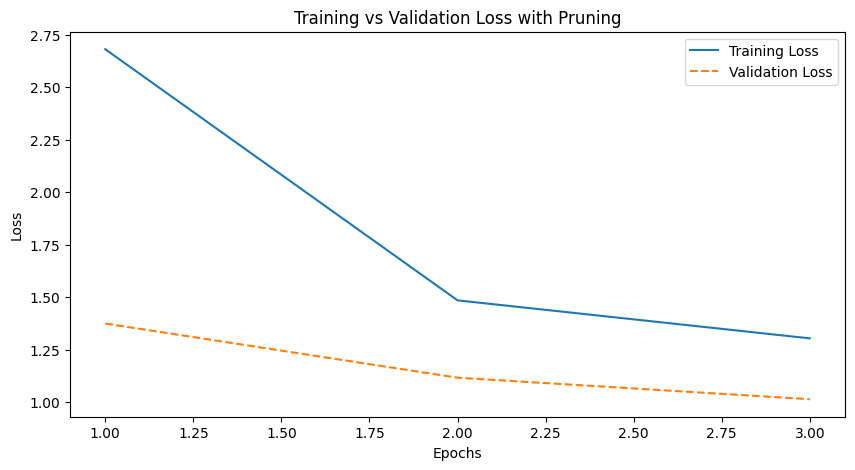

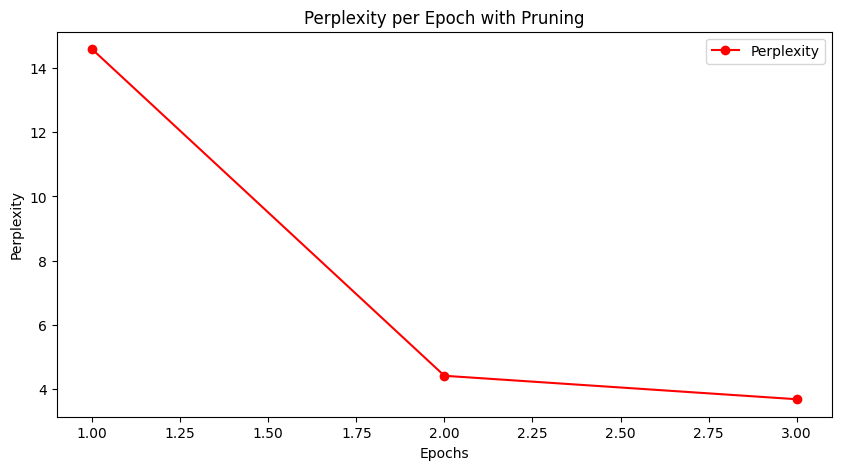

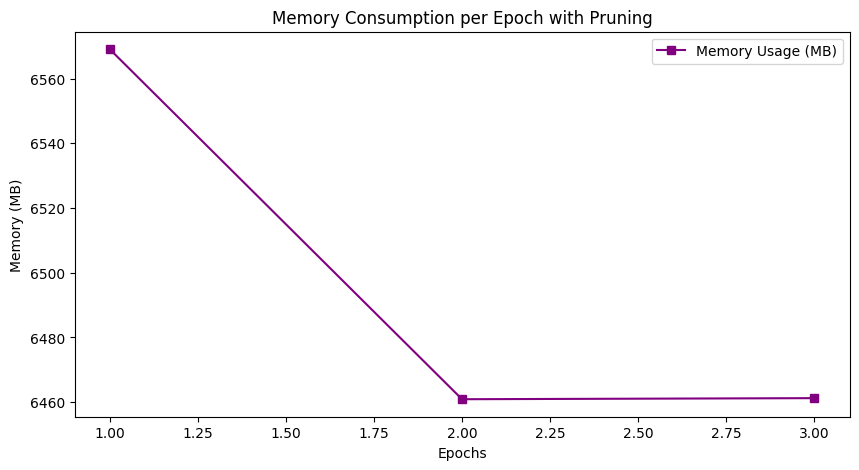

Fine-tuning complete.


In [ ]:
#Fine Tuning model -------------------------------------------------------------

# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust learning rate as needed
optimizer = optim.AdamW(
                        model.parameters(),
                        lr=2e-5,
                        weight_decay=0.01
                        )
lr_scheduler = get_scheduler(
                            "cosine",
                            optimizer=optimizer,
                            num_warmup_steps=500,
                            num_training_steps=10000
                            )
loss_fn = nn.CrossEntropyLoss(
                              ignore_index=TOKENIZER.pad_token_id,
                              label_smoothing=0.1
                              )

epochs = 3  # Adjust number of epochs as needed

# Mixed precision
scaler = GradScaler()

#Defining lists of metrics evaluation
train_losses = []
val_losses = []
perplexities = []
energy_consumptions = []
memory_usages = []
train_times = []

# Fine-tuning loop
for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch + 1}/{epochs}")

    #Lists and values initialization for each epochs
    loss_values = []
    nb_batch = []
    tracker = EmissionsTracker()
    tracker.start()

    start_time = time.time()
    total_loss = 0
    total_samples = 0
    i = 0

    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        i+=1
        nb_batch.append(i)

        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Forward pass
        with autocast():
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        #Backward pass
        loss.backward()

        #Updates weights
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        #Loss calculation
        total_loss += loss.item()
        loss_values.append(loss.item())
        total_samples += len(labels)

        # Scale the loss
        print(f"Batch {i}/{len(train_dataloader)} - Loss: {loss.item()}")

    #Keep track
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss}")

    # Perplexity Calculation
    perplexity = torch.exp(torch.tensor(sum(loss_values) / len(loss_values)))
    perplexities.append(perplexity.item())
    print(f"Epoch {epoch+1}/{epochs}, Perplexity: {perplexity:.2f}")

    # Validation Step
    model.eval()
    val_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            total_val_samples += len(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}")

    #Evaluate memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    memory_usages.append(memory_usage)
    print(f"Epoch {epoch+1}/{epochs}, Memory Usage: {memory_usage} MB")

    #Evaluate training time per step
    total_time = time.time() - start_time
    train_times.append(total_time / 60)
    print(f"Epoch {epoch+1}/{epochs}, Total Training Time: {total_time / 60:.2f} minutes")

    #Track energy consumption
    tracker.stop()
    print(f"Epoch {epoch+1}/{epochs}, Energy Consumption: {tracker}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss with Pruning")
plt.legend()
plt.show()

# Plot Perplexity with Pruning
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), perplexities, label="Perplexity", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity per Epoch with Pruning")
plt.legend()
plt.show()

# Plot Memory Usage with pruning
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), memory_usages, label="Memory Usage (MB)", marker="s", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Memory (MB)")
plt.title("Memory Consumption per Epoch with Pruning")
plt.legend()
plt.show()

# Save the trained model (optional)
torch.save(model.state_dict(), "trained_model.pth")

print("Fine-tuning complete.")


#### Quantization ( for large batch test)

In [ ]:
#QUANTIZATION -----------------------------------------------------------------
#ONLY NECESSARY IF TESTED WITH LARGE BATCH TEST

"""
import torch
from transformers import T5ForConditionalGeneration
import torch.nn.utils.prune as prune
import os
import sys

# Now apply dynamic quantization after pruning
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Layer: {name}, dtype: {module.weight.dtype}")

torch.save(quantized_model.state_dict(), "t5_quantized.pth")

print(f"Quantized Model Size: {os.path.getsize('t5_quantized.pth') / 1e6:.2f} MB")

print("T5 model dynamically quantized.")

"""

'import torch\nfrom transformers import T5ForConditionalGeneration\nimport torch.nn.utils.prune as prune\nimport os\nimport sys\n\n# Now apply dynamic quantization after pruning\nquantized_model = torch.quantization.quantize_dynamic(\n    model, {torch.nn.Linear}, dtype=torch.qint8\n)\n\nfor name, module in quantized_model.named_modules():\n    if isinstance(module, torch.nn.Linear):\n        print(f"Layer: {name}, dtype: {module.weight.dtype}")\n\ntorch.save(quantized_model.state_dict(), "t5_quantized.pth")\n\nprint(f"Quantized Model Size: {os.path.getsize(\'t5_quantized.pth\') / 1e6:.2f} MB")\n\nprint("T5 model dynamically quantized.")'

#### Test and evaluate model

In [ ]:
#Test and evaluate model-------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#Private out of the loop test
def generate_conversation(persona1, persona2):
    input_text = persona1 + persona2
    input_ids = TOKENIZER(input_text, return_tensors="pt").input_ids

    # Generate response
    output_ids = model.generate(input_ids,
                                max_length=150, #should have enlarged size
                                num_beams=5,
                                temperature=0.7
                                )
    output_text = TOKENIZER.decode(output_ids[0],
                                   skip_special_tokens=True
                                   )

    return output_text

# Test with new critic ---
persona1 = "I love hiking and nature walks. I also enjoy photography."
persona2 = "I prefer staying indoors and reading books. I love mystery novels."
generated_conversation = generate_conversation(persona1, persona2)

#print generated conversation on new critic
print("Out of the loop test : \n Generated Chatbot Conversation:\n",
      generated_conversation
      )

###Test with dataset ---

# Defining functions for evaluations

# Ensure predictions and references are tokenized properly before decoding
def decode_predictions(predictions):
    return [TOKENIZER.decode(p.tolist(), skip_special_tokens=True) if isinstance(p, torch.Tensor) else TOKENIZER.decode(p, skip_special_tokens=True) for p in predictions]

def decode_references(references):
    return [TOKENIZER.decode(r.tolist(), skip_special_tokens=True) if isinstance(r, torch.Tensor) else TOKENIZER.decode(r, skip_special_tokens=True) for r in references]
def calculate_rouge_score(predictions, true_labels):
    rouge = Rouge()

    # Ensure predictions and labels are converted properly
    predictions_decoded = []
    true_labels_decoded = []

    for p, t in zip(predictions, true_labels):
        # Remove any out-of-range IDs (e.g., -100 used for ignored padding)
        p = [token_id for token_id in p if token_id >= 0]
        t = [token_id for token_id in t if token_id >= 0]

        # Decode only if there are valid tokens
        pred_text = TOKENIZER.decode(p, skip_special_tokens=True) if p else ""
        true_text = TOKENIZER.decode(t, skip_special_tokens=True) if t else ""

        if pred_text.strip():
            predictions_decoded.append(pred_text)
            true_labels_decoded.append(true_text)

    # Calculate ROUGE scores only if valid predictions exist
    if predictions_decoded:
        scores = rouge.get_scores(predictions_decoded, true_labels_decoded, avg=True)
    else:
        scores = {
            'rouge-1': {'f': 0, 'p': 0, 'r': 0},
            'rouge-2': {'f': 0, 'p': 0, 'r': 0},
            'rouge-l': {'f': 0, 'p': 0, 'r': 0}
        }

    return scores

def calculate_persona_consistency_score(persona_1_statements, persona_2_statements, predicted_response_text):
    # Initialize a SentenceTransformer model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')

    # Encode persona statements
    persona_1_embedding = sentence_model.encode(persona_1_statements, convert_to_tensor=True)
    persona_2_embedding = sentence_model.encode(persona_2_statements, convert_to_tensor=True)

    # Encode predicted response
    response_embedding = sentence_model.encode(predicted_response_text, convert_to_tensor=True)

    # Compute cosine similarity
    user_1_score = util.pytorch_cos_sim(response_embedding, persona_1_embedding).mean().item()
    user_2_score = util.pytorch_cos_sim(response_embedding, persona_2_embedding).mean().item()

    # Compute average consistency score
    avg_consistency_score = (user_1_score + user_2_score) / 2

    return avg_consistency_score, user_1_score, user_2_score

def calculate_mean_rouge(rouge_scores_list):
    """
    Returns:
        dict: Dictionary containing average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    # Initialize accumulators
    total_rouge_1_f = 0
    total_rouge_2_f = 0
    total_rouge_l_f = 0
    total_rouge_1_p = 0
    total_rouge_2_p = 0
    total_rouge_l_p = 0
    total_rouge_1_r = 0
    total_rouge_2_r = 0
    total_rouge_l_r = 0
    num_samples = len(rouge_scores_list)

    # Sum up all ROUGE scores
    for scores in rouge_scores_list:
        total_rouge_1_f += scores['rouge-1']['f']
        total_rouge_2_f += scores['rouge-2']['f']
        total_rouge_l_f += scores['rouge-l']['f']
        total_rouge_1_p += scores['rouge-1']['p']
        total_rouge_2_p += scores['rouge-2']['p']
        total_rouge_l_p += scores['rouge-l']['p']
        total_rouge_1_r += scores['rouge-1']['r']
        total_rouge_2_r += scores['rouge-2']['r']
        total_rouge_l_r += scores['rouge-l']['r']

    # Compute mean values
    mean_rouge = {
        "rouge-1": {"f": total_rouge_1_f / num_samples, "p": total_rouge_1_p / num_samples, "r": total_rouge_1_r / num_samples},
        "rouge-2": {"f": total_rouge_2_f / num_samples, "p": total_rouge_2_p / num_samples, "r": total_rouge_2_r / num_samples},
        "rouge-l": {"f": total_rouge_l_f / num_samples, "p": total_rouge_l_p / num_samples, "r": total_rouge_l_r / num_samples}
    }

    return mean_rouge

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    all_predictions = []  # Store all predictions
    all_labels = []  # Store all labels
    all_rouge_scores = []
    all_consistency_scores = []
    all_user1_scores = []
    all_user2_scores = []
    all_inference_times = []

    with torch.no_grad():
      total_loss = 0
      start_time = time.time()

      for batch in test_dataloader:
            input_ids =  batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Pass labels as decoder_input_ids during evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # Get predictions from the logits
            predictions = torch.argmax(outputs.logits, dim=2)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Compare predictions with shifted labels for accuracy calculation
            shifted_labels = labels[..., 1:]  # Shift labels to the right by one position
            predictions = predictions[..., :-1]  # Remove the last prediction
            # Calculate accuracy for valid predictions (ignoring padding)
            active_positions = shifted_labels != -100  # Ignore padding positions (-100)
            correct_predictions = (predictions == shifted_labels) * active_positions
            correct += correct_predictions.sum().item()
            total += active_positions.sum().item()

            # Rouge score is a recall-based evaluation
            rouge_score= calculate_rouge_score(shifted_labels, predictions)
            all_rouge_scores.append(rouge_score)

      total_time = time.time() - start_time
      inference_time = total_time / len(test_dataloader)

    mean_rouge_score=calculate_mean_rouge(all_rouge_scores)
    # Create a DataFrame for logging
    # Persona Consistency Score
    average_consistency_score, user_1_score, user_2_score = calculate_persona_consistency_score(
                       persona1, persona2, " ".join(generated_conversation))
    evaluation_data = {
      "Metric": ["Rouge-1 F1", "Rouge-2 F1", "Rouge-L F1",
               "Average Consistency Score", "Persona 1 Score", "Persona 2 Score", "Inference Time"],
    "Value": [
        mean_rouge_score["rouge-1"]["f"],
        mean_rouge_score["rouge-2"]["f"],
        mean_rouge_score["rouge-l"]["f"],
        average_consistency_score,
        user_1_score,
        user_2_score,
        inference_time
    ]
      }
    df = pd.DataFrame(evaluation_data)

    return df

    # Display in a tab (Colab only)
    data_table.DataTable(df)

# Evaluation
evaluate(model, test_dataloader)


Out of the loop test : 
 Generated Chatbot Conversation:
 User 1: Hi, I'm [user 1's name]. User 2: Hi, I'm [user 2's name]. User 2: Hi, I'm [user 2's name]. User 1: What do you like to do for fun? User 2: I like to go hiking and nature walks.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Metric,Value
0,Rouge-1 F1,0.627432
1,Rouge-2 F1,0.409210
2,Rouge-L F1,0.614945
3,Average Consistency Score,-0.040727
4,Persona 1 Score,-0.085348
5,Persona 2 Score,0.003894
6,Inference Time,1.608557
